In [1]:
import datetime
from IPython import display
import os
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xmltodict
import yfinance as yf

Loading in data shared in [this Reddit post](https://www.reddit.com/r/Superstonk/comments/pu1usx/reverse_repo_operations_history_table/hewdile/?utm_source=reddit&utm_medium=web2x&context=3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   acceptDates     188 non-null    datetime64[ns]
 1   acceptAmount    188 non-null    float64       
 2   counterParties  188 non-null    int64         
 3   avgPerPart      177 non-null    float64       
 4   award           177 non-null    float64       
 5   amountDelta     187 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 8.9 KB


None

<AxesSubplot:xlabel='acceptDates'>

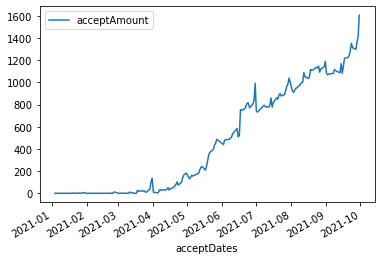

In [2]:
historical = pd.read_csv('FED_ONRRP_HISTORICAL.CSV')
historical['acceptDates'] = pd.to_datetime(historical.acceptDates)
display.display(historical.info())
historical.plot('acceptDates', 'acceptAmount')

In [46]:
def fetch_rpp_xml(start_date, end_date):
    url = f'https://markets.newyorkfed.org/read?productCode=70&startDt={start_date}&endDt={end_date}&eventCodes=730&operationTypes=Reverse%20Repo&format=xml'
    
    response = requests.get(url)
    if response.status_code == 200:
        return response
    else:
        raise UserWarning('Unsuccessful attempt at fetching market data')


def pandaize_market_data(response):
    response_dict = xmltodict.parse(response.content)
    
    operations_list = response_dict['markets']['repo']['operations']['operation']
    
    df = pd.DataFrame(operations_list)
    # Now unpack the transaction details from the nested dict
    details = df.apply(lambda row: pd.Series(row.details['detail']), axis=1)
    df = pd.concat([df, details], axis=1)
    df = df.drop(columns=['details'])
    
    date_cols = [col for col in df.columns if 'Date' in col] + ['lastUpdated']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    
    num_cols = ['termCalenderDays',
                'participatingCpty', 'acceptedCpty',
                'totalAmtSubmitted', 'totalAmtAccepted', 'amtAccepted', 'amtSubmitted',
                'percentAwardRate', 'percentOfferingRate']
    df = df.astype({col: np.number for col in num_cols})
    return df


def default_start_end_dates(start_date, end_date):
    if not end_date:
        end_date = str(datetime.datetime.today().date())
    if not start_date:
        # default to Jan 1 of this year
        start_date = str(datetime.datetime.today().replace(month=1, day=1).date())
    return start_date, end_date

def fetch_rpp_market_data_df(start_date=None, end_date=None):
    start_date, end_date = default_start_end_dates(start_date, end_date)
    # if not end_date:
    #     end_date = str(datetime.datetime.today().date())
    # if not start_date:
    #     # default to Jan 1 of this year
    #     start_date = str(datetime.datetime.today().replace(month=1, day=1).date())
    
    response = fetch_rpp_xml(start_date, end_date)
    df = pandaize_market_data(response)
    return df


def fetch_index_data_df(tickers=['^GSPC', '^DJI', '^IXIC'], start_date=None, end_date=None):
    start_date, end_date = default_start_end_dates(start_date, end_date)
    
    index_data = yf.download(tickers, start_date, end_date)
    index_cols = [f'adj_close_{col[1].strip("^")}' for col in index_data.columns if 'Adj Close' in col[0]]
    index_data_df = index_data.loc[:, ('Adj Close', slice(None))]
    index_data_df.columns = index_cols
    index_data_df = index_data_df.sort_index(ascending=False)
    return index_data_df


def rpp_market_features(rpp_df):
    rpp_cols = ['settlementDate', 'amtAccepted', 'amtSubmitted', 'percentAwardRate', 'percentOfferingRate', 'daily_amtAcc_diff', 'daily_amtAcc_pct_chg']
    rpp_df['daily_amtAcc_diff'] = rpp_df.amtAccepted.diff()
    rpp_df['daily_amtAcc_pct_chg'] = calc_pct_change(rpp_df, 'amtAccepted') #rpp_df.daily_amtAcc_diff.shift(-1) / rpp_df.amtAccepted
    
    return rpp_df[rpp_cols]


def calc_pct_change(df, col):
    return (df[col] / df[col].shift(-1) - 1) * 100


def winsorize(df, col, min_val, max_val):
    df[col] = np.min((df[col], np.ones(df.shape[0]) * max_val), axis=0)
    df[col] = np.max((df[col], np.ones(df.shape[0]) * min_val), axis=0)
    return df

def index_data_features(index_df, tickers=['^GSPC', '^DJI', '^IXIC']):
   
    adj_close_cols = [f'adj_close_{tick.strip("^")}' for tick in tickers]
    adj_close_diff_cols = [f'{col}_diff' for col in adj_close_cols]
    index_df[adj_close_diff_cols] = index_df[adj_close_cols].diff()

    for ticker in tickers:
        ticker = ticker.strip("^")
        pct_change_col = f'close_pct_change_{ticker}'
        index_df[pct_change_col] = calc_pct_change(index_df, f'adj_close_{ticker}') #(index_df[f'adj_close_{ticker}'] / index_df[f'adj_close_{ticker}'].shift(-1) - 1) * 100
        # index_df[pct_change_col] = index_df[pct_change_col].shift(1)
        
    return index_df

In [59]:
start_date = '2015-06-01'
end_date = '2022-06-10'
tickers = tickers=['^GSPC', '^DJI', '^IXIC']

df = fetch_rpp_market_data_df(start_date=start_date, end_date=end_date)
rpp_df = rpp_market_features(df)
index_data_df = fetch_index_data_df(tickers, start_date=start_date, end_date=end_date)
index_data_df = index_data_features(index_data_df)

[*********************100%***********************]  3 of 3 completed


In [60]:
merged_df = rpp_df.merge(index_data_df,
                         left_on='settlementDate',
                         right_index=True,
                         how='outer'
                        )

In [71]:
merged_df[plot_cols]

,settlementDate,amtAccepted,daily_amtAcc_diff,daily_amtAcc_pct_chg,percentAwardRate,adj_close_GSPC,adj_close_IXIC,adj_close_DJI,close_pct_change_GSPC,close_pct_change_DJI,close_pct_change_IXIC
0.0,2022-06-10,2.162885e+12,NaN,0.960035,0.8,NaN,NaN,NaN,NaN,NaN,NaN
1.0,2022-06-09,2.142318e+12,-2.056700e+10,0.095361,0.8,4017.820068,11754.230469,32272.789062,-2.379869,-1.938900,-2.747242
2.0,2022-06-08,2.140277e+12,-2.041000e+09,2.337292,0.8,4115.770020,12086.269531,32910.898438,-1.079395,-0.811456,-0.730671
3.0,2022-06-07,2.091395e+12,-4.888200e+10,2.514689,0.8,4160.680176,12175.230469,33180.140625,0.952339,0.803139,0.944008
4.0,2022-06-06,2.040093e+12,-5.130200e+10,0.436435,0.8,4121.430176,12061.370117,32915.781250,0.313740,0.048882,0.404901
...,...,...,...,...,...,...,...,...,...,...,...
NaN,2017-10-09,NaN,NaN,NaN,NaN,2544.729980,6579.729980,22761.070312,-0.180443,-0.055325,-0.158572
NaN,2016-11-11,NaN,NaN,NaN,NaN,2164.449951,5237.109863,18847.660156,-0.139795,0.211503,0.543504
NaN,2016-10-10,NaN,NaN,NaN,NaN,2163.659912,5328.669922,18329.039062,0.460591,0.485452,0.685323
NaN,2015-11-11,NaN,NaN,NaN,NaN,2075.000000,5067.020020,17702.220703,-0.322809,-0.315292,-0.319092


In [81]:
merged_df['daily_amtAcc_pct_chg'].describe(percentiles=[0.8, 0.9, 0.95, 0.99])

C:\Users\shadd\Anaconda3\envs\rpp_market_scrape\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


count    1748.000000
mean             inf
std              NaN
min      -100.000000
50%         0.711528
80%        33.260481
90%       173.157030
95%      2769.166667
99%              NaN
max              inf
Name: daily_amtAcc_pct_chg, dtype: float64

In [83]:
plot_cols = ['settlementDate', 'amtAccepted', 'daily_amtAcc_diff', 'daily_amtAcc_pct_chg', 'percentAwardRate',
             'adj_close_GSPC', 'adj_close_IXIC', 'adj_close_DJI',
             'close_pct_change_GSPC', 'close_pct_change_DJI', 'close_pct_change_IXIC']

plot_df = merged_df[plot_cols].copy()
plot_df[['adj_close_GSPC', 'adj_close_IXIC', 'adj_close_DJI', 'close_pct_change_GSPC', 'close_pct_change_DJI', 'close_pct_change_IXIC']] = (
    plot_df[['adj_close_GSPC', 'adj_close_IXIC', 'adj_close_DJI',
             'close_pct_change_GSPC', 'close_pct_change_DJI', 'close_pct_change_IXIC']].shift(1)
)

plot_df['daily_amtAcc_pct_chg'] = plot_df['daily_amtAcc_pct_chg'].replace([-np.inf, np.inf], np.nan)
plot_df = plot_df.dropna(how='any')
plot_df = winsorize(plot_df, 'daily_amtAcc_pct_chg', -1e5, 1e5)
plot_df.describe(percentiles=[0.8, 0.9, 0.95, 0.99])

,amtAccepted,daily_amtAcc_diff,daily_amtAcc_pct_chg,percentAwardRate,adj_close_GSPC,adj_close_IXIC,adj_close_DJI,close_pct_change_GSPC,close_pct_change_DJI,close_pct_change_IXIC
count,1.656000e+03,1.656000e+03,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000
mean,2.740832e+11,-8.169300e+08,937.819837,0.794281,2924.704389,8325.411279,24979.040495,0.032795,0.029230,0.043551
std,5.152474e+11,4.532715e+10,8248.855122,0.791549,807.863710,3335.485876,5854.676781,1.186250,1.199562,1.368613
min,1.000000e+06,-8.134960e+11,-99.999049,0.000000,1829.079956,4266.839844,15660.179688,-11.984055,-12.926546,-12.321331
50%,6.468250e+10,-3.850000e+07,0.711528,0.500000,2741.034912,7419.119873,24835.959961,0.063511,0.058882,0.091139
80%,2.089360e+11,8.713000e+09,28.493254,1.700000,3821.350098,12338.950195,30932.369141,0.697474,0.675836,0.870175
90%,1.366118e+12,2.398400e+10,101.045732,2.000000,4361.760010,14139.270020,34499.511719,1.126427,1.102568,1.387767
95%,1.636822e+12,4.382800e+10,663.892686,2.250000,4513.297485,14896.972168,35138.033203,1.537690,1.492559,1.884788
99%,1.902100e+12,1.251735e+11,22877.569444,2.250000,4700.723999,15782.219385,36132.325195,2.695724,2.648496,3.579228
max,2.140277e+12,7.915280e+11,100000.000000,2.250000,4796.560059,16057.440430,36799.648438,9.382774,11.365041,9.345998


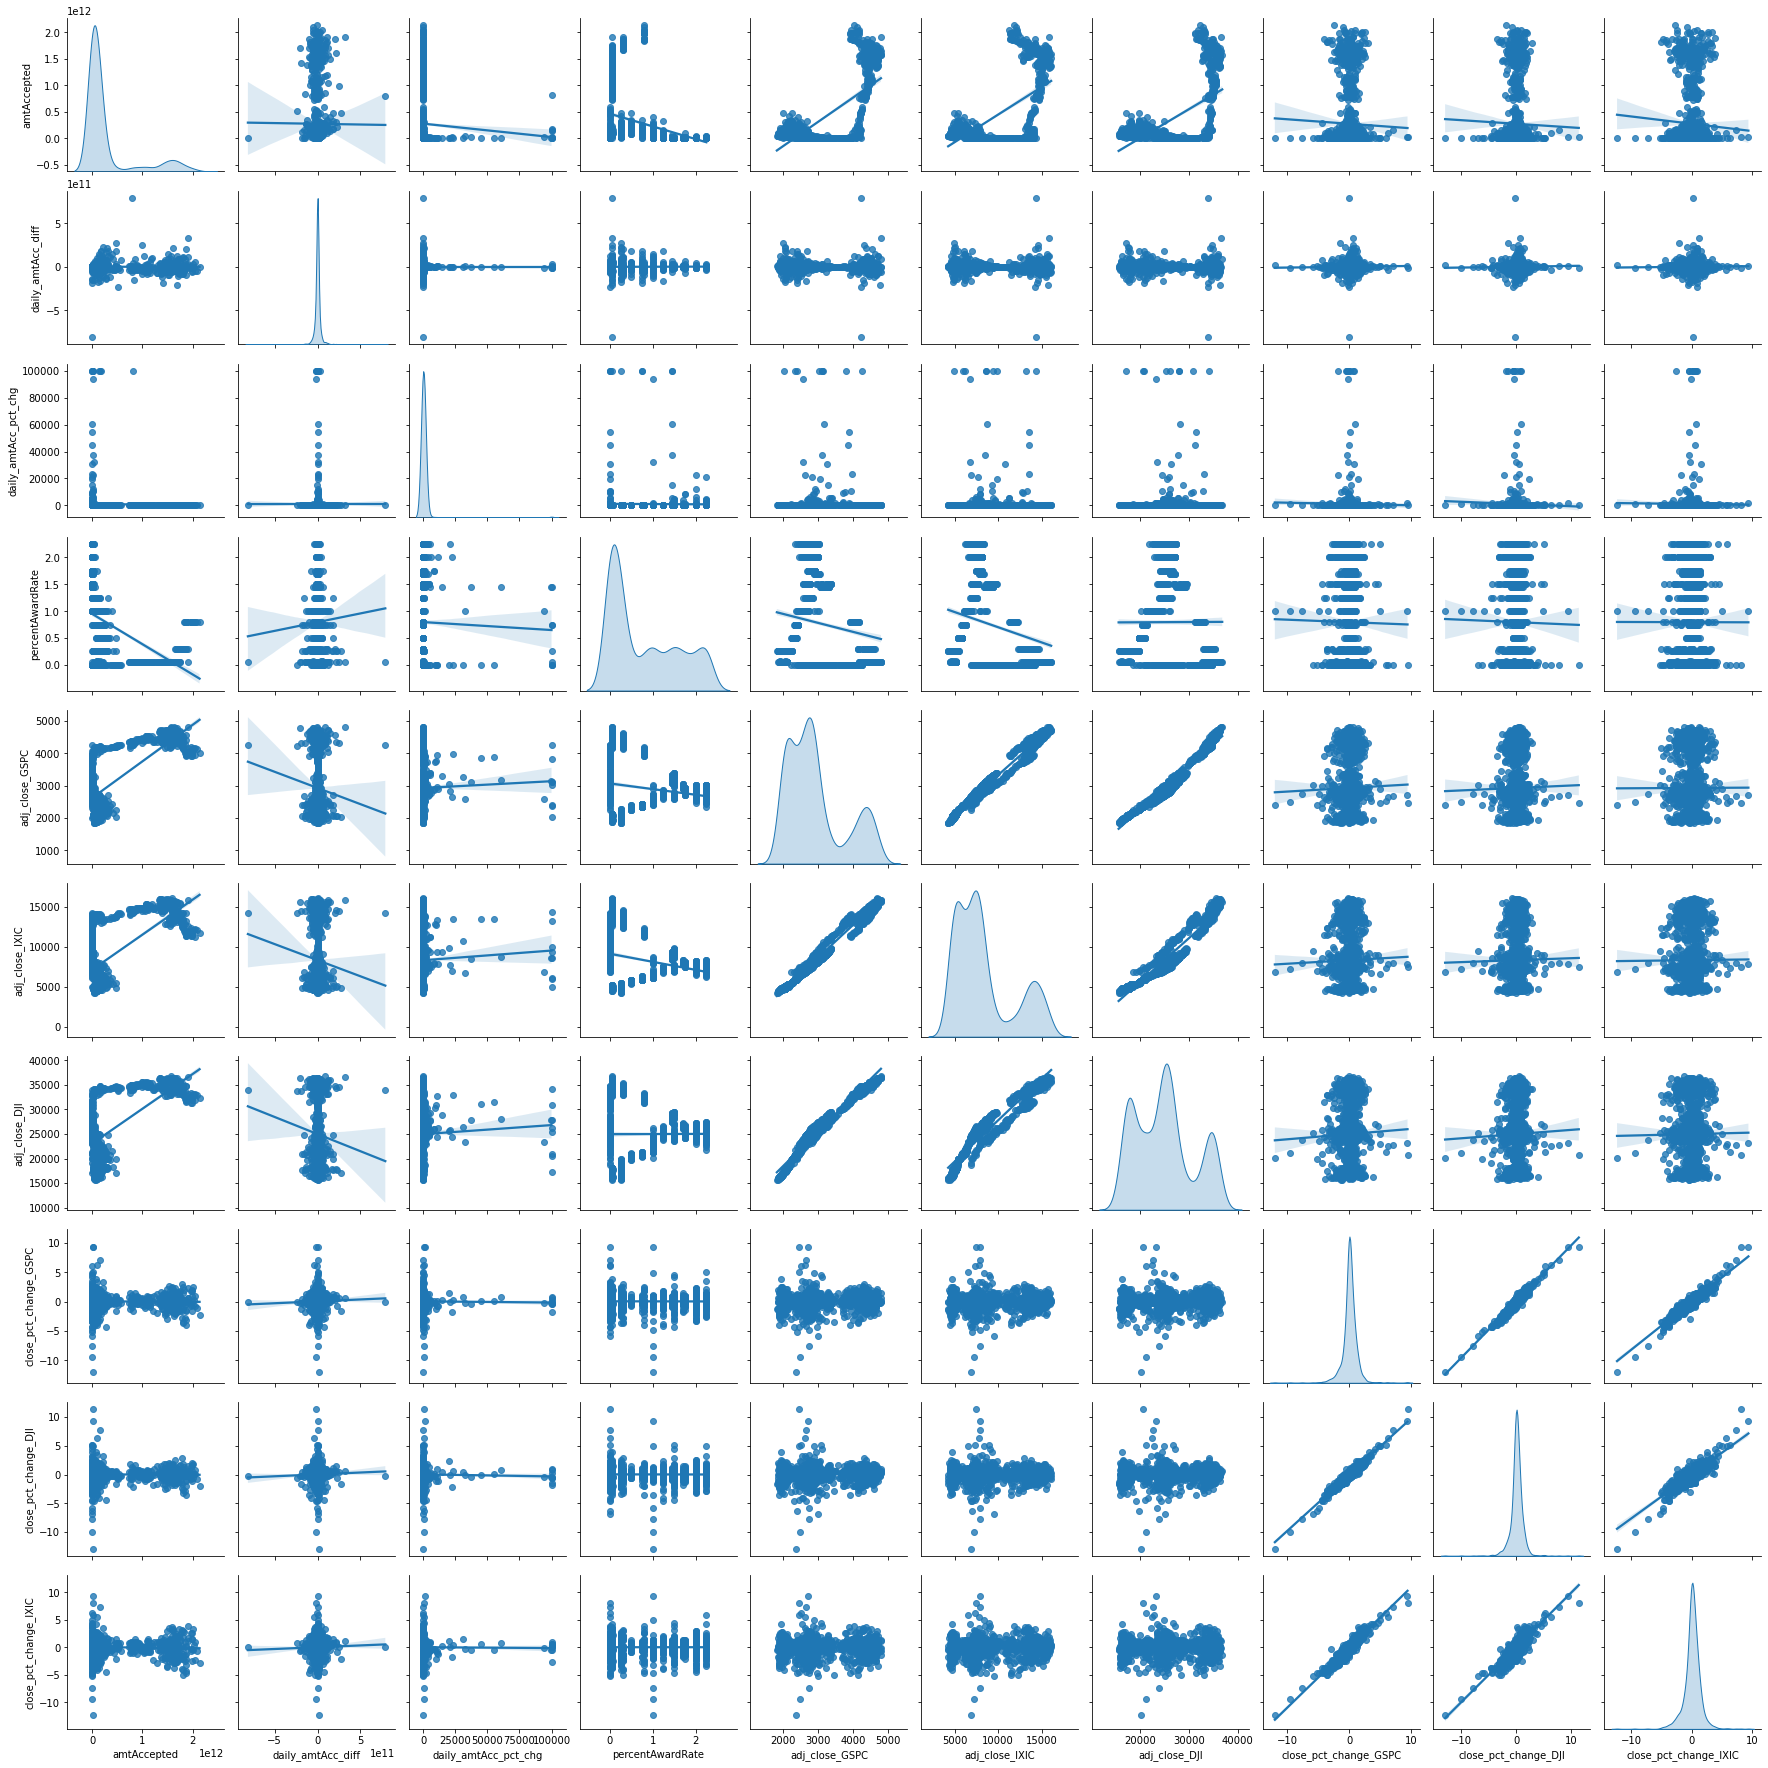

In [84]:
ax = sns.pairplot(plot_df,
            kind='reg', diag_kind='kde')

In [87]:
corr_matrix = plot_df.corr()

In [88]:
corr_matrix

,amtAccepted,daily_amtAcc_diff,daily_amtAcc_pct_chg,percentAwardRate,adj_close_GSPC,adj_close_IXIC,adj_close_DJI,close_pct_change_GSPC,close_pct_change_DJI,close_pct_change_IXIC
amtAccepted,1.000000,-0.002374,-0.040391,-0.366568,0.719384,0.676434,0.622785,-0.019654,-0.015885,-0.036674
daily_amtAcc_diff,-0.002374,1.000000,0.000196,0.018561,-0.055952,-0.054598,-0.053869,0.024727,0.024721,0.021454
daily_amtAcc_pct_chg,-0.040391,0.000196,1.000000,-0.015448,0.021464,0.030011,0.026013,-0.014061,-0.024262,-0.009518
percentAwardRate,-0.366568,0.018561,-0.015448,1.000000,-0.171152,-0.239109,0.003426,-0.006883,-0.006856,-0.000511
adj_close_GSPC,0.719384,-0.055952,0.021464,-0.171152,1.000000,0.990649,0.980558,0.016405,0.011305,0.001648
adj_close_IXIC,0.676434,-0.054598,0.030011,-0.239109,0.990649,1.000000,0.961525,0.015899,0.008818,0.003963
adj_close_DJI,0.622785,-0.053869,0.026013,0.003426,0.980558,0.961525,1.000000,0.021500,0.017599,0.007036
close_pct_change_GSPC,-0.019654,0.024727,-0.014061,-0.006883,0.016405,0.015899,0.021500,1.000000,0.970381,0.950004
close_pct_change_DJI,-0.015885,0.024721,-0.024262,-0.006856,0.011305,0.008818,0.017599,0.970381,1.000000,0.872987
close_pct_change_IXIC,-0.036674,0.021454,-0.009518,-0.000511,0.001648,0.003963,0.007036,0.950004,0.872987,1.000000


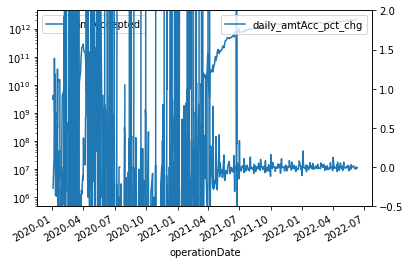

In [49]:
_, ax = plt.subplots()
df.plot('operationDate', 'amtAccepted', ax=ax,)
ax2 = ax.twinx()
df.plot('operationDate', 'daily_amtAcc_pct_chg', ax=ax2)
ax.set_yscale('log')
ax2.set_ylim(-.5, 2)

plt.show()

In [8]:
!function(){var t={81184:function(){
    Element.prototype.matches||(Element.prototype.matches=Element.prototype.msMatchesSelector||Element.prototype.webkitMatchesSelector),
    Element.prototype.closest||(Element.prototype.closest=function(t)
                                {var e=this;
                                 if(!document.documentElement.contains(e))return null;
                                 do{if(e.matches(t))return e;
                                    e=e.parentElement||e.parentNode}while(null!==e&&1===e.nodeType);
                                 return null})},13099:function(t)
                   {t.exports=function(t)
                    {if("function"!=typeof t)throw TypeError(String(t)+" is not a function");return t}}
                   ,96077:function(t,e,n)
                   {var r=n(70111);
                    t.exports=function(t){if(!r(t)&&null!==t)throw TypeError("Can't set "+String(t)+" as a prototype");return t}},
                   51223:function(t,e,n){var r=n(5112),i=n(70030),o=n(3070),a=r("unscopables"),c=Array.prototype;null==c[a]&&o.f(c,a,{configurable:!0,value:i(null)})
                                         ,t.exports=function(t){c[a][t]=!0}},
                   31530:function(t,e,n){"use strict";var r=n(28710).charAt; t.exports=function(t,e,n){return e+(n?r(t,e).length:1)}},
                   25787:function(t){t.exports=function(t,e,n){if(!(t instanceof e))throw TypeError("Incorrect "+(n?n+" ":"")+"invocation");return t}},
                   19670:function(t,e,n){var r=n(70111);t.exports=function(t){if(!r(t))throw TypeError(String(t)+" is not an object");return t}},
                   24019:function(t){t.exports="undefined"!=typeof ArrayBuffer&&"undefined"!=typeof DataView},
                   90260:function(t,e,n){"use strict";var r,
                                         i=n(24019),
                                         o=n(19781),
                                         a=n(17854),
                                         c=n(70111),
                                         s=n(86656),
                                         u=n(70648),
                                         f=n(68880),
                                         l=n(31320),
                                         h=n(3070).f,
                                         p=n(79518),
                                         d=n(27674),
                                         v=n(5112),
                                         g=n(69711),
                                         y=a.Int8Array,m=y&&y.prototype,w=a.Uint8ClampedArray,b=w&&w.prototype,x=y&&p(y),S=m&&p(m),E=Object.prototype,k=E.isPrototypeOf,A=v("toStringTag"),T=g("TYPED_ARRAY_TAG"),O=i&&!!d&&"Opera"!==u(a.opera),_=!1,R={Int8Array:1,Uint8Array:1,Uint8ClampedArray:1,Int16Array:2,Uint16Array:2,Int32Array:4,Uint32Array:4,Float32Array:4,Float64Array:8},I={BigInt64Array:8,BigUint64Array:8},L=function(t){if(!c(t))return!1;var e=u(t);return s(R,e)||s(I,e)};for(r in R)a[r]||(O=!1);if((!O||"function"!=typeof x||x===Function.prototype)&&(x=function(){throw TypeError("Incorrect invocation")},O))for(r in R)a[r]&&d(a[r],x);if((!O||!S||S===E)&&(S=x.prototype,O))for(r in R)a[r]&&d(a[r].prototype,S);if(O&&p(b)!==S&&d(b,S),o&&!s(S,A))for(r in _=!0,h(S,A,{get:function(){return c(this)?this[T]:void 0}}),R)a[r]&&f(a[r],T,r);t.exports={NATIVE_ARRAY_BUFFER_VIEWS:O,TYPED_ARRAY_TAG:_&&T,aTypedArray:function(t){if(L(t))return t;throw TypeError("Target is not a typed array")},aTypedArrayConstructor:function(t){if(d){if(k.call(x,t))return t}else for(var e in R)if(s(R,r)){var n=a[e];if(n&&(t===n||k.call(n,t)))return t}throw TypeError("Target is not a typed array constructor")},exportTypedArrayMethod:function(t,e,n){if(o){if(n)for(var r in R){var i=a[r];i&&s(i.prototype,t)&&delete i.prototype[t]}S[t]&&!n||l(S,t,n?e:O&&m[t]||e)}},exportTypedArrayStaticMethod:function(t,e,n){var r,i;if(o){if(d){if(n)for(r in R)(i=a[r])&&s(i,t)&&delete i[t];if(x[t]&&!n)return;try{return l(x,t,n?e:O&&y[t]||e)}catch(t){}}for(r in R)!(i=a[r])||i[t]&&!n||l(i,t,e)}},isView:function(t){if(!c(t))return!1;var e=u(t);return"DataView"===e||s(R,e)||s(I,e)},isTypedArray:L,TypedArray:x,TypedArrayPrototype:S}},13331:function(t,e,n){"use strict";var r=n(17854),i=n(19781),o=n(24019),a=n(68880),c=n(12248),s=n(47293),u=n(25787),f=n(99958),l=n(17466),h=n(57067),p=n(11179),d=n(79518),v=n(27674),g=n(8006).f,y=n(3070).f,m=n(21285),w=n(58003),b=n(29909),x=b.get,S=b.set,E="ArrayBuffer",k="DataView",A="Wrong index",T=r.ArrayBuffer,O=T,_=r.DataView,R=_&&_.prototype,I=Object.prototype,L=r.RangeError,M=p.pack,N=p.unpack,j=function(t){return[255&t]},P=function(t){return[255&t,t>>8&255]},D=function(t){return[255&t,t>>8&255,t>>16&255,t>>24&255]},C=function(t){return t[3]<<24|t[2]<<16|t[1]<<8|t[0]},U=function(t){return M(t,23,4)},F=function(t){return M(t,52,8)},B=function(t,e){y(t.prototype,e,{get:function(){return x(this)[e]}})},q=function(t,e,n,r){var i=h(n),o=x(t);if(i+e>o.byteLength)throw L(A);var a=x(o.buffer).bytes,c=i+o.byteOffset,s=a.slice(c,c+e);return r?s:s.reverse()},z=function(t,e,n,r,i,o){var a=h(n),c=x(t);if(a+e>c.byteLength)throw L(A);for(var s=x(c.buffer).bytes,u=a+c.byteOffset,f=r(+i),l=0;l<e;l++)s[u+l]=f[o?l:e-l-1]};if(o){if(!s((function(){T(1)}))||!s((function(){new T(-1)}))||s((function(){return new T,new T(1.5),new T(NaN),T.name!=E}))){for(var V,W=(O=function(t){return u(this,O),new T(h(t))}).prototype=T.prototype,G=g(T),H=0;G.length>H;)(V=G[H++])in O||a(O,V,T[V]);W.constructor=O}v&&d(R)!==I&&v(R,I);var Y=new _(new O(2)),$=R.setInt8;Y.setInt8(0,2147483648),Y.setInt8(1,2147483649),!Y.getInt8(0)&&Y.getInt8(1)||c(R,{setInt8:function(t,e){$.call(this,t,e<<24>>24)},setUint8:function(t,e){$.call(this,t,e<<24>>24)}},{unsafe:!0})}else O=function(t){u(this,O,E);var e=h(t);S(this,{bytes:m.call(new Array(e),0),byteLength:e}),i||(this.byteLength=e)},_=function(t,e,n){u(this,_,k),u(t,O,k);var r=x(t).byteLength,o=f(e);if(o<0||o>r)throw L("Wrong offset");if(o+(n=void 0===n?r-o:l(n))>r)throw L("Wrong length");S(this,{buffer:t,byteLength:n,byteOffset:o}),i||(this.buffer=t,this.byteLength=n,this.byteOffset=o)},i&&(B(O,"byteLength"),B(_,"buffer"),B(_,"byteLength"),B(_,"byteOffset")),c(_.prototype,{getInt8:function(t){return q(this,1,t)[0]<<24>>24},getUint8:function(t){return q(this,1,t)[0]},getInt16:function(t){var e=q(this,2,t,arguments.length>1?arguments[1]:void 0);return(e[1]<<8|e[0])<<16>>16},getUint16:function(t){var e=q(this,2,t,arguments.length>1?arguments[1]:void 0);return e[1]<<8|e[0]},getInt32:function(t){return C(q(this,4,t,arguments.length>1?arguments[1]:void 0))},getUint32:function(t){return C(q(this,4,t,arguments.length>1?arguments[1]:void 0))>>>0},getFloat32:function(t){return N(q(this,4,t,arguments.length>1?arguments[1]:void 0),23)},getFloat64:function(t){return N(q(this,8,t,arguments.length>1?arguments[1]:void 0),52)},setInt8:function(t,e){z(this,1,t,j,e)},setUint8:function(t,e){z(this,1,t,j,e)},setInt16:function(t,e){z(this,2,t,P,e,arguments.length>2?arguments[2]:void 0)},setUint16:function(t,e){z(this,2,t,P,e,arguments.length>2?arguments[2]:void 0)},setInt32:function(t,e){z(this,4,t,D,e,arguments.length>2?arguments[2]:void 0)},setUint32:function(t,e){z(this,4,t,D,e,arguments.length>2?arguments[2]:void 0)},setFloat32:function(t,e){z(this,4,t,U,e,arguments.length>2?arguments[2]:void 0)},setFloat64:function(t,e){z(this,8,t,F,e,arguments.length>2?arguments[2]:void 0)}});w(O,E),w(_,k),t.exports={ArrayBuffer:O,DataView:_}},1048:function(t,e,n){"use strict";var r=n(47908),i=n(51400),o=n(17466),a=Math.min;t.exports=[].copyWithin||function(t,e){var n=r(this),c=o(n.length),s=i(t,c),u=i(e,c),f=arguments.length>2?arguments[2]:void 0,l=a((void 0===f?c:i(f,c))-u,c-s),h=1;for(u<s&&s<u+l&&(h=-1,u+=l-1,s+=l-1);l-- >0;)u in n?n[s]=n[u]:delete n[s],s+=h,u+=h;return n}},21285:function(t,e,n){"use strict";var r=n(47908),i=n(51400),o=n(17466);t.exports=function(t){for(var e=r(this),n=o(e.length),a=arguments.length,c=i(a>1?arguments[1]:void 0,n),s=a>2?arguments[2]:void 0,u=void 0===s?n:i(s,n);u>c;)e[c++]=t;return e}},18533:function(t,e,n){"use strict";var r=n(42092).forEach,i=n(9341)("forEach");t.exports=i?[].forEach:function(t){return r(this,t,arguments.length>1?arguments[1]:void 0)}},48457:function(t,e,n){"use strict";var r=n(49974),i=n(47908),o=n(53411),a=n(97659),c=n(17466),s=n(86135),u=n(71246);t.exports=function(t){var e,n,f,l,h,p,d=i(t),v="function"==typeof this?this:Array,g=arguments.length,y=g>1?arguments[1]:void 0,m=void 0!==y,w=u(d),b=0;if(m&&(y=r(y,g>2?arguments[2]:void 0,2)),null==w||v==Array&&a(w))for(n=new v(e=c(d.length));e>b;b++)p=m?y(d[b],b):d[b],s(n,b,p);else for(h=(l=w.call(d)).next,n=new v;!(f=h.call(l)).done;b++)p=m?o(l,y,[f.value,b],!0):f.value,s(n,b,p);return n.length=b,n}},41318:function(t,e,n){var r=n(45656),i=n(17466),o=n(51400),a=function(t){return function(e,n,a){var c,s=r(e),u=i(s.length),f=o(a,u);if(t&&n!=n){for(;u>f;)if((c=s[f++])!=c)return!0}else for(;u>f;f++)if((t||f in s)&&s[f]===n)return t||f||0;return!t&&-1}};t.exports={includes:a(!0),indexOf:a(!1)}},42092:function(t,e,n){var r=n(49974),i=n(68361),o=n(47908),a=n(17466),c=n(65417),s=[].push,u=function(t){var e=1==t,n=2==t,u=3==t,f=4==t,l=6==t,h=7==t,p=5==t||l;return function(d,v,g,y){for(var m,w,b=o(d),x=i(b),S=r(v,g,3),E=a(x.length),k=0,A=y||c,T=e?A(d,E):n||h?A(d,0):void 0;E>k;k++)if((p||k in x)&&(w=S(m=x[k],k,b),t))if(e)T[k]=w;else if(w)switch(t){case 3:return!0;case 5:return m;case 6:return k;case 2:s.call(T,m)}else switch(t){case 4:return!1;case 7:s.call(T,m)}return l?-1:u||f?f:T}};t.exports={forEach:u(0),map:u(1),filter:u(2),some:u(3),every:u(4),find:u(5),findIndex:u(6),filterOut:u(7)}},86583:function(t,e,n){"use strict";var r=n(45656),i=n(99958),o=n(17466),a=n(9341),c=Math.min,s=[].lastIndexOf,u=!!s&&1/[1].lastIndexOf(1,-0)<0,f=a("lastIndexOf"),l=u||!f;t.exports=l?function(t){if(u)return s.apply(this,arguments)||0;var e=r(this),n=o(e.length),a=n-1;for(arguments.length>1&&(a=c(a,i(arguments[1]))),a<0&&(a=n+a);a>=0;a--)if(a in e&&e[a]===t)return a||0;return-1}:s},81194:function(t,e,n){var r=n(47293),i=n(5112),o=n(7392),a=i("species");t.exports=function(t){return o>=51||!r((function(){var e=[];return(e.constructor={})[a]=function(){return{foo:1}},1!==e[t](Boolean).foo}))}},9341:function(t,e,n){"use strict";var r=n(47293);t.exports=function(t,e){var n=[][t];return!!n&&r((function(){n.call(null,e||function(){throw 1},1)}))}},53671:function(t,e,n){var r=n(13099),i=n(47908),o=n(68361),a=n(17466),c=function(t){return function(e,n,c,s){r(n);var u=i(e),f=o(u),l=a(u.length),h=t?l-1:0,p=t?-1:1;if(c<2)for(;;){if(h in f){s=f[h],h+=p;break}if(h+=p,t?h<0:l<=h)throw TypeError("Reduce of empty array with no initial value")}for(;t?h>=0:l>h;h+=p)h in f&&(s=n(s,f[h],h,u));return s}};t.exports={left:c(!1),right:c(!0)}},65417:function(t,e,n){var r=n(70111),i=n(43157),o=n(5112)("species");t.exports=function(t,e){var n;return i(t)&&("function"!=typeof(n=t.constructor)||n!==Array&&!i(n.prototype)?r(n)&&null===(n=n[o])&&(n=void 0):n=void 0),new(void 0===n?Array:n)(0===e?0:e)}},53411:function(t,e,n){var r=n(19670),i=n(99212);t.exports=function(t,e,n,o){try{return o?e(r(n)[0],n[1]):e(n)}catch(e){throw i(t),e}}},17072:function(t,e,n){var r=n(5112)("iterator"),i=!1;try{var o=0,a={next:function(){return{done:!!o++}},return:function(){i=!0}};a[r]=function(){return this},Array.from(a,(function(){throw 2}))}catch(t){}t.exports=function(t,e){if(!e&&!i)return!1;var n=!1;try{var o={};o[r]=function(){return{next:function(){return{done:n=!0}}}},t(o)}catch(t){}return n}},84326:function(t){var e={}.toString;t.exports=function(t){return e.call(t).slice(8,-1)}},70648:function(t,e,n){var r=n(51694),i=n(84326),o=n(5112)("toStringTag"),a="Arguments"==i(function(){return arguments}());t.exports=r?i:function(t){var e,n,r;return void 0===t?"Undefined":null===t?"Null":"string"==typeof(n=function(t,e){try{return t[e]}catch(t){}}(e=Object(t),o))?n:a?i(e):"Object"==(r=i(e))&&"function"==typeof e.callee?"Arguments":r}},95631:function(t,e,n){"use strict";var r=n(3070).f,i=n(70030),o=n(12248),a=n(49974),c=n(25787),s=n(20408),u=n(70654),f=n(96340),l=n(19781),h=n(62423).fastKey,p=n(29909),d=p.set,v=p.getterFor;t.exports={getConstructor:function(t,e,n,u){var f=t((function(t,r){c(t,f,e),d(t,{type:e,index:i(null),first:void 0,last:void 0,size:0}),l||(t.size=0),null!=r&&s(r,t[u],{that:t,AS_ENTRIES:n})})),p=v(e),g=function(t,e,n){var r,i,o=p(t),a=y(t,e);return a?a.value=n:(o.last=a={index:i=h(e,!0),key:e,value:n,previous:r=o.last,next:void 0,removed:!1},o.first||(o.first=a),r&&(r.next=a),l?o.size++:t.size++,"F"!==i&&(o.index[i]=a)),t},y=function(t,e){var n,r=p(t),i=h(e);if("F"!==i)return r.index[i];for(n=r.first;n;n=n.next)if(n.key==e)return n};return o(f.prototype,{clear:function(){for(var t=p(this),e=t.index,n=t.first;n;)n.removed=!0,n.previous&&(n.previous=n.previous.next=void 0),delete e[n.index],n=n.next;t.first=t.last=void 0,l?t.size=0:this.size=0},delete:function(t){var e=this,n=p(e),r=y(e,t);if(r){var i=r.next,o=r.previous;delete n.index[r.index],r.removed=!0,o&&(o.next=i),i&&(i.previous=o),n.first==r&&(n.first=i),n.last==r&&(n.last=o),l?n.size--:e.size--}return!!r},forEach:function(t){for(var e,n=p(this),r=a(t,arguments.length>1?arguments[1]:void 0,3);e=e?e.next:n.first;)for(r(e.value,e.key,this);e&&e.removed;)e=e.previous},has:function(t){return!!y(this,t)}}),o(f.prototype,n?{get:function(t){var e=y(this,t);return e&&e.value},set:function(t,e){return g(this,0===t?0:t,e)}}:{add:function(t){return g(this,t=0===t?0:t,t)}}),l&&r(f.prototype,"size",{get:function(){return p(this).size}}),f},setStrong:function(t,e,n){var r=e+" Iterator",i=v(e),o=v(r);u(t,e,(function(t,e){d(this,{type:r,target:t,state:i(t),kind:e,last:void 0})}),(function(){for(var t=o(this),e=t.kind,n=t.last;n&&n.removed;)n=n.previous;return t.target&&(t.last=n=n?n.next:t.state.first)?"keys"==e?{value:n.key,done:!1}:"values"==e?{value:n.value,done:!1}:{value:[n.key,n.value],done:!1}:(t.target=void 0,{value:void 0,done:!0})}),n?"entries":"values",!n,!0),f(e)}}},29320:function(t,e,n){"use strict";var r=n(12248),i=n(62423).getWeakData,o=n(19670),a=n(70111),c=n(25787),s=n(20408),u=n(42092),f=n(86656),l=n(29909),h=l.set,p=l.getterFor,d=u.find,v=u.findIndex,g=0,y=function(t){return t.frozen||(t.frozen=new m)},m=function(){this.entries=[]},w=function(t,e){return d(t.entries,(function(t){return t[0]===e}))};m.prototype={get:function(t){var e=w(this,t);if(e)return e[1]},has:function(t){return!!w(this,t)},set:function(t,e){var n=w(this,t);n?n[1]=e:this.entries.push([t,e])},delete:function(t){var e=v(this.entries,(function(e){return e[0]===t}));return~e&&this.entries.splice(e,1),!!~e}},t.exports={getConstructor:function(t,e,n,u){var l=t((function(t,r){c(t,l,e),h(t,{type:e,id:g++,frozen:void 0}),null!=r&&s(r,t[u],{that:t,AS_ENTRIES:n})})),d=p(e),v=function(t,e,n){var r=d(t),a=i(o(e),!0);return!0===a?y(r).set(e,n):a[r.id]=n,t};return r(l.prototype,{delete:function(t){var e=d(this);if(!a(t))return!1;var n=i(t);return!0===n?y(e).delete(t):n&&f(n,e.id)&&delete n[e.id]},has:function(t){var e=d(this);if(!a(t))return!1;var n=i(t);return!0===n?y(e).has(t):n&&f(n,e.id)}}),r(l.prototype,n?{get:function(t){var e=d(this);if(a(t)){var n=i(t);return!0===n?y(e).get(t):n?n[e.id]:void 0}},set:function(t,e){return v(this,t,e)}}:{add:function(t){return v(this,t,!0)}}),l}}},77710:function(t,e,n){"use strict";var r=n(82109),i=n(17854),o=n(54705),a=n(31320),c=n(62423),s=n(20408),u=n(25787),f=n(70111),l=n(47293),h=n(17072),p=n(58003),d=n(79587);t.exports=function(t,e,n){var v=-1!==t.indexOf("Map"),g=-1!==t.indexOf("Weak"),y=v?"set":"add",m=i[t],w=m&&m.prototype,b=m,x={},S=function(t){var e=w[t];a(w,t,"add"==t?function(t){return e.call(this,0===t?0:t),this}:"delete"==t?function(t){return!(g&&!f(t))&&e.call(this,0===t?0:t)}:"get"==t?function(t){return g&&!f(t)?void 0:e.call(this,0===t?0:t)}:"has"==t?function(t){return!(g&&!f(t))&&e.call(this,0===t?0:t)}:function(t,n){return e.call(this,0===t?0:t,n),this})};if(o(t,"function"!=typeof m||!(g||w.forEach&&!l((function(){(new m).entries().next()})))))b=n.getConstructor(e,t,v,y),c.REQUIRED=!0;else if(o(t,!0)){var E=new b,k=E[y](g?{}:-0,1)!=E,A=l((function(){E.has(1)})),T=h((function(t){new m(t)})),O=!g&&l((function(){for(var t=new m,e=5;e--;)t[y](e,e);return!t.has(-0)}));T||((b=e((function(e,n){u(e,b,t);var r=d(new m,e,b);return null!=n&&s(n,r[y],{that:r,AS_ENTRIES:v}),r}))).prototype=w,w.constructor=b),(A||O)&&(S("delete"),S("has"),v&&S("get")),(O||k)&&S(y),g&&w.clear&&delete w.clear}return x[t]=b,r({global:!0,forced:b!=m},x),p(b,t),g||n.setStrong(b,t,v),b}},99920:function(t,e,n){var r=n(86656),i=n(53887),o=n(31236),a=n(3070);t.exports=function(t,e){for(var n=i(e),c=a.f,s=o.f,u=0;u<n.length;u++){var f=n[u];r(t,f)||c(t,f,s(e,f))}}},84964:function(t,e,n){var r=n(5112)("match");t.exports=function(t){var e=/./;try{"/./"[t](e)}catch(n){try{return e[r]=!1,"/./"[t](e)}catch(t){}}return!1}},49920:function(t,e,n){var r=n(47293);t.exports=!r((function(){function t(){}return t.prototype.constructor=null,Object.getPrototypeOf(new t)!==t.prototype}))},14230:function(t,e,n){var r=n(84488),i=/"/g;t.exports=function(t,e,n,o){var a=String(r(t)),c="<"+e;return""!==n&&(c+=" "+n+'="'+String(o).replace(i,"&quot;")+'"'),c+">"+a+"</"+e+">"}},24994:function(t,e,n){"use strict";var r=n(13383).IteratorPrototype,i=n(70030),o=n(79114),a=n(58003),c=n(97497),s=function(){return this};t.exports=function(t,e,n){var u=e+" Iterator";return t.prototype=i(r,{next:o(1,n)}),a(t,u,!1,!0),c[u]=s,t}},68880:function(t,e,n){var r=n(19781),i=n(3070),o=n(79114);t.exports=r?function(t,e,n){return i.f(t,e,o(1,n))}:function(t,e,n){return t[e]=n,t}},79114:function(t){t.exports=function(t,e){return{enumerable:!(1&t),configurable:!(2&t),writable:!(4&t),value:e}}},86135:function(t,e,n){"use strict";var r=n(57593),i=n(3070),o=n(79114);t.exports=function(t,e,n){var a=r(e);a in t?i.f(t,a,o(0,n)):t[a]=n}},85573:function(t,e,n){"use strict";var r=n(47293),i=n(76650).start,o=Math.abs,a=Date.prototype,c=a.getTime,s=a.toISOString;t.exports=r((function(){return"0385-07-25T07:06:39.999Z"!=s.call(new Date(-50000000000001))}))||!r((function(){s.call(new Date(NaN))}))?function(){if(!isFinite(c.call(this)))throw RangeError("Invalid time value");var t=this,e=t.getUTCFullYear(),n=t.getUTCMilliseconds(),r=e<0?"-":e>9999?"+":"";return r+i(o(e),r?6:4,0)+"-"+i(t.getUTCMonth()+1,2,0)+"-"+i(t.getUTCDate(),2,0)+"T"+i(t.getUTCHours(),2,0)+":"+i(t.getUTCMinutes(),2,0)+":"+i(t.getUTCSeconds(),2,0)+"."+i(n,3,0)+"Z"}:s},38709:function(t,e,n){"use strict";var r=n(19670),i=n(57593);t.exports=function(t){if("string"!==t&&"number"!==t&&"default"!==t)throw TypeError("Incorrect hint");return i(r(this),"number"!==t)}},70654:function(t,e,n){"use strict";var r=n(82109),i=n(24994),o=n(79518),a=n(27674),c=n(58003),s=n(68880),u=n(31320),f=n(5112),l=n(31913),h=n(97497),p=n(13383),d=p.IteratorPrototype,v=p.BUGGY_SAFARI_ITERATORS,g=f("iterator"),y="keys",m="values",w="entries",b=function(){return this};t.exports=function(t,e,n,f,p,x,S){i(n,e,f);var E,k,A,T=function(t){if(t===p&&L)return L;if(!v&&t in R)return R[t];switch(t){case y:case m:case w:return function(){return new n(this,t)}}return function(){return new n(this)}},O=e+" Iterator",_=!1,R=t.prototype,I=R[g]||R["@@iterator"]||p&&R[p],L=!v&&I||T(p),M="Array"==e&&R.entries||I;if(M&&(E=o(M.call(new t)),d!==Object.prototype&&E.next&&(l||o(E)===d||(a?a(E,d):"function"!=typeof E[g]&&s(E,g,b)),c(E,O,!0,!0),l&&(h[O]=b))),p==m&&I&&I.name!==m&&(_=!0,L=function(){return I.call(this)}),l&&!S||R[g]===L||s(R,g,L),h[e]=L,p)if(k={values:T(m),keys:x?L:T(y),entries:T(w)},S)for(A in k)(v||_||!(A in R))&&u(R,A,k[A]);else r({target:e,proto:!0,forced:v||_},k);return k}},97235:function(t,e,n){var r=n(40857),i=n(86656),o=n(6061),a=n(3070).f;t.exports=function(t){var e=r.Symbol||(r.Symbol={});i(e,t)||a(e,t,{value:o.f(t)})}},19781:function(t,e,n){var r=n(47293);t.exports=!r((function(){return 7!=Object.defineProperty({},1,{get:function(){return 7}})[1]}))},80317:function(t,e,n){var r=n(17854),i=n(70111),o=r.document,a=i(o)&&i(o.createElement);t.exports=function(t){return a?o.createElement(t):{}}},48324:function(t){t.exports={CSSRuleList:0,CSSStyleDeclaration:0,CSSValueList:0,ClientRectList:0,DOMRectList:0,DOMStringList:0,DOMTokenList:1,DataTransferItemList:0,FileList:0,HTMLAllCollection:0,HTMLCollection:0,HTMLFormElement:0,HTMLSelectElement:0,MediaList:0,MimeTypeArray:0,NamedNodeMap:0,NodeList:1,PaintRequestList:0,Plugin:0,PluginArray:0,SVGLengthList:0,SVGNumberList:0,SVGPathSegList:0,SVGPointList:0,SVGStringList:0,SVGTransformList:0,SourceBufferList:0,StyleSheetList:0,TextTrackCueList:0,TextTrackList:0,TouchList:0}},6833:function(t,e,n){var r=n(88113);t.exports=/(iphone|ipod|ipad).*applewebkit/i.test(r)},35268:function(t,e,n){var r=n(84326),i=n(17854);t.exports="process"==r(i.process)},71036:function(t,e,n){var r=n(88113);t.exports=/web0s(?!.*chrome)/i.test(r)},88113:function(t,e,n){var r=n(35005);t.exports=r("navigator","userAgent")||""},7392:function(t,e,n){var r,i,o=n(17854),a=n(88113),c=o.process,s=c&&c.versions,u=s&&s.v8;u?i=(r=u.split("."))[0]+r[1]:a&&(!(r=a.match(/Edge\/(\d+)/))||r[1]>=74)&&(r=a.match(/Chrome\/(\d+)/))&&(i=r[1]),t.exports=i&&+i},80748:function(t){t.exports=["constructor","hasOwnProperty","isPrototypeOf","propertyIsEnumerable","toLocaleString","toString","valueOf"]},82109:function(t,e,n){var r=n(17854),i=n(31236).f,o=n(68880),a=n(31320),c=n(83505),s=n(99920),u=n(54705);t.exports=function(t,e){var n,f,l,h,p,d=t.target,v=t.global,g=t.stat;if(n=v?r:g?r[d]||c(d,{}):(r[d]||{}).prototype)for(f in e){if(h=e[f],l=t.noTargetGet?(p=i(n,f))&&p.value:n[f],!u(v?f:d+(g?".":"#")+f,t.forced)&&void 0!==l){if(typeof h==typeof l)continue;s(h,l)}(t.sham||l&&l.sham)&&o(h,"sham",!0),a(n,f,h,t)}}},47293:function(t){t.exports=function(t){try{return!!t()}catch(t){return!0}}},27007:function(t,e,n){"use strict";n(74916);var r=n(31320),i=n(47293),o=n(5112),a=n(22261),c=n(68880),s=o("species"),u=!i((function(){var t=/./;return t.exec=function(){var t=[];return t.groups={a:"7"},t},"7"!=="".replace(t,"$<a>")})),f="$0"==="a".replace(/./,"$0"),l=o("replace"),h=!!/./[l]&&""===/./[l]("a","$0"),p=!i((function(){var t=/(?:)/,e=t.exec;t.exec=function(){return e.apply(this,arguments)};var n="ab".split(t);return 2!==n.length||"a"!==n[0]||"b"!==n[1]}));t.exports=function(t,e,n,l){var d=o(t),v=!i((function(){var e={};return e[d]=function(){return 7},7!=""[t](e)})),g=v&&!i((function(){var e=!1,n=/a/;return"split"===t&&((n={}).constructor={},n.constructor[s]=function(){return n},n.flags="",n[d]=/./[d]),n.exec=function(){return e=!0,null},n[d](""),!e}));if(!v||!g||"replace"===t&&(!u||!f||h)||"split"===t&&!p){var y=/./[d],m=n(d,""[t],(function(t,e,n,r,i){return e.exec===a?v&&!i?{done:!0,value:y.call(e,n,r)}:{done:!0,value:t.call(n,e,r)}:{done:!1}}),{REPLACE_KEEPS_$0:f,REGEXP_REPLACE_SUBSTITUTES_UNDEFINED_CAPTURE:h}),w=m[0],b=m[1];r(String.prototype,t,w),r(RegExp.prototype,d,2==e?function(t,e){return b.call(t,this,e)}:function(t){return b.call(t,this)})}l&&c(RegExp.prototype[d],"sham",!0)}},6790:function(t,e,n){"use strict";var r=n(43157),i=n(17466),o=n(49974),a=function(t,e,n,c,s,u,f,l){for(var h,p=s,d=0,v=!!f&&o(f,l,3);d<c;){if(d in n){if(h=v?v(n[d],d,e):n[d],u>0&&r(h))p=a(t,e,h,i(h.length),p,u-1)-1;else{if(p>=9007199254740991)throw TypeError("Exceed the acceptable array length");t[p]=h}p++}d++}return p};t.exports=a},76677:function(t,e,n){var r=n(47293);t.exports=!r((function(){return Object.isExtensible(Object.preventExtensions({}))}))},49974:function(t,e,n){var r=n(13099);t.exports=function(t,e,n){if(r(t),void 0===e)return t;switch(n){case 0:return function(){return t.call(e)};case 1:return function(n){return t.call(e,n)};case 2:return function(n,r){return t.call(e,n,r)};case 3:return function(n,r,i){return t.call(e,n,r,i)}}return function(){return t.apply(e,arguments)}}},27065:function(t,e,n){"use strict";var r=n(13099),i=n(70111),o=[].slice,a={},c=function(t,e,n){if(!(e in a)){for(var r=[],i=0;i<e;i++)r[i]="a["+i+"]";a[e]=Function("C,a","return new C("+r.join(",")+")")}return a[e](t,n)};t.exports=Function.bind||function(t){var e=r(this),n=o.call(arguments,1),a=function(){var r=n.concat(o.call(arguments));return this instanceof a?c(e,r.length,r):e.apply(t,r)};return i(e.prototype)&&(a.prototype=e.prototype),a}},35005:function(t,e,n){var r=n(40857),i=n(17854),o=function(t){return"function"==typeof t?t:void 0};t.exports=function(t,e){return arguments.length<2?o(r[t])||o(i[t]):r[t]&&r[t][e]||i[t]&&i[t][e]}},71246:function(t,e,n){var r=n(70648),i=n(97497),o=n(5112)("iterator");t.exports=function(t){if(null!=t)return t[o]||t["@@iterator"]||i[r(t)]}},18554:function(t,e,n){var r=n(19670),i=n(71246);t.exports=function(t){var e=i(t);if("function"!=typeof e)throw TypeError(String(t)+" is not iterable");return r(e.call(t))}},10647:function(t,e,n){var r=n(47908),i=Math.floor,o="".replace,a=/\$([$&'`]|\d{1,2}|<[^>]*>)/g,c=/\$([$&'`]|\d{1,2})/g;t.exports=function(t,e,n,s,u,f){var l=n+t.length,h=s.length,p=c;return void 0!==u&&(u=r(u),p=a),o.call(f,p,(function(r,o){var a;switch(o.charAt(0)){case"$":return"$";case"&":return t;case"`":return e.slice(0,n);case"'":return e.slice(l);case"<":a=u[o.slice(1,-1)];break;default:var c=+o;if(0===c)return r;if(c>h){var f=i(c/10);return 0===f?r:f<=h?void 0===s[f-1]?o.charAt(1):s[f-1]+o.charAt(1):r}a=s[c-1]}return void 0===a?"":a}))}},17854:function(t,e,n){var r=function(t){return t&&t.Math==Math&&t};t.exports=r("object"==typeof globalThis&&globalThis)||r("object"==typeof window&&window)||r("object"==typeof self&&self)||r("object"==typeof n.g&&n.g)||function(){return this}()||Function("return this")()},86656:function(t){var e={}.hasOwnProperty;t.exports=function(t,n){return e.call(t,n)}},3501:function(t){t.exports={}},842:function(t,e,n){var r=n(17854);t.exports=function(t,e){var n=r.console;n&&n.error&&(1===arguments.length?n.error(t):n.error(t,e))}},60490:function(t,e,n){var r=n(35005);t.exports=r("document","documentElement")},64664:function(t,e,n){var r=n(19781),i=n(47293),o=n(80317);t.exports=!r&&!i((function(){return 7!=Object.defineProperty(o("div"),"a",{get:function(){return 7}}).a}))},11179:function(t){var e=Math.abs,n=Math.pow,r=Math.floor,i=Math.log,o=Math.LN2;t.exports={pack:function(t,a,c){var s,u,f,l=new Array(c),h=8*c-a-1,p=(1<<h)-1,d=p>>1,v=23===a?n(2,-24)-n(2,-77):0,g=t<0||0===t&&1/t<0?1:0,y=0;for((t=e(t))!=t||t===1/0?(u=t!=t?1:0,s=p):(s=r(i(t)/o),t*(f=n(2,-s))<1&&(s--,f*=2),(t+=s+d>=1?v/f:v*n(2,1-d))*f>=2&&(s++,f/=2),s+d>=p?(u=0,s=p):s+d>=1?(u=(t*f-1)*n(2,a),s+=d):(u=t*n(2,d-1)*n(2,a),s=0));a>=8;l[y++]=255&u,u/=256,a-=8);for(s=s<<a|u,h+=a;h>0;l[y++]=255&s,s/=256,h-=8);return l[--y]|=128*g,l},unpack:function(t,e){var r,i=t.length,o=8*i-e-1,a=(1<<o)-1,c=a>>1,s=o-7,u=i-1,f=t[u--],l=127&f;for(f>>=7;s>0;l=256*l+t[u],u--,s-=8);for(r=l&(1<<-s)-1,l>>=-s,s+=e;s>0;r=256*r+t[u],u--,s-=8);if(0===l)l=1-c;else{if(l===a)return r?NaN:f?-1/0:1/0;r+=n(2,e),l-=c}return(f?-1:1)*r*n(2,l-e)}}},68361:function(t,e,n){var r=n(47293),i=n(84326),o="".split;t.exports=r((function(){return!Object("z").propertyIsEnumerable(0)}))?function(t){return"String"==i(t)?o.call(t,""):Object(t)}:Object},79587:function(t,e,n){var r=n(70111),i=n(27674);t.exports=function(t,e,n){var o,a;return i&&"function"==typeof(o=e.constructor)&&o!==n&&r(a=o.prototype)&&a!==n.prototype&&i(t,a),t}},42788:function(t,e,n){var r=n(5465),i=Function.toString;"function"!=typeof r.inspectSource&&(r.inspectSource=function(t){return i.call(t)}),t.exports=r.inspectSource},62423:function(t,e,n){var r=n(3501),i=n(70111),o=n(86656),a=n(3070).f,c=n(69711),s=n(76677),u=c("meta"),f=0,l=Object.isExtensible||function(){return!0},h=function(t){a(t,u,{value:{objectID:"O"+ ++f,weakData:{}}})},p=t.exports={REQUIRED:!1,fastKey:function(t,e){if(!i(t))return"symbol"==typeof t?t:("string"==typeof t?"S":"P")+t;if(!o(t,u)){if(!l(t))return"F";if(!e)return"E";h(t)}return t[u].objectID},getWeakData:function(t,e){if(!o(t,u)){if(!l(t))return!0;if(!e)return!1;h(t)}return t[u].weakData},onFreeze:function(t){return s&&p.REQUIRED&&l(t)&&!o(t,u)&&h(t),t}};r[u]=!0},29909:function(t,e,n){var r,i,o,a=n(68536),c=n(17854),s=n(70111),u=n(68880),f=n(86656),l=n(5465),h=n(6200),p=n(3501),d=c.WeakMap;if(a){var v=l.state||(l.state=new d),g=v.get,y=v.has,m=v.set;r=function(t,e){return e.facade=t,m.call(v,t,e),e},i=function(t){return g.call(v,t)||{}},o=function(t){return y.call(v,t)}}else{var w=h("state");p[w]=!0,r=function(t,e){return e.facade=t,u(t,w,e),e},i=function(t){return f(t,w)?t[w]:{}},o=function(t){return f(t,w)}}t.exports={set:r,get:i,has:o,enforce:function(t){return o(t)?i(t):r(t,{})},getterFor:function(t){return function(e){var n;if(!s(e)||(n=i(e)).type!==t)throw TypeError("Incompatible receiver, "+t+" required");return n}}}},97659:function(t,e,n){var r=n(5112),i=n(97497),o=r("iterator"),a=Array.prototype;t.exports=function(t){return void 0!==t&&(i.Array===t||a[o]===t)}},43157:function(t,e,n){var r=n(84326);t.exports=Array.isArray||function(t){return"Array"==r(t)}},54705:function(t,e,n){var r=n(47293),i=/#|\.prototype\./,o=function(t,e){var n=c[a(t)];return n==u||n!=s&&("function"==typeof e?r(e):!!e)},a=o.normalize=function(t){return String(t).replace(i,".").toLowerCase()},c=o.data={},s=o.NATIVE="N",u=o.POLYFILL="P";t.exports=o},18730:function(t,e,n){var r=n(70111),i=Math.floor;t.exports=function(t){return!r(t)&&isFinite(t)&&i(t)===t}},70111:function(t){t.exports=function(t){return"object"==typeof t?null!==t:"function"==typeof t}},31913:function(t){t.exports=!1},47850:function(t,e,n){var r=n(70111),i=n(84326),o=n(5112)("match");t.exports=function(t){var e;return r(t)&&(void 0!==(e=t[o])?!!e:"RegExp"==i(t))}},20408:function(t,e,n){var r=n(19670),i=n(97659),o=n(17466),a=n(49974),c=n(71246),s=n(99212),u=function(t,e){this.stopped=t,this.result=e};t.exports=function(t,e,n){var f,l,h,p,d,v,g,y=n&&n.that,m=!(!n||!n.AS_ENTRIES),w=!(!n||!n.IS_ITERATOR),b=!(!n||!n.INTERRUPTED),x=a(e,y,1+m+b),S=function(t){return f&&s(f),new u(!0,t)},E=function(t){return m?(r(t),b?x(t[0],t[1],S):x(t[0],t[1])):b?x(t,S):x(t)};if(w)f=t;else{if("function"!=typeof(l=c(t)))throw TypeError("Target is not iterable");if(i(l)){for(h=0,p=o(t.length);p>h;h++)if((d=E(t[h]))&&d instanceof u)return d;return new u(!1)}f=l.call(t)}for(v=f.next;!(g=v.call(f)).done;){try{d=E(g.value)}catch(t){throw s(f),t}if("object"==typeof d&&d&&d instanceof u)return d}return new u(!1)}},99212:function(t,e,n){var r=n(19670);t.exports=function(t){var e=t.return;if(void 0!==e)return r(e.call(t)).value}},13383:function(t,e,n){"use strict";var r,i,o,a=n(47293),c=n(79518),s=n(68880),u=n(86656),f=n(5112),l=n(31913),h=f("iterator"),p=!1;[].keys&&("next"in(o=[].keys())?(i=c(c(o)))!==Object.prototype&&(r=i):p=!0);var d=null==r||a((function(){var t={};return r[h].call(t)!==t}));d&&(r={}),l&&!d||u(r,h)||s(r,h,(function(){return this})),t.exports={IteratorPrototype:r,BUGGY_SAFARI_ITERATORS:p}},97497:function(t){t.exports={}},66736:function(t){var e=Math.expm1,n=Math.exp;t.exports=!e||e(10)>22025.465794806718||e(10)<22025.465794806718||-2e-17!=e(-2e-17)?function(t){return 0==(t=+t)?t:t>-1e-6&&t<1e-6?t+t*t/2:n(t)-1}:e},26130:function(t,e,n){var r=n(64310),i=Math.abs,o=Math.pow,a=o(2,-52),c=o(2,-23),s=o(2,127)*(2-c),u=o(2,-126);t.exports=Math.fround||function(t){var e,n,o=i(t),f=r(t);return o<u?f*(o/u/c+1/a-1/a)*u*c:(n=(e=(1+c/a)*o)-(e-o))>s||n!=n?f*(1/0):f*n}},26513:function(t){var e=Math.log;t.exports=Math.log1p||function(t){return(t=+t)>-1e-8&&t<1e-8?t-t*t/2:e(1+t)}},64310:function(t){t.exports=Math.sign||function(t){return 0==(t=+t)||t!=t?t:t<0?-1:1}},95948:function(t,e,n){var r,i,o,a,c,s,u,f,l=n(17854),h=n(31236).f,p=n(20261).set,d=n(6833),v=n(71036),g=n(35268),y=l.MutationObserver||l.WebKitMutationObserver,m=l.document,w=l.process,b=l.Promise,x=h(l,"queueMicrotask"),S=x&&x.value;S||(r=function(){var t,e;for(g&&(t=w.domain)&&t.exit();i;){e=i.fn,i=i.next;try{e()}catch(t){throw i?a():o=void 0,t}}o=void 0,t&&t.enter()},d||g||v||!y||!m?b&&b.resolve?(u=b.resolve(void 0),f=u.then,a=function(){f.call(u,r)}):a=g?function(){w.nextTick(r)}:function(){p.call(l,r)}:(c=!0,s=m.createTextNode(""),new y(r).observe(s,{characterData:!0}),a=function(){s.data=c=!c})),t.exports=S||function(t){var e={fn:t,next:void 0};o&&(o.next=e),i||(i=e,a()),o=e}},13366:function(t,e,n){var r=n(17854);t.exports=r.Promise},30133:function(t,e,n){var r=n(35268),i=n(7392),o=n(47293);t.exports=!!Object.getOwnPropertySymbols&&!o((function(){return!Symbol.sham&&(r?38===i:i>37&&i<41)}))},590:function(t,e,n){var r=n(47293),i=n(5112),o=n(31913),a=i("iterator");t.exports=!r((function(){var t=new URL("b?a=1&b=2&c=3","http://a"),e=t.searchParams,n="";return t.pathname="c%20d",e.forEach((function(t,r){e.delete("b"),n+=r+t})),o&&!t.toJSON||!e.sort||"http://a/c%20d?a=1&c=3"!==t.href||"3"!==e.get("c")||"a=1"!==String(new URLSearchParams("?a=1"))||!e[a]||"a"!==new URL("https://a@b").username||"b"!==new URLSearchParams(new URLSearchParams("a=b")).get("a")||"xn--e1aybc"!==new URL("http://тест").host||"#%D0%B1"!==new URL("http://a#б").hash||"a1c3"!==n||"x"!==new URL("http://x",void 0).host}))},68536:function(t,e,n){var r=n(17854),i=n(42788),o=r.WeakMap;t.exports="function"==typeof o&&/native code/.test(i(o))},78523:function(t,e,n){"use strict";var r=n(13099),i=function(t){var e,n;this.promise=new t((function(t,r){if(void 0!==e||void 0!==n)throw TypeError("Bad Promise constructor");e=t,n=r})),this.resolve=r(e),this.reject=r(n)};t.exports.f=function(t){return new i(t)}},3929:function(t,e,n){var r=n(47850);t.exports=function(t){if(r(t))throw TypeError("The method doesn't accept regular expressions");return t}},77023:function(t,e,n){var r=n(17854).isFinite;t.exports=Number.isFinite||function(t){return"number"==typeof t&&r(t)}},2814:function(t,e,n){var r=n(17854),i=n(53111).trim,o=n(81361),a=r.parseFloat,c=1/a(o+"-0")!=-1/0;t.exports=c?function(t){var e=i(String(t)),n=a(e);return 0===n&&"-"==e.charAt(0)?-0:n}:a},83009:function(t,e,n){var r=n(17854),i=n(53111).trim,o=n(81361),a=r.parseInt,c=/^[+-]?0[Xx]/,s=8!==a(o+"08")||22!==a(o+"0x16");t.exports=s?function(t,e){var n=i(String(t));return a(n,e>>>0||(c.test(n)?16:10))}:a},21574:function(t,e,n){"use strict";var r=n(19781),i=n(47293),o=n(81956),a=n(25181),c=n(55296),s=n(47908),u=n(68361),f=Object.assign,l=Object.defineProperty;t.exports=!f||i((function(){if(r&&1!==f({b:1},f(l({},"a",{enumerable:!0,get:function(){l(this,"b",{value:3,enumerable:!1})}}),{b:2})).b)return!0;var t={},e={},n=Symbol(),i="abcdefghijklmnopqrst";return t[n]=7,i.split("").forEach((function(t){e[t]=t})),7!=f({},t)[n]||o(f({},e)).join("")!=i}))?function(t,e){for(var n=s(t),i=arguments.length,f=1,l=a.f,h=c.f;i>f;)for(var p,d=u(arguments[f++]),v=l?o(d).concat(l(d)):o(d),g=v.length,y=0;g>y;)p=v[y++],r&&!h.call(d,p)||(n[p]=d[p]);return n}:f},70030:function(t,e,n){var r,i=n(19670),o=n(36048),a=n(80748),c=n(3501),s=n(60490),u=n(80317),f=n(6200)("IE_PROTO"),l=function(){},h=function(t){return"<script>"+t+"<\/script>"},p=function(){try{r=document.domain&&new ActiveXObject("htmlfile")}catch(t){}var t,e;p=r?function(t){t.write(h("")),t.close();var e=t.parentWindow.Object;return t=null,e}(r):((e=u("iframe")).style.display="none",s.appendChild(e),e.src=String("javascript:"),(t=e.contentWindow.document).open(),t.write(h("document.F=Object")),t.close(),t.F);for(var n=a.length;n--;)delete p.prototype[a[n]];return p()};c[f]=!0,t.exports=Object.create||function(t,e){var n;return null!==t?(l.prototype=i(t),n=new l,l.prototype=null,n[f]=t):n=p(),void 0===e?n:o(n,e)}},36048:function(t,e,n){var r=n(19781),i=n(3070),o=n(19670),a=n(81956);t.exports=r?Object.defineProperties:function(t,e){o(t);for(var n,r=a(e),c=r.length,s=0;c>s;)i.f(t,n=r[s++],e[n]);return t}},3070:function(t,e,n){var r=n(19781),i=n(64664),o=n(19670),a=n(57593),c=Object.defineProperty;e.f=r?c:function(t,e,n){if(o(t),e=a(e,!0),o(n),i)try{return c(t,e,n)}catch(t){}if("get"in n||"set"in n)throw TypeError("Accessors not supported");return"value"in n&&(t[e]=n.value),t}},31236:function(t,e,n){var r=n(19781),i=n(55296),o=n(79114),a=n(45656),c=n(57593),s=n(86656),u=n(64664),f=Object.getOwnPropertyDescriptor;e.f=r?f:function(t,e){if(t=a(t),e=c(e,!0),u)try{return f(t,e)}catch(t){}if(s(t,e))return o(!i.f.call(t,e),t[e])}},1156:function(t,e,n){var r=n(45656),i=n(8006).f,o={}.toString,a="object"==typeof window&&window&&Object.getOwnPropertyNames?Object.getOwnPropertyNames(window):[];t.exports.f=function(t){return a&&"[object Window]"==o.call(t)?function(t){try{return i(t)}catch(t){return a.slice()}}(t):i(r(t))}},8006:function(t,e,n){var r=n(16324),i=n(80748).concat("length","prototype");e.f=Object.getOwnPropertyNames||function(t){return r(t,i)}},25181:function(t,e){e.f=Object.getOwnPropertySymbols},79518:function(t,e,n){var r=n(86656),i=n(47908),o=n(6200),a=n(49920),c=o("IE_PROTO"),s=Object.prototype;t.exports=a?Object.getPrototypeOf:function(t){return t=i(t),r(t,c)?t[c]:"function"==typeof t.constructor&&t instanceof t.constructor?t.constructor.prototype:t instanceof Object?s:null}},16324:function(t,e,n){var r=n(86656),i=n(45656),o=n(41318).indexOf,a=n(3501);t.exports=function(t,e){var n,c=i(t),s=0,u=[];for(n in c)!r(a,n)&&r(c,n)&&u.push(n);for(;e.length>s;)r(c,n=e[s++])&&(~o(u,n)||u.push(n));return u}},81956:function(t,e,n){var r=n(16324),i=n(80748);t.exports=Object.keys||function(t){return r(t,i)}},55296:function(t,e){"use strict";var n={}.propertyIsEnumerable,r=Object.getOwnPropertyDescriptor,i=r&&!n.call({1:2},1);e.f=i?function(t){var e=r(this,t);return!!e&&e.enumerable}:n},69026:function(t,e,n){"use strict";var r=n(31913),i=n(17854),o=n(47293);t.exports=r||!o((function(){var t=Math.random();__defineSetter__.call(null,t,(function(){})),delete i[t]}))},27674:function(t,e,n){var r=n(19670),i=n(96077);t.exports=Object.setPrototypeOf||("__proto__"in{}?function(){var t,e=!1,n={};try{(t=Object.getOwnPropertyDescriptor(Object.prototype,"__proto__").set).call(n,[]),e=n instanceof Array}catch(t){}return function(n,o){return r(n),i(o),e?t.call(n,o):n.__proto__=o,n}}():void 0)},44699:function(t,e,n){var r=n(19781),i=n(81956),o=n(45656),a=n(55296).f,c=function(t){return function(e){for(var n,c=o(e),s=i(c),u=s.length,f=0,l=[];u>f;)n=s[f++],r&&!a.call(c,n)||l.push(t?[n,c[n]]:c[n]);return l}};t.exports={entries:c(!0),values:c(!1)}},90288:function(t,e,n){"use strict";var r=n(51694),i=n(70648);t.exports=r?{}.toString:function(){return"[object "+i(this)+"]"}},53887:function(t,e,n){var r=n(35005),i=n(8006),o=n(25181),a=n(19670);t.exports=r("Reflect","ownKeys")||function(t){var e=i.f(a(t)),n=o.f;return n?e.concat(n(t)):e}},40857:function(t,e,n){var r=n(17854);t.exports=r},12534:function(t){t.exports=function(t){try{return{error:!1,value:t()}}catch(t){return{error:!0,value:t}}}},69478:function(t,e,n){var r=n(19670),i=n(70111),o=n(78523);t.exports=function(t,e){if(r(t),i(e)&&e.constructor===t)return e;var n=o.f(t);return(0,n.resolve)(e),n.promise}},12248:function(t,e,n){var r=n(31320);t.exports=function(t,e,n){for(var i in e)r(t,i,e[i],n);return t}},31320:function(t,e,n){var r=n(17854),i=n(68880),o=n(86656),a=n(83505),c=n(42788),s=n(29909),u=s.get,f=s.enforce,l=String(String).split("String");(t.exports=function(t,e,n,c){var s,u=!!c&&!!c.unsafe,h=!!c&&!!c.enumerable,p=!!c&&!!c.noTargetGet;"function"==typeof n&&("string"!=typeof e||o(n,"name")||i(n,"name",e),(s=f(n)).source||(s.source=l.join("string"==typeof e?e:""))),t!==r?(u?!p&&t[e]&&(h=!0):delete t[e],h?t[e]=n:i(t,e,n)):h?t[e]=n:a(e,n)})(Function.prototype,"toString",(function(){return"function"==typeof this&&u(this).source||c(this)}))},97651:function(t,e,n){var r=n(84326),i=n(22261);t.exports=function(t,e){var n=t.exec;if("function"==typeof n){var o=n.call(t,e);if("object"!=typeof o)throw TypeError("RegExp exec method returned something other than an Object or null");return o}if("RegExp"!==r(t))throw TypeError("RegExp#exec called on incompatible receiver");return i.call(t,e)}},22261:function(t,e,n){"use strict";var r,i,o=n(67066),a=n(52999),c=RegExp.prototype.exec,s=String.prototype.replace,u=c,f=(r=/a/,i=/b*/g,c.call(r,"a"),c.call(i,"a"),0!==r.lastIndex||0!==i.lastIndex),l=a.UNSUPPORTED_Y||a.BROKEN_CARET,h=void 0!==/()??/.exec("")[1];(f||h||l)&&(u=function(t){var e,n,r,i,a=this,u=l&&a.sticky,p=o.call(a),d=a.source,v=0,g=t;return u&&(-1===(p=p.replace("y","")).indexOf("g")&&(p+="g"),g=String(t).slice(a.lastIndex),a.lastIndex>0&&(!a.multiline||a.multiline&&"\n"!==t[a.lastIndex-1])&&(d="(?: "+d+")",g=" "+g,v++),n=new RegExp("^(?:"+d+")",p)),h&&(n=new RegExp("^"+d+"$(?!\\s)",p)),f&&(e=a.lastIndex),r=c.call(u?n:a,g),u?r?(r.input=r.input.slice(v),r[0]=r[0].slice(v),r.index=a.lastIndex,a.lastIndex+=r[0].length):a.lastIndex=0:f&&r&&(a.lastIndex=a.global?r.index+r[0].length:e),h&&r&&r.length>1&&s.call(r[0],n,(function(){for(i=1;i<arguments.length-2;i++)void 0===arguments[i]&&(r[i]=void 0)})),r}),t.exports=u},67066:function(t,e,n){"use strict";var r=n(19670);t.exports=function(){var t=r(this),e="";return t.global&&(e+="g"),t.ignoreCase&&(e+="i"),t.multiline&&(e+="m"),t.dotAll&&(e+="s"),t.unicode&&(e+="u"),t.sticky&&(e+="y"),e}},52999:function(t,e,n){"use strict";var r=n(47293);function i(t,e){return RegExp(t,e)}e.UNSUPPORTED_Y=r((function(){var t=i("a","y");return t.lastIndex=2,null!=t.exec("abcd")})),e.BROKEN_CARET=r((function(){var t=i("^r","gy");return t.lastIndex=2,null!=t.exec("str")}))},84488:function(t){t.exports=function(t){if(null==t)throw TypeError("Can't call method on "+t);return t}},81150:function(t){t.exports=Object.is||function(t,e){return t===e?0!==t||1/t==1/e:t!=t&&e!=e}},83505:function(t,e,n){var r=n(17854),i=n(68880);t.exports=function(t,e){try{i(r,t,e)}catch(n){r[t]=e}return e}},96340:function(t,e,n){"use strict";var r=n(35005),i=n(3070),o=n(5112),a=n(19781),c=o("species");t.exports=function(t){var e=r(t),n=i.f;a&&e&&!e[c]&&n(e,c,{configurable:!0,get:function(){return this}})}},58003:function(t,e,n){var r=n(3070).f,i=n(86656),o=n(5112)("toStringTag");t.exports=function(t,e,n){t&&!i(t=n?t:t.prototype,o)&&r(t,o,{configurable:!0,value:e})}},6200:function(t,e,n){var r=n(72309),i=n(69711),o=r("keys");t.exports=function(t){return o[t]||(o[t]=i(t))}},5465:function(t,e,n){var r=n(17854),i=n(83505),o="__core-js_shared__",a=r[o]||i(o,{});t.exports=a},72309:function(t,e,n){var r=n(31913),i=n(5465);(t.exports=function(t,e){return i[t]||(i[t]=void 0!==e?e:{})})("versions",[]).push({version:"3.9.1",mode:r?"pure":"global",copyright:"© 2021 Denis Pushkarev (zloirock.ru)"})},36707:function(t,e,n){var r=n(19670),i=n(13099),o=n(5112)("species");t.exports=function(t,e){var n,a=r(t).constructor;return void 0===a||null==(n=r(a)[o])?e:i(n)}},43429:function(t,e,n){var r=n(47293);t.exports=function(t){return r((function(){var e=""[t]('"');return e!==e.toLowerCase()||e.split('"').length>3}))}},28710:function(t,e,n){var r=n(99958),i=n(84488),o=function(t){return function(e,n){var o,a,c=String(i(e)),s=r(n),u=c.length;return s<0||s>=u?t?"":void 0:(o=c.charCodeAt(s))<55296||o>56319||s+1===u||(a=c.charCodeAt(s+1))<56320||a>57343?t?c.charAt(s):o:t?c.slice(s,s+2):a-56320+(o-55296<<10)+65536}};t.exports={codeAt:o(!1),charAt:o(!0)}},54986:function(t,e,n){var r=n(88113);t.exports=/Version\/10\.\d+(\.\d+)?( Mobile\/\w+)? Safari\//.test(r)},76650:function(t,e,n){var r=n(17466),i=n(38415),o=n(84488),a=Math.ceil,c=function(t){return function(e,n,c){var s,u,f=String(o(e)),l=f.length,h=void 0===c?" ":String(c),p=r(n);return p<=l||""==h?f:(s=p-l,(u=i.call(h,a(s/h.length))).length>s&&(u=u.slice(0,s)),t?f+u:u+f)}};t.exports={start:c(!1),end:c(!0)}},33197:function(t){"use strict";var e=2147483647,n=/[^\0-\u007E]/,r=/[.\u3002\uFF0E\uFF61]/g,i="Overflow: input needs wider integers to process",o=Math.floor,a=String.fromCharCode,c=function(t){return t+22+75*(t<26)},s=function(t,e,n){var r=0;for(t=n?o(t/700):t>>1,t+=o(t/e);t>455;r+=36)t=o(t/35);return o(r+36*t/(t+38))},u=function(t){var n,r,u=[],f=(t=function(t){for(var e=[],n=0,r=t.length;n<r;){var i=t.charCodeAt(n++);if(i>=55296&&i<=56319&&n<r){var o=t.charCodeAt(n++);56320==(64512&o)?e.push(((1023&i)<<10)+(1023&o)+65536):(e.push(i),n--)}else e.push(i)}return e}(t)).length,l=128,h=0,p=72;for(n=0;n<t.length;n++)(r=t[n])<128&&u.push(a(r));var d=u.length,v=d;for(d&&u.push("-");v<f;){var g=e;for(n=0;n<t.length;n++)(r=t[n])>=l&&r<g&&(g=r);var y=v+1;if(g-l>o((e-h)/y))throw RangeError(i);for(h+=(g-l)*y,l=g,n=0;n<t.length;n++){if((r=t[n])<l&&++h>e)throw RangeError(i);if(r==l){for(var m=h,w=36;;w+=36){var b=w<=p?1:w>=p+26?26:w-p;if(m<b)break;var x=m-b,S=36-b;u.push(a(c(b+x%S))),m=o(x/S)}u.push(a(c(m))),p=s(h,y,v==d),h=0,++v}}++h,++l}return u.join("")};t.exports=function(t){var e,i,o=[],a=t.toLowerCase().replace(r,".").split(".");for(e=0;e<a.length;e++)i=a[e],o.push(n.test(i)?"xn--"+u(i):i);return o.join(".")}},38415:function(t,e,n){"use strict";var r=n(99958),i=n(84488);t.exports="".repeat||function(t){var e=String(i(this)),n="",o=r(t);if(o<0||o==1/0)throw RangeError("Wrong number of repetitions");for(;o>0;(o>>>=1)&&(e+=e))1&o&&(n+=e);return n}},76091:function(t,e,n){var r=n(47293),i=n(81361);t.exports=function(t){return r((function(){return!!i[t]()||"​᠎"!="​᠎"[t]()||i[t].name!==t}))}},53111:function(t,e,n){var r=n(84488),i="["+n(81361)+"]",o=RegExp("^"+i+i+"*"),a=RegExp(i+i+"*$"),c=function(t){return function(e){var n=String(r(e));return 1&t&&(n=n.replace(o,"")),2&t&&(n=n.replace(a,"")),n}};t.exports={start:c(1),end:c(2),trim:c(3)}},20261:function(t,e,n){var r,i,o,a=n(17854),c=n(47293),s=n(49974),u=n(60490),f=n(80317),l=n(6833),h=n(35268),p=a.location,d=a.setImmediate,v=a.clearImmediate,g=a.process,y=a.MessageChannel,m=a.Dispatch,w=0,b={},x=function(t){if(b.hasOwnProperty(t)){var e=b[t];delete b[t],e()}},S=function(t){return function(){x(t)}},E=function(t){x(t.data)},k=function(t){a.postMessage(t+"",p.protocol+"//"+p.host)};d&&v||(d=function(t){for(var e=[],n=1;arguments.length>n;)e.push(arguments[n++]);return b[++w]=function(){("function"==typeof t?t:Function(t)).apply(void 0,e)},r(w),w},v=function(t){delete b[t]},h?r=function(t){g.nextTick(S(t))}:m&&m.now?r=function(t){m.now(S(t))}:y&&!l?(o=(i=new y).port2,i.port1.onmessage=E,r=s(o.postMessage,o,1)):a.addEventListener&&"function"==typeof postMessage&&!a.importScripts&&p&&"file:"!==p.protocol&&!c(k)?(r=k,a.addEventListener("message",E,!1)):r="onreadystatechange"in f("script")?function(t){u.appendChild(f("script")).onreadystatechange=function(){u.removeChild(this),x(t)}}:function(t){setTimeout(S(t),0)}),t.exports={set:d,clear:v}},50863:function(t,e,n){var r=n(84326);t.exports=function(t){if("number"!=typeof t&&"Number"!=r(t))throw TypeError("Incorrect invocation");return+t}},51400:function(t,e,n){var r=n(99958),i=Math.max,o=Math.min;t.exports=function(t,e){var n=r(t);return n<0?i(n+e,0):o(n,e)}},57067:function(t,e,n){var r=n(99958),i=n(17466);t.exports=function(t){if(void 0===t)return 0;var e=r(t),n=i(e);if(e!==n)throw RangeError("Wrong length or index");return n}},45656:function(t,e,n){var r=n(68361),i=n(84488);t.exports=function(t){return r(i(t))}},99958:function(t){var e=Math.ceil,n=Math.floor;t.exports=function(t){return isNaN(t=+t)?0:(t>0?n:e)(t)}},17466:function(t,e,n){var r=n(99958),i=Math.min;t.exports=function(t){return t>0?i(r(t),9007199254740991):0}},47908:function(t,e,n){var r=n(84488);t.exports=function(t){return Object(r(t))}},84590:function(t,e,n){var r=n(73002);t.exports=function(t,e){var n=r(t);if(n%e)throw RangeError("Wrong offset");return n}},73002:function(t,e,n){var r=n(99958);t.exports=function(t){var e=r(t);if(e<0)throw RangeError("The argument can't be less than 0");return e}},57593:function(t,e,n){var r=n(70111);t.exports=function(t,e){if(!r(t))return t;var n,i;if(e&&"function"==typeof(n=t.toString)&&!r(i=n.call(t)))return i;if("function"==typeof(n=t.valueOf)&&!r(i=n.call(t)))return i;if(!e&&"function"==typeof(n=t.toString)&&!r(i=n.call(t)))return i;throw TypeError("Can't convert object to primitive value")}},51694:function(t,e,n){var r={};r[n(5112)("toStringTag")]="z",t.exports="[object z]"===String(r)},19843:function(t,e,n){"use strict";var r=n(82109),i=n(17854),o=n(19781),a=n(63832),c=n(90260),s=n(13331),u=n(25787),f=n(79114),l=n(68880),h=n(17466),p=n(57067),d=n(84590),v=n(57593),g=n(86656),y=n(70648),m=n(70111),w=n(70030),b=n(27674),x=n(8006).f,S=n(97321),E=n(42092).forEach,k=n(96340),A=n(3070),T=n(31236),O=n(29909),_=n(79587),R=O.get,I=O.set,L=A.f,M=T.f,N=Math.round,j=i.RangeError,P=s.ArrayBuffer,D=s.DataView,C=c.NATIVE_ARRAY_BUFFER_VIEWS,U=c.TYPED_ARRAY_TAG,F=c.TypedArray,B=c.TypedArrayPrototype,q=c.aTypedArrayConstructor,z=c.isTypedArray,V="BYTES_PER_ELEMENT",W="Wrong length",G=function(t,e){for(var n=0,r=e.length,i=new(q(t))(r);r>n;)i[n]=e[n++];return i},H=function(t,e){L(t,e,{get:function(){return R(this)[e]}})},Y=function(t){var e;return t instanceof P||"ArrayBuffer"==(e=y(t))||"SharedArrayBuffer"==e},$=function(t,e){return z(t)&&"symbol"!=typeof e&&e in t&&String(+e)==String(e)},Q=function(t,e){return $(t,e=v(e,!0))?f(2,t[e]):M(t,e)},X=function(t,e,n){return!($(t,e=v(e,!0))&&m(n)&&g(n,"value"))||g(n,"get")||g(n,"set")||n.configurable||g(n,"writable")&&!n.writable||g(n,"enumerable")&&!n.enumerable?L(t,e,n):(t[e]=n.value,t)};o?(C||(T.f=Q,A.f=X,H(B,"buffer"),H(B,"byteOffset"),H(B,"byteLength"),H(B,"length")),r({target:"Object",stat:!0,forced:!C},{getOwnPropertyDescriptor:Q,defineProperty:X}),t.exports=function(t,e,n){var o=t.match(/\d+$/)[0]/8,c=t+(n?"Clamped":"")+"Array",s="get"+t,f="set"+t,v=i[c],g=v,y=g&&g.prototype,A={},T=function(t,e){L(t,e,{get:function(){return function(t,e){var n=R(t);return n.view[s](e*o+n.byteOffset,!0)}(this,e)},set:function(t){return function(t,e,r){var i=R(t);n&&(r=(r=N(r))<0?0:r>255?255:255&r),i.view[f](e*o+i.byteOffset,r,!0)}(this,e,t)},enumerable:!0})};C?a&&(g=e((function(t,e,n,r){return u(t,g,c),_(m(e)?Y(e)?void 0!==r?new v(e,d(n,o),r):void 0!==n?new v(e,d(n,o)):new v(e):z(e)?G(g,e):S.call(g,e):new v(p(e)),t,g)})),b&&b(g,F),E(x(v),(function(t){t in g||l(g,t,v[t])})),g.prototype=y):(g=e((function(t,e,n,r){u(t,g,c);var i,a,s,f=0,l=0;if(m(e)){if(!Y(e))return z(e)?G(g,e):S.call(g,e);i=e,l=d(n,o);var v=e.byteLength;if(void 0===r){if(v%o)throw j(W);if((a=v-l)<0)throw j(W)}else if((a=h(r)*o)+l>v)throw j(W);s=a/o}else s=p(e),i=new P(a=s*o);for(I(t,{buffer:i,byteOffset:l,byteLength:a,length:s,view:new D(i)});f<s;)T(t,f++)})),b&&b(g,F),y=g.prototype=w(B)),y.constructor!==g&&l(y,"constructor",g),U&&l(y,U,c),A[c]=g,r({global:!0,forced:g!=v,sham:!C},A),V in g||l(g,V,o),V in y||l(y,V,o),k(c)}):t.exports=function(){}},63832:function(t,e,n){var r=n(17854),i=n(47293),o=n(17072),a=n(90260).NATIVE_ARRAY_BUFFER_VIEWS,c=r.ArrayBuffer,s=r.Int8Array;t.exports=!a||!i((function(){s(1)}))||!i((function(){new s(-1)}))||!o((function(t){new s,new s(null),new s(1.5),new s(t)}),!0)||i((function(){return 1!==new s(new c(2),1,void 0).length}))},43074:function(t,e,n){var r=n(90260).aTypedArrayConstructor,i=n(36707);t.exports=function(t,e){for(var n=i(t,t.constructor),o=0,a=e.length,c=new(r(n))(a);a>o;)c[o]=e[o++];return c}},97321:function(t,e,n){var r=n(47908),i=n(17466),o=n(71246),a=n(97659),c=n(49974),s=n(90260).aTypedArrayConstructor;t.exports=function(t){var e,n,u,f,l,h,p=r(t),d=arguments.length,v=d>1?arguments[1]:void 0,g=void 0!==v,y=o(p);if(null!=y&&!a(y))for(h=(l=y.call(p)).next,p=[];!(f=h.call(l)).done;)p.push(f.value);for(g&&d>2&&(v=c(v,arguments[2],2)),n=i(p.length),u=new(s(this))(n),e=0;n>e;e++)u[e]=g?v(p[e],e):p[e];return u}},69711:function(t){var e=0,n=Math.random();t.exports=function(t){return"Symbol("+String(void 0===t?"":t)+")_"+(++e+n).toString(36)}},43307:function(t,e,n){var r=n(30133);t.exports=r&&!Symbol.sham&&"symbol"==typeof Symbol.iterator},6061:function(t,e,n){var r=n(5112);e.f=r},5112:function(t,e,n){var r=n(17854),i=n(72309),o=n(86656),a=n(69711),c=n(30133),s=n(43307),u=i("wks"),f=r.Symbol,l=s?f:f&&f.withoutSetter||a;t.exports=function(t){return o(u,t)&&(c||"string"==typeof u[t])||(c&&o(f,t)?u[t]=f[t]:u[t]=l("Symbol."+t)),u[t]}},81361:function(t){t.exports="\t\n\v\f\r                　\u2028\u2029\ufeff"},18264:function(t,e,n){"use strict";var r=n(82109),i=n(17854),o=n(13331),a=n(96340),c=o.ArrayBuffer;r({global:!0,forced:i.ArrayBuffer!==c},{ArrayBuffer:c}),a("ArrayBuffer")},76938:function(t,e,n){var r=n(82109),i=n(90260);r({target:"ArrayBuffer",stat:!0,forced:!i.NATIVE_ARRAY_BUFFER_VIEWS},{isView:i.isView})},39575:function(t,e,n){"use strict";var r=n(82109),i=n(47293),o=n(13331),a=n(19670),c=n(51400),s=n(17466),u=n(36707),f=o.ArrayBuffer,l=o.DataView,h=f.prototype.slice;r({target:"ArrayBuffer",proto:!0,unsafe:!0,forced:i((function(){return!new f(2).slice(1,void 0).byteLength}))},{slice:function(t,e){if(void 0!==h&&void 0===e)return h.call(a(this),t);for(var n=a(this).byteLength,r=c(t,n),i=c(void 0===e?n:e,n),o=new(u(this,f))(s(i-r)),p=new l(this),d=new l(o),v=0;r<i;)d.setUint8(v++,p.getUint8(r++));return o}})},92222:function(t,e,n){"use strict";var r=n(82109),i=n(47293),o=n(43157),a=n(70111),c=n(47908),s=n(17466),u=n(86135),f=n(65417),l=n(81194),h=n(5112),p=n(7392),d=h("isConcatSpreadable"),v=9007199254740991,g="Maximum allowed index exceeded",y=p>=51||!i((function(){var t=[];return t[d]=!1,t.concat()[0]!==t})),m=l("concat"),w=function(t){if(!a(t))return!1;var e=t[d];return void 0!==e?!!e:o(t)};r({target:"Array",proto:!0,forced:!y||!m},{concat:function(t){var e,n,r,i,o,a=c(this),l=f(a,0),h=0;for(e=-1,r=arguments.length;e<r;e++)if(w(o=-1===e?a:arguments[e])){if(h+(i=s(o.length))>v)throw TypeError(g);for(n=0;n<i;n++,h++)n in o&&u(l,h,o[n])}else{if(h>=v)throw TypeError(g);u(l,h++,o)}return l.length=h,l}})},50545:function(t,e,n){var r=n(82109),i=n(1048),o=n(51223);r({target:"Array",proto:!0},{copyWithin:i}),o("copyWithin")},26541:function(t,e,n){"use strict";var r=n(82109),i=n(42092).every;r({target:"Array",proto:!0,forced:!n(9341)("every")},{every:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}})},43290:function(t,e,n){var r=n(82109),i=n(21285),o=n(51223);r({target:"Array",proto:!0},{fill:i}),o("fill")},57327:function(t,e,n){"use strict";var r=n(82109),i=n(42092).filter;r({target:"Array",proto:!0,forced:!n(81194)("filter")},{filter:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}})},34553:function(t,e,n){"use strict";var r=n(82109),i=n(42092).findIndex,o=n(51223),a="findIndex",c=!0;a in[]&&Array(1).findIndex((function(){c=!1})),r({target:"Array",proto:!0,forced:c},{findIndex:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}}),o(a)},69826:function(t,e,n){"use strict";var r=n(82109),i=n(42092).find,o=n(51223),a="find",c=!0;a in[]&&Array(1).find((function(){c=!1})),r({target:"Array",proto:!0,forced:c},{find:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}}),o(a)},86535:function(t,e,n){"use strict";var r=n(82109),i=n(6790),o=n(47908),a=n(17466),c=n(13099),s=n(65417);r({target:"Array",proto:!0},{flatMap:function(t){var e,n=o(this),r=a(n.length);return c(t),(e=s(n,0)).length=i(e,n,n,r,0,1,t,arguments.length>1?arguments[1]:void 0),e}})},84944:function(t,e,n){"use strict";var r=n(82109),i=n(6790),o=n(47908),a=n(17466),c=n(99958),s=n(65417);r({target:"Array",proto:!0},{flat:function(){var t=arguments.length?arguments[0]:void 0,e=o(this),n=a(e.length),r=s(e,0);return r.length=i(r,e,e,n,0,void 0===t?1:c(t)),r}})},89554:function(t,e,n){"use strict";var r=n(82109),i=n(18533);r({target:"Array",proto:!0,forced:[].forEach!=i},{forEach:i})},91038:function(t,e,n){var r=n(82109),i=n(48457);r({target:"Array",stat:!0,forced:!n(17072)((function(t){Array.from(t)}))},{from:i})},26699:function(t,e,n){"use strict";var r=n(82109),i=n(41318).includes,o=n(51223);r({target:"Array",proto:!0},{includes:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}}),o("includes")},82772:function(t,e,n){"use strict";var r=n(82109),i=n(41318).indexOf,o=n(9341),a=[].indexOf,c=!!a&&1/[1].indexOf(1,-0)<0,s=o("indexOf");r({target:"Array",proto:!0,forced:c||!s},{indexOf:function(t){return c?a.apply(this,arguments)||0:i(this,t,arguments.length>1?arguments[1]:void 0)}})},79753:function(t,e,n){n(82109)({target:"Array",stat:!0},{isArray:n(43157)})},66992:function(t,e,n){"use strict";var r=n(45656),i=n(51223),o=n(97497),a=n(29909),c=n(70654),s="Array Iterator",u=a.set,f=a.getterFor(s);t.exports=c(Array,"Array",(function(t,e){u(this,{type:s,target:r(t),index:0,kind:e})}),(function(){var t=f(this),e=t.target,n=t.kind,r=t.index++;return!e||r>=e.length?(t.target=void 0,{value:void 0,done:!0}):"keys"==n?{value:r,done:!1}:"values"==n?{value:e[r],done:!1}:{value:[r,e[r]],done:!1}}),"values"),o.Arguments=o.Array,i("keys"),i("values"),i("entries")},69600:function(t,e,n){"use strict";var r=n(82109),i=n(68361),o=n(45656),a=n(9341),c=[].join,s=i!=Object,u=a("join",",");r({target:"Array",proto:!0,forced:s||!u},{join:function(t){return c.call(o(this),void 0===t?",":t)}})},94986:function(t,e,n){var r=n(82109),i=n(86583);r({target:"Array",proto:!0,forced:i!==[].lastIndexOf},{lastIndexOf:i})},21249:function(t,e,n){"use strict";var r=n(82109),i=n(42092).map;r({target:"Array",proto:!0,forced:!n(81194)("map")},{map:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}})},26572:function(t,e,n){"use strict";var r=n(82109),i=n(47293),o=n(86135);r({target:"Array",stat:!0,forced:i((function(){function t(){}return!(Array.of.call(t)instanceof t)}))},{of:function(){for(var t=0,e=arguments.length,n=new("function"==typeof this?this:Array)(e);e>t;)o(n,t,arguments[t++]);return n.length=e,n}})},96644:function(t,e,n){"use strict";var r=n(82109),i=n(53671).right,o=n(9341),a=n(7392),c=n(35268);r({target:"Array",proto:!0,forced:!o("reduceRight")||!c&&a>79&&a<83},{reduceRight:function(t){return i(this,t,arguments.length,arguments.length>1?arguments[1]:void 0)}})},85827:function(t,e,n){"use strict";var r=n(82109),i=n(53671).left,o=n(9341),a=n(7392),c=n(35268);r({target:"Array",proto:!0,forced:!o("reduce")||!c&&a>79&&a<83},{reduce:function(t){return i(this,t,arguments.length,arguments.length>1?arguments[1]:void 0)}})},65069:function(t,e,n){"use strict";var r=n(82109),i=n(43157),o=[].reverse,a=[1,2];r({target:"Array",proto:!0,forced:String(a)===String(a.reverse())},{reverse:function(){return i(this)&&(this.length=this.length),o.call(this)}})},47042:function(t,e,n){"use strict";var r=n(82109),i=n(70111),o=n(43157),a=n(51400),c=n(17466),s=n(45656),u=n(86135),f=n(5112),l=n(81194)("slice"),h=f("species"),p=[].slice,d=Math.max;r({target:"Array",proto:!0,forced:!l},{slice:function(t,e){var n,r,f,l=s(this),v=c(l.length),g=a(t,v),y=a(void 0===e?v:e,v);if(o(l)&&("function"!=typeof(n=l.constructor)||n!==Array&&!o(n.prototype)?i(n)&&null===(n=n[h])&&(n=void 0):n=void 0,n===Array||void 0===n))return p.call(l,g,y);for(r=new(void 0===n?Array:n)(d(y-g,0)),f=0;g<y;g++,f++)g in l&&u(r,f,l[g]);return r.length=f,r}})},5212:function(t,e,n){"use strict";var r=n(82109),i=n(42092).some;r({target:"Array",proto:!0,forced:!n(9341)("some")},{some:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}})},2707:function(t,e,n){"use strict";var r=n(82109),i=n(13099),o=n(47908),a=n(47293),c=n(9341),s=[],u=s.sort,f=a((function(){s.sort(void 0)})),l=a((function(){s.sort(null)})),h=c("sort");r({target:"Array",proto:!0,forced:f||!l||!h},{sort:function(t){return void 0===t?u.call(o(this)):u.call(o(this),i(t))}})},38706:function(t,e,n){n(96340)("Array")},40561:function(t,e,n){"use strict";var r=n(82109),i=n(51400),o=n(99958),a=n(17466),c=n(47908),s=n(65417),u=n(86135),f=n(81194)("splice"),l=Math.max,h=Math.min,p=9007199254740991,d="Maximum allowed length exceeded";r({target:"Array",proto:!0,forced:!f},{splice:function(t,e){var n,r,f,v,g,y,m=c(this),w=a(m.length),b=i(t,w),x=arguments.length;if(0===x?n=r=0:1===x?(n=0,r=w-b):(n=x-2,r=h(l(o(e),0),w-b)),w+n-r>p)throw TypeError(d);for(f=s(m,r),v=0;v<r;v++)(g=b+v)in m&&u(f,v,m[g]);if(f.length=r,n<r){for(v=b;v<w-r;v++)y=v+n,(g=v+r)in m?m[y]=m[g]:delete m[y];for(v=w;v>w-r+n;v--)delete m[v-1]}else if(n>r)for(v=w-r;v>b;v--)y=v+n-1,(g=v+r-1)in m?m[y]=m[g]:delete m[y];for(v=0;v<n;v++)m[v+b]=arguments[v+2];return m.length=w-r+n,f}})},99244:function(t,e,n){n(51223)("flatMap")},33792:function(t,e,n){n(51223)("flat")},16716:function(t,e,n){var r=n(82109),i=n(13331);r({global:!0,forced:!n(24019)},{DataView:i.DataView})},3843:function(t,e,n){n(82109)({target:"Date",stat:!0},{now:function(){return(new Date).getTime()}})},28733:function(t,e,n){var r=n(82109),i=n(85573);r({target:"Date",proto:!0,forced:Date.prototype.toISOString!==i},{toISOString:i})},5735:function(t,e,n){"use strict";var r=n(82109),i=n(47293),o=n(47908),a=n(57593);r({target:"Date",proto:!0,forced:i((function(){return null!==new Date(NaN).toJSON()||1!==Date.prototype.toJSON.call({toISOString:function(){return 1}})}))},{toJSON:function(t){var e=o(this),n=a(e);return"number"!=typeof n||isFinite(n)?e.toISOString():null}})},96078:function(t,e,n){var r=n(68880),i=n(38709),o=n(5112)("toPrimitive"),a=Date.prototype;o in a||r(a,o,i)},83710:function(t,e,n){var r=n(31320),i=Date.prototype,o="Invalid Date",a=i.toString,c=i.getTime;new Date(NaN)+""!=o&&r(i,"toString",(function(){var t=c.call(this);return t==t?a.call(this):o}))},24812:function(t,e,n){n(82109)({target:"Function",proto:!0},{bind:n(27065)})},4855:function(t,e,n){"use strict";var r=n(70111),i=n(3070),o=n(79518),a=n(5112)("hasInstance"),c=Function.prototype;a in c||i.f(c,a,{value:function(t){if("function"!=typeof this||!r(t))return!1;if(!r(this.prototype))return t instanceof this;for(;t=o(t);)if(this.prototype===t)return!0;return!1}})},68309:function(t,e,n){var r=n(19781),i=n(3070).f,o=Function.prototype,a=o.toString,c=/^\s*function ([^ (]*)/,s="name";r&&!(s in o)&&i(o,s,{configurable:!0,get:function(){try{return a.call(this).match(c)[1]}catch(t){return""}}})},73706:function(t,e,n){var r=n(17854);n(58003)(r.JSON,"JSON",!0)},51532:function(t,e,n){"use strict";var r=n(77710),i=n(95631);t.exports=r("Map",(function(t){return function(){return t(this,arguments.length?arguments[0]:void 0)}}),i)},99752:function(t,e,n){var r=n(82109),i=n(26513),o=Math.acosh,a=Math.log,c=Math.sqrt,s=Math.LN2;r({target:"Math",stat:!0,forced:!o||710!=Math.floor(o(Number.MAX_VALUE))||o(1/0)!=1/0},{acosh:function(t){return(t=+t)<1?NaN:t>94906265.62425156?a(t)+s:i(t-1+c(t-1)*c(t+1))}})},82376:function(t,e,n){var r=n(82109),i=Math.asinh,o=Math.log,a=Math.sqrt;r({target:"Math",stat:!0,forced:!(i&&1/i(0)>0)},{asinh:function t(e){return isFinite(e=+e)&&0!=e?e<0?-t(-e):o(e+a(e*e+1)):e}})},73181:function(t,e,n){var r=n(82109),i=Math.atanh,o=Math.log;r({target:"Math",stat:!0,forced:!(i&&1/i(-0)<0)},{atanh:function(t){return 0==(t=+t)?t:o((1+t)/(1-t))/2}})},23484:function(t,e,n){var r=n(82109),i=n(64310),o=Math.abs,a=Math.pow;r({target:"Math",stat:!0},{cbrt:function(t){return i(t=+t)*a(o(t),1/3)}})},2388:function(t,e,n){var r=n(82109),i=Math.floor,o=Math.log,a=Math.LOG2E;r({target:"Math",stat:!0},{clz32:function(t){return(t>>>=0)?31-i(o(t+.5)*a):32}})},88621:function(t,e,n){var r=n(82109),i=n(66736),o=Math.cosh,a=Math.abs,c=Math.E;r({target:"Math",stat:!0,forced:!o||o(710)===1/0},{cosh:function(t){var e=i(a(t)-1)+1;return(e+1/(e*c*c))*(c/2)}})},60403:function(t,e,n){var r=n(82109),i=n(66736);r({target:"Math",stat:!0,forced:i!=Math.expm1},{expm1:i})},84755:function(t,e,n){n(82109)({target:"Math",stat:!0},{fround:n(26130)})},25438:function(t,e,n){var r=n(82109),i=Math.hypot,o=Math.abs,a=Math.sqrt;r({target:"Math",stat:!0,forced:!!i&&i(1/0,NaN)!==1/0},{hypot:function(t,e){for(var n,r,i=0,c=0,s=arguments.length,u=0;c<s;)u<(n=o(arguments[c++]))?(i=i*(r=u/n)*r+1,u=n):i+=n>0?(r=n/u)*r:n;return u===1/0?1/0:u*a(i)}})},90332:function(t,e,n){var r=n(82109),i=n(47293),o=Math.imul;r({target:"Math",stat:!0,forced:i((function(){return-5!=o(4294967295,5)||2!=o.length}))},{imul:function(t,e){var n=65535,r=+t,i=+e,o=n&r,a=n&i;return 0|o*a+((n&r>>>16)*a+o*(n&i>>>16)<<16>>>0)}})},40658:function(t,e,n){var r=n(82109),i=Math.log,o=Math.LOG10E;r({target:"Math",stat:!0},{log10:function(t){return i(t)*o}})},40197:function(t,e,n){n(82109)({target:"Math",stat:!0},{log1p:n(26513)})},44914:function(t,e,n){var r=n(82109),i=Math.log,o=Math.LN2;r({target:"Math",stat:!0},{log2:function(t){return i(t)/o}})},52420:function(t,e,n){n(82109)({target:"Math",stat:!0},{sign:n(64310)})},60160:function(t,e,n){var r=n(82109),i=n(47293),o=n(66736),a=Math.abs,c=Math.exp,s=Math.E;r({target:"Math",stat:!0,forced:i((function(){return-2e-17!=Math.sinh(-2e-17)}))},{sinh:function(t){return a(t=+t)<1?(o(t)-o(-t))/2:(c(t-1)-c(-t-1))*(s/2)}})},60970:function(t,e,n){var r=n(82109),i=n(66736),o=Math.exp;r({target:"Math",stat:!0},{tanh:function(t){var e=i(t=+t),n=i(-t);return e==1/0?1:n==1/0?-1:(e-n)/(o(t)+o(-t))}})},10408:function(t,e,n){n(58003)(Math,"Math",!0)},73689:function(t,e,n){var r=n(82109),i=Math.ceil,o=Math.floor;r({target:"Math",stat:!0},{trunc:function(t){return(t>0?o:i)(t)}})},9653:function(t,e,n){"use strict";var r=n(19781),i=n(17854),o=n(54705),a=n(31320),c=n(86656),s=n(84326),u=n(79587),f=n(57593),l=n(47293),h=n(70030),p=n(8006).f,d=n(31236).f,v=n(3070).f,g=n(53111).trim,y="Number",m=i.Number,w=m.prototype,b=s(h(w))==y,x=function(t){var e,n,r,i,o,a,c,s,u=f(t,!1);if("string"==typeof u&&u.length>2)if(43===(e=(u=g(u)).charCodeAt(0))||45===e){if(88===(n=u.charCodeAt(2))||120===n)return NaN}else if(48===e){switch(u.charCodeAt(1)){case 66:case 98:r=2,i=49;break;case 79:case 111:r=8,i=55;break;default:return+u}for(a=(o=u.slice(2)).length,c=0;c<a;c++)if((s=o.charCodeAt(c))<48||s>i)return NaN;return parseInt(o,r)}return+u};if(o(y,!m(" 0o1")||!m("0b1")||m("+0x1"))){for(var S,E=function(t){var e=arguments.length<1?0:t,n=this;return n instanceof E&&(b?l((function(){w.valueOf.call(n)})):s(n)!=y)?u(new m(x(e)),n,E):x(e)},k=r?p(m):"MAX_VALUE,MIN_VALUE,NaN,NEGATIVE_INFINITY,POSITIVE_INFINITY,EPSILON,isFinite,isInteger,isNaN,isSafeInteger,MAX_SAFE_INTEGER,MIN_SAFE_INTEGER,parseFloat,parseInt,isInteger,fromString,range".split(","),A=0;k.length>A;A++)c(m,S=k[A])&&!c(E,S)&&v(E,S,d(m,S));E.prototype=w,w.constructor=E,a(i,y,E)}},93299:function(t,e,n){n(82109)({target:"Number",stat:!0},{EPSILON:Math.pow(2,-52)})},35192:function(t,e,n){n(82109)({target:"Number",stat:!0},{isFinite:n(77023)})},33161:function(t,e,n){n(82109)({target:"Number",stat:!0},{isInteger:n(18730)})},44048:function(t,e,n){n(82109)({target:"Number",stat:!0},{isNaN:function(t){return t!=t}})},78285:function(t,e,n){var r=n(82109),i=n(18730),o=Math.abs;r({target:"Number",stat:!0},{isSafeInteger:function(t){return i(t)&&o(t)<=9007199254740991}})},44363:function(t,e,n){n(82109)({target:"Number",stat:!0},{MAX_SAFE_INTEGER:9007199254740991})},55994:function(t,e,n){n(82109)({target:"Number",stat:!0},{MIN_SAFE_INTEGER:-9007199254740991})},61874:function(t,e,n){var r=n(82109),i=n(2814);r({target:"Number",stat:!0,forced:Number.parseFloat!=i},{parseFloat:i})},9494:function(t,e,n){var r=n(82109),i=n(83009);r({target:"Number",stat:!0,forced:Number.parseInt!=i},{parseInt:i})},56977:function(t,e,n){"use strict";var r=n(82109),i=n(99958),o=n(50863),a=n(38415),c=n(47293),s=1..toFixed,u=Math.floor,f=function(t,e,n){return 0===e?n:e%2==1?f(t,e-1,n*t):f(t*t,e/2,n)},l=function(t,e,n){for(var r=-1,i=n;++r<6;)i+=e*t[r],t[r]=i%1e7,i=u(i/1e7)},h=function(t,e){for(var n=6,r=0;--n>=0;)r+=t[n],t[n]=u(r/e),r=r%e*1e7},p=function(t){for(var e=6,n="";--e>=0;)if(""!==n||0===e||0!==t[e]){var r=String(t[e]);n=""===n?r:n+a.call("0",7-r.length)+r}return n};r({target:"Number",proto:!0,forced:s&&("0.000"!==8e-5.toFixed(3)||"1"!==.9.toFixed(0)||"1.25"!==1.255.toFixed(2)||"1000000000000000128"!==(0xde0b6b3a7640080).toFixed(0))||!c((function(){s.call({})}))},{toFixed:function(t){var e,n,r,c,s=o(this),u=i(t),d=[0,0,0,0,0,0],v="",g="0";if(u<0||u>20)throw RangeError("Incorrect fraction digits");if(s!=s)return"NaN";if(s<=-1e21||s>=1e21)return String(s);if(s<0&&(v="-",s=-s),s>1e-21)if(n=(e=function(t){for(var e=0,n=t;n>=4096;)e+=12,n/=4096;for(;n>=2;)e+=1,n/=2;return e}(s*f(2,69,1))-69)<0?s*f(2,-e,1):s/f(2,e,1),n*=4503599627370496,(e=52-e)>0){for(l(d,0,n),r=u;r>=7;)l(d,1e7,0),r-=7;for(l(d,f(10,r,1),0),r=e-1;r>=23;)h(d,1<<23),r-=23;h(d,1<<r),l(d,1,1),h(d,2),g=p(d)}else l(d,0,n),l(d,1<<-e,0),g=p(d)+a.call("0",u);return u>0?v+((c=g.length)<=u?"0."+a.call("0",u-c)+g:g.slice(0,c-u)+"."+g.slice(c-u)):v+g}})},55147:function(t,e,n){"use strict";var r=n(82109),i=n(47293),o=n(50863),a=1..toPrecision;r({target:"Number",proto:!0,forced:i((function(){return"1"!==a.call(1,void 0)}))||!i((function(){a.call({})}))},{toPrecision:function(t){return void 0===t?a.call(o(this)):a.call(o(this),t)}})},19601:function(t,e,n){var r=n(82109),i=n(21574);r({target:"Object",stat:!0,forced:Object.assign!==i},{assign:i})},78011:function(t,e,n){n(82109)({target:"Object",stat:!0,sham:!n(19781)},{create:n(70030)})},59595:function(t,e,n){"use strict";var r=n(82109),i=n(19781),o=n(69026),a=n(47908),c=n(13099),s=n(3070);i&&r({target:"Object",proto:!0,forced:o},{__defineGetter__:function(t,e){s.f(a(this),t,{get:c(e),enumerable:!0,configurable:!0})}})},33321:function(t,e,n){var r=n(82109),i=n(19781);r({target:"Object",stat:!0,forced:!i,sham:!i},{defineProperties:n(36048)})},69070:function(t,e,n){var r=n(82109),i=n(19781);r({target:"Object",stat:!0,forced:!i,sham:!i},{defineProperty:n(3070).f})},35500:function(t,e,n){"use strict";var r=n(82109),i=n(19781),o=n(69026),a=n(47908),c=n(13099),s=n(3070);i&&r({target:"Object",proto:!0,forced:o},{__defineSetter__:function(t,e){s.f(a(this),t,{set:c(e),enumerable:!0,configurable:!0})}})},69720:function(t,e,n){var r=n(82109),i=n(44699).entries;r({target:"Object",stat:!0},{entries:function(t){return i(t)}})},43371:function(t,e,n){var r=n(82109),i=n(76677),o=n(47293),a=n(70111),c=n(62423).onFreeze,s=Object.freeze;r({target:"Object",stat:!0,forced:o((function(){s(1)})),sham:!i},{freeze:function(t){return s&&a(t)?s(c(t)):t}})},38559:function(t,e,n){var r=n(82109),i=n(20408),o=n(86135);r({target:"Object",stat:!0},{fromEntries:function(t){var e={};return i(t,(function(t,n){o(e,t,n)}),{AS_ENTRIES:!0}),e}})},38880:function(t,e,n){var r=n(82109),i=n(47293),o=n(45656),a=n(31236).f,c=n(19781),s=i((function(){a(1)}));r({target:"Object",stat:!0,forced:!c||s,sham:!c},{getOwnPropertyDescriptor:function(t,e){return a(o(t),e)}})},49337:function(t,e,n){var r=n(82109),i=n(19781),o=n(53887),a=n(45656),c=n(31236),s=n(86135);r({target:"Object",stat:!0,sham:!i},{getOwnPropertyDescriptors:function(t){for(var e,n,r=a(t),i=c.f,u=o(r),f={},l=0;u.length>l;)void 0!==(n=i(r,e=u[l++]))&&s(f,e,n);return f}})},36210:function(t,e,n){var r=n(82109),i=n(47293),o=n(1156).f;r({target:"Object",stat:!0,forced:i((function(){return!Object.getOwnPropertyNames(1)}))},{getOwnPropertyNames:o})},30489:function(t,e,n){var r=n(82109),i=n(47293),o=n(47908),a=n(79518),c=n(49920);r({target:"Object",stat:!0,forced:i((function(){a(1)})),sham:!c},{getPrototypeOf:function(t){return a(o(t))}})},41825:function(t,e,n){var r=n(82109),i=n(47293),o=n(70111),a=Object.isExtensible;r({target:"Object",stat:!0,forced:i((function(){a(1)}))},{isExtensible:function(t){return!!o(t)&&(!a||a(t))}})},98410:function(t,e,n){var r=n(82109),i=n(47293),o=n(70111),a=Object.isFrozen;r({target:"Object",stat:!0,forced:i((function(){a(1)}))},{isFrozen:function(t){return!o(t)||!!a&&a(t)}})},72200:function(t,e,n){var r=n(82109),i=n(47293),o=n(70111),a=Object.isSealed;r({target:"Object",stat:!0,forced:i((function(){a(1)}))},{isSealed:function(t){return!o(t)||!!a&&a(t)}})},43304:function(t,e,n){n(82109)({target:"Object",stat:!0},{is:n(81150)})},47941:function(t,e,n){var r=n(82109),i=n(47908),o=n(81956);r({target:"Object",stat:!0,forced:n(47293)((function(){o(1)}))},{keys:function(t){return o(i(t))}})},94869:function(t,e,n){"use strict";var r=n(82109),i=n(19781),o=n(69026),a=n(47908),c=n(57593),s=n(79518),u=n(31236).f;i&&r({target:"Object",proto:!0,forced:o},{__lookupGetter__:function(t){var e,n=a(this),r=c(t,!0);do{if(e=u(n,r))return e.get}while(n=s(n))}})},33952:function(t,e,n){"use strict";var r=n(82109),i=n(19781),o=n(69026),a=n(47908),c=n(57593),s=n(79518),u=n(31236).f;i&&r({target:"Object",proto:!0,forced:o},{__lookupSetter__:function(t){var e,n=a(this),r=c(t,!0);do{if(e=u(n,r))return e.set}while(n=s(n))}})},57227:function(t,e,n){var r=n(82109),i=n(70111),o=n(62423).onFreeze,a=n(76677),c=n(47293),s=Object.preventExtensions;r({target:"Object",stat:!0,forced:c((function(){s(1)})),sham:!a},{preventExtensions:function(t){return s&&i(t)?s(o(t)):t}})},60514:function(t,e,n){var r=n(82109),i=n(70111),o=n(62423).onFreeze,a=n(76677),c=n(47293),s=Object.seal;r({target:"Object",stat:!0,forced:c((function(){s(1)})),sham:!a},{seal:function(t){return s&&i(t)?s(o(t)):t}})},68304:function(t,e,n){n(82109)({target:"Object",stat:!0},{setPrototypeOf:n(27674)})},41539:function(t,e,n){var r=n(51694),i=n(31320),o=n(90288);r||i(Object.prototype,"toString",o,{unsafe:!0})},26833:function(t,e,n){var r=n(82109),i=n(44699).values;r({target:"Object",stat:!0},{values:function(t){return i(t)}})},54678:function(t,e,n){var r=n(82109),i=n(2814);r({global:!0,forced:parseFloat!=i},{parseFloat:i})},91058:function(t,e,n){var r=n(82109),i=n(83009);r({global:!0,forced:parseInt!=i},{parseInt:i})},17922:function(t,e,n){"use strict";var r=n(82109),i=n(13099),o=n(78523),a=n(12534),c=n(20408);r({target:"Promise",stat:!0},{allSettled:function(t){var e=this,n=o.f(e),r=n.resolve,s=n.reject,u=a((function(){var n=i(e.resolve),o=[],a=0,s=1;c(t,(function(t){var i=a++,c=!1;o.push(void 0),s++,n.call(e,t).then((function(t){c||(c=!0,o[i]={status:"fulfilled",value:t},--s||r(o))}),(function(t){c||(c=!0,o[i]={status:"rejected",reason:t},--s||r(o))}))})),--s||r(o)}));return u.error&&s(u.value),n.promise}})},17727:function(t,e,n){"use strict";var r=n(82109),i=n(31913),o=n(13366),a=n(47293),c=n(35005),s=n(36707),u=n(69478),f=n(31320);r({target:"Promise",proto:!0,real:!0,forced:!!o&&a((function(){o.prototype.finally.call({then:function(){}},(function(){}))}))},{finally:function(t){var e=s(this,c("Promise")),n="function"==typeof t;return this.then(n?function(n){return u(e,t()).then((function(){return n}))}:t,n?function(n){return u(e,t()).then((function(){throw n}))}:t)}}),i||"function"!=typeof o||o.prototype.finally||f(o.prototype,"finally",c("Promise").prototype.finally)},88674:function(t,e,n){"use strict";var r,i,o,a,c=n(82109),s=n(31913),u=n(17854),f=n(35005),l=n(13366),h=n(31320),p=n(12248),d=n(58003),v=n(96340),g=n(70111),y=n(13099),m=n(25787),w=n(42788),b=n(20408),x=n(17072),S=n(36707),E=n(20261).set,k=n(95948),A=n(69478),T=n(842),O=n(78523),_=n(12534),R=n(29909),I=n(54705),L=n(5112),M=n(35268),N=n(7392),j=L("species"),P="Promise",D=R.get,C=R.set,U=R.getterFor(P),F=l,B=u.TypeError,q=u.document,z=u.process,V=f("fetch"),W=O.f,G=W,H=!!(q&&q.createEvent&&u.dispatchEvent),Y="function"==typeof PromiseRejectionEvent,$="unhandledrejection",Q=I(P,(function(){if(w(F)===String(F)){if(66===N)return!0;if(!M&&!Y)return!0}if(s&&!F.prototype.finally)return!0;if(N>=51&&/native code/.test(F))return!1;var t=F.resolve(1),e=function(t){t((function(){}),(function(){}))};return(t.constructor={})[j]=e,!(t.then((function(){}))instanceof e)})),X=Q||!x((function(t){F.all(t).catch((function(){}))})),J=function(t){var e;return!(!g(t)||"function"!=typeof(e=t.then))&&e},K=function(t,e){if(!t.notified){t.notified=!0;var n=t.reactions;k((function(){for(var r=t.value,i=1==t.state,o=0;n.length>o;){var a,c,s,u=n[o++],f=i?u.ok:u.fail,l=u.resolve,h=u.reject,p=u.domain;try{f?(i||(2===t.rejection&&nt(t),t.rejection=1),!0===f?a=r:(p&&p.enter(),a=f(r),p&&(p.exit(),s=!0)),a===u.promise?h(B("Promise-chain cycle")):(c=J(a))?c.call(a,l,h):l(a)):h(r)}catch(t){p&&!s&&p.exit(),h(t)}}t.reactions=[],t.notified=!1,e&&!t.rejection&&tt(t)}))}},Z=function(t,e,n){var r,i;H?((r=q.createEvent("Event")).promise=e,r.reason=n,r.initEvent(t,!1,!0),u.dispatchEvent(r)):r={promise:e,reason:n},!Y&&(i=u["on"+t])?i(r):t===$&&T("Unhandled promise rejection",n)},tt=function(t){E.call(u,(function(){var e,n=t.facade,r=t.value;if(et(t)&&(e=_((function(){M?z.emit("unhandledRejection",r,n):Z($,n,r)})),t.rejection=M||et(t)?2:1,e.error))throw e.value}))},et=function(t){return 1!==t.rejection&&!t.parent},nt=function(t){E.call(u,(function(){var e=t.facade;M?z.emit("rejectionHandled",e):Z("rejectionhandled",e,t.value)}))},rt=function(t,e,n){return function(r){t(e,r,n)}},it=function(t,e,n){t.done||(t.done=!0,n&&(t=n),t.value=e,t.state=2,K(t,!0))},ot=function(t,e,n){if(!t.done){t.done=!0,n&&(t=n);try{if(t.facade===e)throw B("Promise can't be resolved itself");var r=J(e);r?k((function(){var n={done:!1};try{r.call(e,rt(ot,n,t),rt(it,n,t))}catch(e){it(n,e,t)}})):(t.value=e,t.state=1,K(t,!1))}catch(e){it({done:!1},e,t)}}};Q&&(F=function(t){m(this,F,P),y(t),r.call(this);var e=D(this);try{t(rt(ot,e),rt(it,e))}catch(t){it(e,t)}},(r=function(t){C(this,{type:P,done:!1,notified:!1,parent:!1,reactions:[],rejection:!1,state:0,value:void 0})}).prototype=p(F.prototype,{then:function(t,e){var n=U(this),r=W(S(this,F));return r.ok="function"!=typeof t||t,r.fail="function"==typeof e&&e,r.domain=M?z.domain:void 0,n.parent=!0,n.reactions.push(r),0!=n.state&&K(n,!1),r.promise},catch:function(t){return this.then(void 0,t)}}),i=function(){var t=new r,e=D(t);this.promise=t,this.resolve=rt(ot,e),this.reject=rt(it,e)},O.f=W=function(t){return t===F||t===o?new i(t):G(t)},s||"function"!=typeof l||(a=l.prototype.then,h(l.prototype,"then",(function(t,e){var n=this;return new F((function(t,e){a.call(n,t,e)})).then(t,e)}),{unsafe:!0}),"function"==typeof V&&c({global:!0,enumerable:!0,forced:!0},{fetch:function(t){return A(F,V.apply(u,arguments))}}))),c({global:!0,wrap:!0,forced:Q},{Promise:F}),d(F,P,!1,!0),v(P),o=f(P),c({target:P,stat:!0,forced:Q},{reject:function(t){var e=W(this);return e.reject.call(void 0,t),e.promise}}),c({target:P,stat:!0,forced:s||Q},{resolve:function(t){return A(s&&this===o?F:this,t)}}),c({target:P,stat:!0,forced:X},{all:function(t){var e=this,n=W(e),r=n.resolve,i=n.reject,o=_((function(){var n=y(e.resolve),o=[],a=0,c=1;b(t,(function(t){var s=a++,u=!1;o.push(void 0),c++,n.call(e,t).then((function(t){u||(u=!0,o[s]=t,--c||r(o))}),i)})),--c||r(o)}));return o.error&&i(o.value),n.promise},race:function(t){var e=this,n=W(e),r=n.reject,i=_((function(){var i=y(e.resolve);b(t,(function(t){i.call(e,t).then(n.resolve,r)}))}));return i.error&&r(i.value),n.promise}})},36535:function(t,e,n){var r=n(82109),i=n(35005),o=n(13099),a=n(19670),c=n(47293),s=i("Reflect","apply"),u=Function.apply;r({target:"Reflect",stat:!0,forced:!c((function(){s((function(){}))}))},{apply:function(t,e,n){return o(t),a(n),s?s(t,e,n):u.call(t,e,n)}})},12419:function(t,e,n){var r=n(82109),i=n(35005),o=n(13099),a=n(19670),c=n(70111),s=n(70030),u=n(27065),f=n(47293),l=i("Reflect","construct"),h=f((function(){function t(){}return!(l((function(){}),[],t)instanceof t)})),p=!f((function(){l((function(){}))})),d=h||p;r({target:"Reflect",stat:!0,forced:d,sham:d},{construct:function(t,e){o(t),a(e);var n=arguments.length<3?t:o(arguments[2]);if(p&&!h)return l(t,e,n);if(t==n){switch(e.length){case 0:return new t;case 1:return new t(e[0]);case 2:return new t(e[0],e[1]);case 3:return new t(e[0],e[1],e[2]);case 4:return new t(e[0],e[1],e[2],e[3])}var r=[null];return r.push.apply(r,e),new(u.apply(t,r))}var i=n.prototype,f=s(c(i)?i:Object.prototype),d=Function.apply.call(t,f,e);return c(d)?d:f}})},69596:function(t,e,n){var r=n(82109),i=n(19781),o=n(19670),a=n(57593),c=n(3070);r({target:"Reflect",stat:!0,forced:n(47293)((function(){Reflect.defineProperty(c.f({},1,{value:1}),1,{value:2})})),sham:!i},{defineProperty:function(t,e,n){o(t);var r=a(e,!0);o(n);try{return c.f(t,r,n),!0}catch(t){return!1}}})},52586:function(t,e,n){var r=n(82109),i=n(19670),o=n(31236).f;r({target:"Reflect",stat:!0},{deleteProperty:function(t,e){var n=o(i(t),e);return!(n&&!n.configurable)&&delete t[e]}})},95683:function(t,e,n){var r=n(82109),i=n(19781),o=n(19670),a=n(31236);r({target:"Reflect",stat:!0,sham:!i},{getOwnPropertyDescriptor:function(t,e){return a.f(o(t),e)}})},39361:function(t,e,n){var r=n(82109),i=n(19670),o=n(79518);r({target:"Reflect",stat:!0,sham:!n(49920)},{getPrototypeOf:function(t){return o(i(t))}})},74819:function(t,e,n){var r=n(82109),i=n(70111),o=n(19670),a=n(86656),c=n(31236),s=n(79518);r({target:"Reflect",stat:!0},{get:function t(e,n){var r,u,f=arguments.length<3?e:arguments[2];return o(e)===f?e[n]:(r=c.f(e,n))?a(r,"value")?r.value:void 0===r.get?void 0:r.get.call(f):i(u=s(e))?t(u,n,f):void 0}})},51037:function(t,e,n){n(82109)({target:"Reflect",stat:!0},{has:function(t,e){return e in t}})},5898:function(t,e,n){var r=n(82109),i=n(19670),o=Object.isExtensible;r({target:"Reflect",stat:!0},{isExtensible:function(t){return i(t),!o||o(t)}})},67556:function(t,e,n){n(82109)({target:"Reflect",stat:!0},{ownKeys:n(53887)})},14361:function(t,e,n){var r=n(82109),i=n(35005),o=n(19670);r({target:"Reflect",stat:!0,sham:!n(76677)},{preventExtensions:function(t){o(t);try{var e=i("Object","preventExtensions");return e&&e(t),!0}catch(t){return!1}}})},39532:function(t,e,n){var r=n(82109),i=n(19670),o=n(96077),a=n(27674);a&&r({target:"Reflect",stat:!0},{setPrototypeOf:function(t,e){i(t),o(e);try{return a(t,e),!0}catch(t){return!1}}})},83593:function(t,e,n){var r=n(82109),i=n(19670),o=n(70111),a=n(86656),c=n(47293),s=n(3070),u=n(31236),f=n(79518),l=n(79114);r({target:"Reflect",stat:!0,forced:c((function(){var t=function(){},e=s.f(new t,"a",{configurable:!0});return!1!==Reflect.set(t.prototype,"a",1,e)}))},{set:function t(e,n,r){var c,h,p=arguments.length<4?e:arguments[3],d=u.f(i(e),n);if(!d){if(o(h=f(e)))return t(h,n,r,p);d=l(0)}if(a(d,"value")){if(!1===d.writable||!o(p))return!1;if(c=u.f(p,n)){if(c.get||c.set||!1===c.writable)return!1;c.value=r,s.f(p,n,c)}else s.f(p,n,l(0,r));return!0}return void 0!==d.set&&(d.set.call(p,r),!0)}})},24603:function(t,e,n){var r=n(19781),i=n(17854),o=n(54705),a=n(79587),c=n(3070).f,s=n(8006).f,u=n(47850),f=n(67066),l=n(52999),h=n(31320),p=n(47293),d=n(29909).set,v=n(96340),g=n(5112)("match"),y=i.RegExp,m=y.prototype,w=/a/g,b=/a/g,x=new y(w)!==w,S=l.UNSUPPORTED_Y;if(r&&o("RegExp",!x||S||p((function(){return b[g]=!1,y(w)!=w||y(b)==b||"/a/i"!=y(w,"i")})))){for(var E=function(t,e){var n,r=this instanceof E,i=u(t),o=void 0===e;if(!r&&i&&t.constructor===E&&o)return t;x?i&&!o&&(t=t.source):t instanceof E&&(o&&(e=f.call(t)),t=t.source),S&&(n=!!e&&e.indexOf("y")>-1)&&(e=e.replace(/y/g,""));var c=a(x?new y(t,e):y(t,e),r?this:m,E);return S&&n&&d(c,{sticky:n}),c},k=function(t){t in E||c(E,t,{configurable:!0,get:function(){return y[t]},set:function(e){y[t]=e}})},A=s(y),T=0;A.length>T;)k(A[T++]);m.constructor=E,E.prototype=m,h(i,"RegExp",E)}v("RegExp")},74916:function(t,e,n){"use strict";var r=n(82109),i=n(22261);r({target:"RegExp",proto:!0,forced:/./.exec!==i},{exec:i})},92087:function(t,e,n){var r=n(19781),i=n(3070),o=n(67066),a=n(52999).UNSUPPORTED_Y;r&&("g"!=/./g.flags||a)&&i.f(RegExp.prototype,"flags",{configurable:!0,get:o})},39714:function(t,e,n){"use strict";var r=n(31320),i=n(19670),o=n(47293),a=n(67066),c="toString",s=RegExp.prototype,u=s.toString,f=o((function(){return"/a/b"!=u.call({source:"a",flags:"b"})})),l=u.name!=c;(f||l)&&r(RegExp.prototype,c,(function(){var t=i(this),e=String(t.source),n=t.flags;return"/"+e+"/"+String(void 0===n&&t instanceof RegExp&&!("flags"in s)?a.call(t):n)}),{unsafe:!0})},70189:function(t,e,n){"use strict";var r=n(77710),i=n(95631);t.exports=r("Set",(function(t){return function(){return t(this,arguments.length?arguments[0]:void 0)}}),i)},15218:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("anchor")},{anchor:function(t){return i(this,"a","name",t)}})},74475:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("big")},{big:function(){return i(this,"big","","")}})},57929:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("blink")},{blink:function(){return i(this,"blink","","")}})},50915:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("bold")},{bold:function(){return i(this,"b","","")}})},79841:function(t,e,n){"use strict";var r=n(82109),i=n(28710).codeAt;r({target:"String",proto:!0},{codePointAt:function(t){return i(this,t)}})},27852:function(t,e,n){"use strict";var r,i=n(82109),o=n(31236).f,a=n(17466),c=n(3929),s=n(84488),u=n(84964),f=n(31913),l="".endsWith,h=Math.min,p=u("endsWith");i({target:"String",proto:!0,forced:!(!f&&!p&&(r=o(String.prototype,"endsWith"),r&&!r.writable)||p)},{endsWith:function(t){var e=String(s(this));c(t);var n=arguments.length>1?arguments[1]:void 0,r=a(e.length),i=void 0===n?r:h(a(n),r),o=String(t);return l?l.call(e,o,i):e.slice(i-o.length,i)===o}})},29253:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("fixed")},{fixed:function(){return i(this,"tt","","")}})},42125:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("fontcolor")},{fontcolor:function(t){return i(this,"font","color",t)}})},78830:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("fontsize")},{fontsize:function(t){return i(this,"font","size",t)}})},94953:function(t,e,n){var r=n(82109),i=n(51400),o=String.fromCharCode,a=String.fromCodePoint;r({target:"String",stat:!0,forced:!!a&&1!=a.length},{fromCodePoint:function(t){for(var e,n=[],r=arguments.length,a=0;r>a;){if(e=+arguments[a++],i(e,1114111)!==e)throw RangeError(e+" is not a valid code point");n.push(e<65536?o(e):o(55296+((e-=65536)>>10),e%1024+56320))}return n.join("")}})},32023:function(t,e,n){"use strict";var r=n(82109),i=n(3929),o=n(84488);r({target:"String",proto:!0,forced:!n(84964)("includes")},{includes:function(t){return!!~String(o(this)).indexOf(i(t),arguments.length>1?arguments[1]:void 0)}})},58734:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("italics")},{italics:function(){return i(this,"i","","")}})},78783:function(t,e,n){"use strict";var r=n(28710).charAt,i=n(29909),o=n(70654),a="String Iterator",c=i.set,s=i.getterFor(a);o(String,"String",(function(t){c(this,{type:a,string:String(t),index:0})}),(function(){var t,e=s(this),n=e.string,i=e.index;return i>=n.length?{value:void 0,done:!0}:(t=r(n,i),e.index+=t.length,{value:t,done:!1})}))},29254:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("link")},{link:function(t){return i(this,"a","href",t)}})},76373:function(t,e,n){"use strict";var r=n(82109),i=n(24994),o=n(84488),a=n(17466),c=n(13099),s=n(19670),u=n(84326),f=n(47850),l=n(67066),h=n(68880),p=n(47293),d=n(5112),v=n(36707),g=n(31530),y=n(29909),m=n(31913),w=d("matchAll"),b="RegExp String Iterator",x=y.set,S=y.getterFor(b),E=RegExp.prototype,k=E.exec,A="".matchAll,T=!!A&&!p((function(){"a".matchAll(/./)})),O=i((function(t,e,n,r){x(this,{type:b,regexp:t,string:e,global:n,unicode:r,done:!1})}),"RegExp String",(function(){var t=S(this);if(t.done)return{value:void 0,done:!0};var e=t.regexp,n=t.string,r=function(t,e){var n,r=t.exec;if("function"==typeof r){if("object"!=typeof(n=r.call(t,e)))throw TypeError("Incorrect exec result");return n}return k.call(t,e)}(e,n);return null===r?{value:void 0,done:t.done=!0}:t.global?(""==String(r[0])&&(e.lastIndex=g(n,a(e.lastIndex),t.unicode)),{value:r,done:!1}):(t.done=!0,{value:r,done:!1})})),_=function(t){var e,n,r,i,o,c,u=s(this),f=String(t);return e=v(u,RegExp),void 0===(n=u.flags)&&u instanceof RegExp&&!("flags"in E)&&(n=l.call(u)),r=void 0===n?"":String(n),i=new e(e===RegExp?u.source:u,r),o=!!~r.indexOf("g"),c=!!~r.indexOf("u"),i.lastIndex=a(u.lastIndex),new O(i,f,o,c)};r({target:"String",proto:!0,forced:T},{matchAll:function(t){var e,n,r,i=o(this);if(null!=t){if(f(t)&&!~String(o("flags"in E?t.flags:l.call(t))).indexOf("g"))throw TypeError("`.matchAll` does not allow non-global regexes");if(T)return A.apply(i,arguments);if(void 0===(n=t[w])&&m&&"RegExp"==u(t)&&(n=_),null!=n)return c(n).call(t,i)}else if(T)return A.apply(i,arguments);return e=String(i),r=new RegExp(t,"g"),m?_.call(r,e):r[w](e)}}),m||w in E||h(E,w,_)},4723:function(t,e,n){"use strict";var r=n(27007),i=n(19670),o=n(17466),a=n(84488),c=n(31530),s=n(97651);r("match",1,(function(t,e,n){return[function(e){var n=a(this),r=null==e?void 0:e[t];return void 0!==r?r.call(e,n):new RegExp(e)[t](String(n))},function(t){var r=n(e,t,this);if(r.done)return r.value;var a=i(t),u=String(this);if(!a.global)return s(a,u);var f=a.unicode;a.lastIndex=0;for(var l,h=[],p=0;null!==(l=s(a,u));){var d=String(l[0]);h[p]=d,""===d&&(a.lastIndex=c(u,o(a.lastIndex),f)),p++}return 0===p?null:h}]}))},66528:function(t,e,n){"use strict";var r=n(82109),i=n(76650).end;r({target:"String",proto:!0,forced:n(54986)},{padEnd:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}})},83112:function(t,e,n){"use strict";var r=n(82109),i=n(76650).start;r({target:"String",proto:!0,forced:n(54986)},{padStart:function(t){return i(this,t,arguments.length>1?arguments[1]:void 0)}})},38992:function(t,e,n){var r=n(82109),i=n(45656),o=n(17466);r({target:"String",stat:!0},{raw:function(t){for(var e=i(t.raw),n=o(e.length),r=arguments.length,a=[],c=0;n>c;)a.push(String(e[c++])),c<r&&a.push(String(arguments[c]));return a.join("")}})},82481:function(t,e,n){n(82109)({target:"String",proto:!0},{repeat:n(38415)})},15306:function(t,e,n){"use strict";var r=n(27007),i=n(19670),o=n(17466),a=n(99958),c=n(84488),s=n(31530),u=n(10647),f=n(97651),l=Math.max,h=Math.min;r("replace",2,(function(t,e,n,r){var p=r.REGEXP_REPLACE_SUBSTITUTES_UNDEFINED_CAPTURE,d=r.REPLACE_KEEPS_$0,v=p?"$":"$0";return[function(n,r){var i=c(this),o=null==n?void 0:n[t];return void 0!==o?o.call(n,i,r):e.call(String(i),n,r)},function(t,r){if(!p&&d||"string"==typeof r&&-1===r.indexOf(v)){var c=n(e,t,this,r);if(c.done)return c.value}var g=i(t),y=String(this),m="function"==typeof r;m||(r=String(r));var w=g.global;if(w){var b=g.unicode;g.lastIndex=0}for(var x=[];;){var S=f(g,y);if(null===S)break;if(x.push(S),!w)break;""===String(S[0])&&(g.lastIndex=s(y,o(g.lastIndex),b))}for(var E,k="",A=0,T=0;T<x.length;T++){S=x[T];for(var O=String(S[0]),_=l(h(a(S.index),y.length),0),R=[],I=1;I<S.length;I++)R.push(void 0===(E=S[I])?E:String(E));var L=S.groups;if(m){var M=[O].concat(R,_,y);void 0!==L&&M.push(L);var N=String(r.apply(void 0,M))}else N=u(O,y,_,R,L,r);_>=A&&(k+=y.slice(A,_)+N,A=_+O.length)}return k+y.slice(A)}]}))},64765:function(t,e,n){"use strict";var r=n(27007),i=n(19670),o=n(84488),a=n(81150),c=n(97651);r("search",1,(function(t,e,n){return[function(e){var n=o(this),r=null==e?void 0:e[t];return void 0!==r?r.call(e,n):new RegExp(e)[t](String(n))},function(t){var r=n(e,t,this);if(r.done)return r.value;var o=i(t),s=String(this),u=o.lastIndex;a(u,0)||(o.lastIndex=0);var f=c(o,s);return a(o.lastIndex,u)||(o.lastIndex=u),null===f?-1:f.index}]}))},37268:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("small")},{small:function(){return i(this,"small","","")}})},23123:function(t,e,n){"use strict";var r=n(27007),i=n(47850),o=n(19670),a=n(84488),c=n(36707),s=n(31530),u=n(17466),f=n(97651),l=n(22261),h=n(47293),p=[].push,d=Math.min,v=4294967295,g=!h((function(){return!RegExp(v,"y")}));r("split",2,(function(t,e,n){var r;return r="c"=="abbc".split(/(b)*/)[1]||4!="test".split(/(?:)/,-1).length||2!="ab".split(/(?:ab)*/).length||4!=".".split(/(.?)(.?)/).length||".".split(/()()/).length>1||"".split(/.?/).length?function(t,n){var r=String(a(this)),o=void 0===n?v:n>>>0;if(0===o)return[];if(void 0===t)return[r];if(!i(t))return e.call(r,t,o);for(var c,s,u,f=[],h=(t.ignoreCase?"i":"")+(t.multiline?"m":"")+(t.unicode?"u":"")+(t.sticky?"y":""),d=0,g=new RegExp(t.source,h+"g");(c=l.call(g,r))&&!((s=g.lastIndex)>d&&(f.push(r.slice(d,c.index)),c.length>1&&c.index<r.length&&p.apply(f,c.slice(1)),u=c[0].length,d=s,f.length>=o));)g.lastIndex===c.index&&g.lastIndex++;return d===r.length?!u&&g.test("")||f.push(""):f.push(r.slice(d)),f.length>o?f.slice(0,o):f}:"0".split(void 0,0).length?function(t,n){return void 0===t&&0===n?[]:e.call(this,t,n)}:e,[function(e,n){var i=a(this),o=null==e?void 0:e[t];return void 0!==o?o.call(e,i,n):r.call(String(i),e,n)},function(t,i){var a=n(r,t,this,i,r!==e);if(a.done)return a.value;var l=o(t),h=String(this),p=c(l,RegExp),y=l.unicode,m=(l.ignoreCase?"i":"")+(l.multiline?"m":"")+(l.unicode?"u":"")+(g?"y":"g"),w=new p(g?l:"^(?:"+l.source+")",m),b=void 0===i?v:i>>>0;if(0===b)return[];if(0===h.length)return null===f(w,h)?[h]:[];for(var x=0,S=0,E=[];S<h.length;){w.lastIndex=g?S:0;var k,A=f(w,g?h:h.slice(S));if(null===A||(k=d(u(w.lastIndex+(g?0:S)),h.length))===x)S=s(h,S,y);else{if(E.push(h.slice(x,S)),E.length===b)return E;for(var T=1;T<=A.length-1;T++)if(E.push(A[T]),E.length===b)return E;S=x=k}}return E.push(h.slice(x)),E}]}),!g)},23157:function(t,e,n){"use strict";var r,i=n(82109),o=n(31236).f,a=n(17466),c=n(3929),s=n(84488),u=n(84964),f=n(31913),l="".startsWith,h=Math.min,p=u("startsWith");i({target:"String",proto:!0,forced:!(!f&&!p&&(r=o(String.prototype,"startsWith"),r&&!r.writable)||p)},{startsWith:function(t){var e=String(s(this));c(t);var n=a(h(arguments.length>1?arguments[1]:void 0,e.length)),r=String(t);return l?l.call(e,r,n):e.slice(n,n+r.length)===r}})},7397:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("strike")},{strike:function(){return i(this,"strike","","")}})},60086:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("sub")},{sub:function(){return i(this,"sub","","")}})},80623:function(t,e,n){"use strict";var r=n(82109),i=n(14230);r({target:"String",proto:!0,forced:n(43429)("sup")},{sup:function(){return i(this,"sup","","")}})},48702:function(t,e,n){"use strict";var r=n(82109),i=n(53111).end,o=n(76091)("trimEnd"),a=o?function(){return i(this)}:"".trimEnd;r({target:"String",proto:!0,forced:o},{trimEnd:a,trimRight:a})},55674:function(t,e,n){"use strict";var r=n(82109),i=n(53111).start,o=n(76091)("trimStart"),a=o?function(){return i(this)}:"".trimStart;r({target:"String",proto:!0,forced:o},{trimStart:a,trimLeft:a})},73210:function(t,e,n){"use strict";var r=n(82109),i=n(53111).trim;r({target:"String",proto:!0,forced:n(76091)("trim")},{trim:function(){return i(this)}})},72443:function(t,e,n){n(97235)("asyncIterator")},41817:function(t,e,n){"use strict";var r=n(82109),i=n(19781),o=n(17854),a=n(86656),c=n(70111),s=n(3070).f,u=n(99920),f=o.Symbol;if(i&&"function"==typeof f&&(!("description"in f.prototype)||void 0!==f().description)){var l={},h=function(){var t=arguments.length<1||void 0===arguments[0]?void 0:String(arguments[0]),e=this instanceof h?new f(t):void 0===t?f():f(t);return""===t&&(l[e]=!0),e};u(h,f);var p=h.prototype=f.prototype;p.constructor=h;var d=p.toString,v="Symbol(test)"==String(f("test")),g=/^Symbol\((.*)\)[^)]+$/;s(p,"description",{configurable:!0,get:function(){var t=c(this)?this.valueOf():this,e=d.call(t);if(a(l,t))return"";var n=v?e.slice(7,-1):e.replace(g,"$1");return""===n?void 0:n}}),r({global:!0,forced:!0},{Symbol:h})}},92401:function(t,e,n){n(97235)("hasInstance")},8722:function(t,e,n){n(97235)("isConcatSpreadable")},32165:function(t,e,n){n(97235)("iterator")},82526:function(t,e,n){"use strict";var r=n(82109),i=n(17854),o=n(35005),a=n(31913),c=n(19781),s=n(30133),u=n(43307),f=n(47293),l=n(86656),h=n(43157),p=n(70111),d=n(19670),v=n(47908),g=n(45656),y=n(57593),m=n(79114),w=n(70030),b=n(81956),x=n(8006),S=n(1156),E=n(25181),k=n(31236),A=n(3070),T=n(55296),O=n(68880),_=n(31320),R=n(72309),I=n(6200),L=n(3501),M=n(69711),N=n(5112),j=n(6061),P=n(97235),D=n(58003),C=n(29909),U=n(42092).forEach,F=I("hidden"),B="Symbol",q=N("toPrimitive"),z=C.set,V=C.getterFor(B),W=Object.prototype,G=i.Symbol,H=o("JSON","stringify"),Y=k.f,$=A.f,Q=S.f,X=T.f,J=R("symbols"),K=R("op-symbols"),Z=R("string-to-symbol-registry"),tt=R("symbol-to-string-registry"),et=R("wks"),nt=i.QObject,rt=!nt||!nt.prototype||!nt.prototype.findChild,it=c&&f((function(){return 7!=w($({},"a",{get:function(){return $(this,"a",{value:7}).a}})).a}))?function(t,e,n){var r=Y(W,e);r&&delete W[e],$(t,e,n),r&&t!==W&&$(W,e,r)}:$,ot=function(t,e){var n=J[t]=w(G.prototype);return z(n,{type:B,tag:t,description:e}),c||(n.description=e),n},at=u?function(t){return"symbol"==typeof t}:function(t){return Object(t)instanceof G},ct=function(t,e,n){t===W&&ct(K,e,n),d(t);var r=y(e,!0);return d(n),l(J,r)?(n.enumerable?(l(t,F)&&t[F][r]&&(t[F][r]=!1),n=w(n,{enumerable:m(0,!1)})):(l(t,F)||$(t,F,m(1,{})),t[F][r]=!0),it(t,r,n)):$(t,r,n)},st=function(t,e){d(t);var n=g(e),r=b(n).concat(ht(n));return U(r,(function(e){c&&!ut.call(n,e)||ct(t,e,n[e])})),t},ut=function(t){var e=y(t,!0),n=X.call(this,e);return!(this===W&&l(J,e)&&!l(K,e))&&(!(n||!l(this,e)||!l(J,e)||l(this,F)&&this[F][e])||n)},ft=function(t,e){var n=g(t),r=y(e,!0);if(n!==W||!l(J,r)||l(K,r)){var i=Y(n,r);return!i||!l(J,r)||l(n,F)&&n[F][r]||(i.enumerable=!0),i}},lt=function(t){var e=Q(g(t)),n=[];return U(e,(function(t){l(J,t)||l(L,t)||n.push(t)})),n},ht=function(t){var e=t===W,n=Q(e?K:g(t)),r=[];return U(n,(function(t){!l(J,t)||e&&!l(W,t)||r.push(J[t])})),r};s||(_((G=function(){if(this instanceof G)throw TypeError("Symbol is not a constructor");var t=arguments.length&&void 0!==arguments[0]?String(arguments[0]):void 0,e=M(t),n=function(t){this===W&&n.call(K,t),l(this,F)&&l(this[F],e)&&(this[F][e]=!1),it(this,e,m(1,t))};return c&&rt&&it(W,e,{configurable:!0,set:n}),ot(e,t)}).prototype,"toString",(function(){return V(this).tag})),_(G,"withoutSetter",(function(t){return ot(M(t),t)})),T.f=ut,A.f=ct,k.f=ft,x.f=S.f=lt,E.f=ht,j.f=function(t){return ot(N(t),t)},c&&($(G.prototype,"description",{configurable:!0,get:function(){return V(this).description}}),a||_(W,"propertyIsEnumerable",ut,{unsafe:!0}))),r({global:!0,wrap:!0,forced:!s,sham:!s},{Symbol:G}),U(b(et),(function(t){P(t)})),r({target:B,stat:!0,forced:!s},{for:function(t){var e=String(t);if(l(Z,e))return Z[e];var n=G(e);return Z[e]=n,tt[n]=e,n},keyFor:function(t){if(!at(t))throw TypeError(t+" is not a symbol");if(l(tt,t))return tt[t]},useSetter:function(){rt=!0},useSimple:function(){rt=!1}}),r({target:"Object",stat:!0,forced:!s,sham:!c},{create:function(t,e){return void 0===e?w(t):st(w(t),e)},defineProperty:ct,defineProperties:st,getOwnPropertyDescriptor:ft}),r({target:"Object",stat:!0,forced:!s},{getOwnPropertyNames:lt,getOwnPropertySymbols:ht}),r({target:"Object",stat:!0,forced:f((function(){E.f(1)}))},{getOwnPropertySymbols:function(t){return E.f(v(t))}}),H&&r({target:"JSON",stat:!0,forced:!s||f((function(){var t=G();return"[null]"!=H([t])||"{}"!=H({a:t})||"{}"!=H(Object(t))}))},{stringify:function(t,e,n){for(var r,i=[t],o=1;arguments.length>o;)i.push(arguments[o++]);if(r=e,(p(e)||void 0!==t)&&!at(t))return h(e)||(e=function(t,e){if("function"==typeof r&&(e=r.call(this,t,e)),!at(e))return e}),i[1]=e,H.apply(null,i)}}),G.prototype[q]||O(G.prototype,q,G.prototype.valueOf),D(G,B),L[F]=!0},16066:function(t,e,n){n(97235)("matchAll")},69007:function(t,e,n){n(97235)("match")},83510:function(t,e,n){n(97235)("replace")},41840:function(t,e,n){n(97235)("search")},6982:function(t,e,n){n(97235)("species")},32159:function(t,e,n){n(97235)("split")},96649:function(t,e,n){n(97235)("toPrimitive")},39341:function(t,e,n){n(97235)("toStringTag")},60543:function(t,e,n){n(97235)("unscopables")},92990:function(t,e,n){"use strict";var r=n(90260),i=n(1048),o=r.aTypedArray;(0,r.exportTypedArrayMethod)("copyWithin",(function(t,e){return i.call(o(this),t,e,arguments.length>2?arguments[2]:void 0)}))},18927:function(t,e,n){"use strict";var r=n(90260),i=n(42092).every,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("every",(function(t){return i(o(this),t,arguments.length>1?arguments[1]:void 0)}))},33105:function(t,e,n){"use strict";var r=n(90260),i=n(21285),o=r.aTypedArray;(0,r.exportTypedArrayMethod)("fill",(function(t){return i.apply(o(this),arguments)}))},35035:function(t,e,n){"use strict";var r=n(90260),i=n(42092).filter,o=n(43074),a=r.aTypedArray;(0,r.exportTypedArrayMethod)("filter",(function(t){var e=i(a(this),t,arguments.length>1?arguments[1]:void 0);return o(this,e)}))},7174:function(t,e,n){"use strict";var r=n(90260),i=n(42092).findIndex,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("findIndex",(function(t){return i(o(this),t,arguments.length>1?arguments[1]:void 0)}))},74345:function(t,e,n){"use strict";var r=n(90260),i=n(42092).find,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("find",(function(t){return i(o(this),t,arguments.length>1?arguments[1]:void 0)}))},44197:function(t,e,n){n(19843)("Float32",(function(t){return function(e,n,r){return t(this,e,n,r)}}))},76495:function(t,e,n){n(19843)("Float64",(function(t){return function(e,n,r){return t(this,e,n,r)}}))},32846:function(t,e,n){"use strict";var r=n(90260),i=n(42092).forEach,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("forEach",(function(t){i(o(this),t,arguments.length>1?arguments[1]:void 0)}))},98145:function(t,e,n){"use strict";var r=n(63832);(0,n(90260).exportTypedArrayStaticMethod)("from",n(97321),r)},44731:function(t,e,n){"use strict";var r=n(90260),i=n(41318).includes,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("includes",(function(t){return i(o(this),t,arguments.length>1?arguments[1]:void 0)}))},77209:function(t,e,n){"use strict";var r=n(90260),i=n(41318).indexOf,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("indexOf",(function(t){return i(o(this),t,arguments.length>1?arguments[1]:void 0)}))},35109:function(t,e,n){n(19843)("Int16",(function(t){return function(e,n,r){return t(this,e,n,r)}}))},65125:function(t,e,n){n(19843)("Int32",(function(t){return function(e,n,r){return t(this,e,n,r)}}))},87145:function(t,e,n){n(19843)("Int8",(function(t){return function(e,n,r){return t(this,e,n,r)}}))},96319:function(t,e,n){"use strict";var r=n(17854),i=n(90260),o=n(66992),a=n(5112)("iterator"),c=r.Uint8Array,s=o.values,u=o.keys,f=o.entries,l=i.aTypedArray,h=i.exportTypedArrayMethod,p=c&&c.prototype[a],d=!!p&&("values"==p.name||null==p.name),v=function(){return s.call(l(this))};h("entries",(function(){return f.call(l(this))})),h("keys",(function(){return u.call(l(this))})),h("values",v,!d),h(a,v,!d)},58867:function(t,e,n){"use strict";var r=n(90260),i=r.aTypedArray,o=r.exportTypedArrayMethod,a=[].join;o("join",(function(t){return a.apply(i(this),arguments)}))},37789:function(t,e,n){"use strict";var r=n(90260),i=n(86583),o=r.aTypedArray;(0,r.exportTypedArrayMethod)("lastIndexOf",(function(t){return i.apply(o(this),arguments)}))},33739:function(t,e,n){"use strict";var r=n(90260),i=n(42092).map,o=n(36707),a=r.aTypedArray,c=r.aTypedArrayConstructor;(0,r.exportTypedArrayMethod)("map",(function(t){return i(a(this),t,arguments.length>1?arguments[1]:void 0,(function(t,e){return new(c(o(t,t.constructor)))(e)}))}))},95206:function(t,e,n){"use strict";var r=n(90260),i=n(63832),o=r.aTypedArrayConstructor;(0,r.exportTypedArrayStaticMethod)("of",(function(){for(var t=0,e=arguments.length,n=new(o(this))(e);e>t;)n[t]=arguments[t++];return n}),i)},14483:function(t,e,n){"use strict";var r=n(90260),i=n(53671).right,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("reduceRight",(function(t){return i(o(this),t,arguments.length,arguments.length>1?arguments[1]:void 0)}))},29368:function(t,e,n){"use strict";var r=n(90260),i=n(53671).left,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("reduce",(function(t){return i(o(this),t,arguments.length,arguments.length>1?arguments[1]:void 0)}))},12056:function(t,e,n){"use strict";var r=n(90260),i=r.aTypedArray,o=r.exportTypedArrayMethod,a=Math.floor;o("reverse",(function(){for(var t,e=this,n=i(e).length,r=a(n/2),o=0;o<r;)t=e[o],e[o++]=e[--n],e[n]=t;return e}))},3462:function(t,e,n){"use strict";var r=n(90260),i=n(17466),o=n(84590),a=n(47908),c=n(47293),s=r.aTypedArray;(0,r.exportTypedArrayMethod)("set",(function(t){s(this);var e=o(arguments.length>1?arguments[1]:void 0,1),n=this.length,r=a(t),c=i(r.length),u=0;if(c+e>n)throw RangeError("Wrong length");for(;u<c;)this[e+u]=r[u++]}),c((function(){new Int8Array(1).set({})})))},30678:function(t,e,n){"use strict";var r=n(90260),i=n(36707),o=n(47293),a=r.aTypedArray,c=r.aTypedArrayConstructor,s=r.exportTypedArrayMethod,u=[].slice;s("slice",(function(t,e){for(var n=u.call(a(this),t,e),r=i(this,this.constructor),o=0,s=n.length,f=new(c(r))(s);s>o;)f[o]=n[o++];return f}),o((function(){new Int8Array(1).slice()})))},27462:function(t,e,n){"use strict";var r=n(90260),i=n(42092).some,o=r.aTypedArray;(0,r.exportTypedArrayMethod)("some",(function(t){return i(o(this),t,arguments.length>1?arguments[1]:void 0)}))},33824:function(t,e,n){"use strict";var r=n(90260),i=r.aTypedArray,o=r.exportTypedArrayMethod,a=[].sort;o("sort",(function(t){return a.call(i(this),t)}))},55021:function(t,e,n){"use strict";var r=n(90260),i=n(17466),o=n(51400),a=n(36707),c=r.aTypedArray;(0,r.exportTypedArrayMethod)("subarray",(function(t,e){var n=c(this),r=n.length,s=o(t,r);return new(a(n,n.constructor))(n.buffer,n.byteOffset+s*n.BYTES_PER_ELEMENT,i((void 0===e?r:o(e,r))-s))}))},12974:function(t,e,n){"use strict";var r=n(17854),i=n(90260),o=n(47293),a=r.Int8Array,c=i.aTypedArray,s=i.exportTypedArrayMethod,u=[].toLocaleString,f=[].slice,l=!!a&&o((function(){u.call(new a(1))}));s("toLocaleString",(function(){return u.apply(l?f.call(c(this)):c(this),arguments)}),o((function(){return[1,2].toLocaleString()!=new a([1,2]).toLocaleString()}))||!o((function(){a.prototype.toLocaleString.call([1,2])})))},15016:function(t,e,n){"use strict";var r=n(90260).exportTypedArrayMethod,i=n(47293),o=n(17854).Uint8Array,a=o&&o.prototype||{},c=[].toString,s=[].join;i((function(){c.call({})}))&&(c=function(){return s.call(this)});var u=a.toString!=c;r("toString",c,u)},8255:function(t,e,n){n(19843)("Uint16",(function(t){return function(e,n,r){return t(this,e,n,r)}}))},29135:function(t,e,n){n(19843)("Uint32",(function(t){return function(e,n,r){return t(this,e,n,r)}}))},82472:function(t,e,n){n(19843)("Uint8",(function(t){return function(e,n,r){return t(this,e,n,r)}}))},49743:function(t,e,n){n(19843)("Uint8",(function(t){return function(e,n,r){return t(this,e,n,r)}}),!0)},4129:function(t,e,n){"use strict";var r,i=n(17854),o=n(12248),a=n(62423),c=n(77710),s=n(29320),u=n(70111),f=n(29909).enforce,l=n(68536),h=!i.ActiveXObject&&"ActiveXObject"in i,p=Object.isExtensible,d=function(t){return function(){return t(this,arguments.length?arguments[0]:void 0)}},v=t.exports=c("WeakMap",d,s);if(l&&h){r=s.getConstructor(d,"WeakMap",!0),a.REQUIRED=!0;var g=v.prototype,y=g.delete,m=g.has,w=g.get,b=g.set;o(g,{delete:function(t){if(u(t)&&!p(t)){var e=f(this);return e.frozen||(e.frozen=new r),y.call(this,t)||e.frozen.delete(t)}return y.call(this,t)},has:function(t){if(u(t)&&!p(t)){var e=f(this);return e.frozen||(e.frozen=new r),m.call(this,t)||e.frozen.has(t)}return m.call(this,t)},get:function(t){if(u(t)&&!p(t)){var e=f(this);return e.frozen||(e.frozen=new r),m.call(this,t)?w.call(this,t):e.frozen.get(t)}return w.call(this,t)},set:function(t,e){if(u(t)&&!p(t)){var n=f(this);n.frozen||(n.frozen=new r),m.call(this,t)?b.call(this,t,e):n.frozen.set(t,e)}else b.call(this,t,e);return this}})}},38478:function(t,e,n){"use strict";n(77710)("WeakSet",(function(t){return function(){return t(this,arguments.length?arguments[0]:void 0)}}),n(29320))},54747:function(t,e,n){var r=n(17854),i=n(48324),o=n(18533),a=n(68880);for(var c in i){var s=r[c],u=s&&s.prototype;if(u&&u.forEach!==o)try{a(u,"forEach",o)}catch(t){u.forEach=o}}},33948:function(t,e,n){var r=n(17854),i=n(48324),o=n(66992),a=n(68880),c=n(5112),s=c("iterator"),u=c("toStringTag"),f=o.values;for(var l in i){var h=r[l],p=h&&h.prototype;if(p){if(p[s]!==f)try{a(p,s,f)}catch(t){p[s]=f}if(p[u]||a(p,u,l),i[l])for(var d in o)if(p[d]!==o[d])try{a(p,d,o[d])}catch(t){p[d]=o[d]}}}},84633:function(t,e,n){var r=n(82109),i=n(17854),o=n(20261);r({global:!0,bind:!0,enumerable:!0,forced:!i.setImmediate||!i.clearImmediate},{setImmediate:o.set,clearImmediate:o.clear})},85844:function(t,e,n){var r=n(82109),i=n(17854),o=n(95948),a=n(35268),c=i.process;r({global:!0,enumerable:!0,noTargetGet:!0},{queueMicrotask:function(t){var e=a&&c.domain;o(e?e.bind(t):t)}})},32564:function(t,e,n){var r=n(82109),i=n(17854),o=n(88113),a=[].slice,c=function(t){return function(e,n){var r=arguments.length>2,i=r?a.call(arguments,2):void 0;return t(r?function(){("function"==typeof e?e:Function(e)).apply(this,i)}:e,n)}};r({global:!0,bind:!0,forced:/MSIE .\./.test(o)},{setTimeout:c(i.setTimeout),setInterval:c(i.setInterval)})},41637:function(t,e,n){"use strict";n(66992);var r=n(82109),i=n(35005),o=n(590),a=n(31320),c=n(12248),s=n(58003),u=n(24994),f=n(29909),l=n(25787),h=n(86656),p=n(49974),d=n(70648),v=n(19670),g=n(70111),y=n(70030),m=n(79114),w=n(18554),b=n(71246),x=n(5112),S=i("fetch"),E=i("Headers"),k=x("iterator"),A="URLSearchParams",T="URLSearchParamsIterator",O=f.set,_=f.getterFor(A),R=f.getterFor(T),I=/\+/g,L=Array(4),M=function(t){return L[t-1]||(L[t-1]=RegExp("((?:%[\\da-f]{2}){"+t+"})","gi"))},N=function(t){try{return decodeURIComponent(t)}catch(e){return t}},j=function(t){var e=t.replace(I," "),n=4;try{return decodeURIComponent(e)}catch(t){for(;n;)e=e.replace(M(n--),N);return e}},P=/[!'()~]|%20/g,D={"!":"%21","'":"%27","(":"%28",")":"%29","~":"%7E","%20":"+"},C=function(t){return D[t]},U=function(t){return encodeURIComponent(t).replace(P,C)},F=function(t,e){if(e)for(var n,r,i=e.split("&"),o=0;o<i.length;)(n=i[o++]).length&&(r=n.split("="),t.push({key:j(r.shift()),value:j(r.join("="))}))},B=function(t){this.entries.length=0,F(this.entries,t)},q=function(t,e){if(t<e)throw TypeError("Not enough arguments")},z=u((function(t,e){O(this,{type:T,iterator:w(_(t).entries),kind:e})}),"Iterator",(function(){var t=R(this),e=t.kind,n=t.iterator.next(),r=n.value;return n.done||(n.value="keys"===e?r.key:"values"===e?r.value:[r.key,r.value]),n})),V=function(){l(this,V,A);var t,e,n,r,i,o,a,c,s,u=arguments.length>0?arguments[0]:void 0,f=this,p=[];if(O(f,{type:A,entries:p,updateURL:function(){},updateSearchParams:B}),void 0!==u)if(g(u))if("function"==typeof(t=b(u)))for(n=(e=t.call(u)).next;!(r=n.call(e)).done;){if((a=(o=(i=w(v(r.value))).next).call(i)).done||(c=o.call(i)).done||!o.call(i).done)throw TypeError("Expected sequence with length 2");p.push({key:a.value+"",value:c.value+""})}else for(s in u)h(u,s)&&p.push({key:s,value:u[s]+""});else F(p,"string"==typeof u?"?"===u.charAt(0)?u.slice(1):u:u+"")},W=V.prototype;c(W,{append:function(t,e){q(arguments.length,2);var n=_(this);n.entries.push({key:t+"",value:e+""}),n.updateURL()},delete:function(t){q(arguments.length,1);for(var e=_(this),n=e.entries,r=t+"",i=0;i<n.length;)n[i].key===r?n.splice(i,1):i++;e.updateURL()},get:function(t){q(arguments.length,1);for(var e=_(this).entries,n=t+"",r=0;r<e.length;r++)if(e[r].key===n)return e[r].value;return null},getAll:function(t){q(arguments.length,1);for(var e=_(this).entries,n=t+"",r=[],i=0;i<e.length;i++)e[i].key===n&&r.push(e[i].value);return r},has:function(t){q(arguments.length,1);for(var e=_(this).entries,n=t+"",r=0;r<e.length;)if(e[r++].key===n)return!0;return!1},set:function(t,e){q(arguments.length,1);for(var n,r=_(this),i=r.entries,o=!1,a=t+"",c=e+"",s=0;s<i.length;s++)(n=i[s]).key===a&&(o?i.splice(s--,1):(o=!0,n.value=c));o||i.push({key:a,value:c}),r.updateURL()},sort:function(){var t,e,n,r=_(this),i=r.entries,o=i.slice();for(i.length=0,n=0;n<o.length;n++){for(t=o[n],e=0;e<n;e++)if(i[e].key>t.key){i.splice(e,0,t);break}e===n&&i.push(t)}r.updateURL()},forEach:function(t){for(var e,n=_(this).entries,r=p(t,arguments.length>1?arguments[1]:void 0,3),i=0;i<n.length;)r((e=n[i++]).value,e.key,this)},keys:function(){return new z(this,"keys")},values:function(){return new z(this,"values")},entries:function(){return new z(this,"entries")}},{enumerable:!0}),a(W,k,W.entries),a(W,"toString",(function(){for(var t,e=_(this).entries,n=[],r=0;r<e.length;)t=e[r++],n.push(U(t.key)+"="+U(t.value));return n.join("&")}),{enumerable:!0}),s(V,A),r({global:!0,forced:!o},{URLSearchParams:V}),o||"function"!=typeof S||"function"!=typeof E||r({global:!0,enumerable:!0,forced:!0},{fetch:function(t){var e,n,r,i=[t];return arguments.length>1&&(g(e=arguments[1])&&(n=e.body,d(n)===A&&((r=e.headers?new E(e.headers):new E).has("content-type")||r.set("content-type","application/x-www-form-urlencoded;charset=UTF-8"),e=y(e,{body:m(0,String(n)),headers:m(0,r)}))),i.push(e)),S.apply(this,i)}}),t.exports={URLSearchParams:V,getState:_}},60285:function(t,e,n){"use strict";n(78783);var r,i=n(82109),o=n(19781),a=n(590),c=n(17854),s=n(36048),u=n(31320),f=n(25787),l=n(86656),h=n(21574),p=n(48457),d=n(28710).codeAt,v=n(33197),g=n(58003),y=n(41637),m=n(29909),w=c.URL,b=y.URLSearchParams,x=y.getState,S=m.set,E=m.getterFor("URL"),k=Math.floor,A=Math.pow,T="Invalid scheme",O="Invalid host",_="Invalid port",R=/[A-Za-z]/,I=/[\d+-.A-Za-z]/,L=/\d/,M=/^(0x|0X)/,N=/^[0-7]+$/,j=/^\d+$/,P=/^[\dA-Fa-f]+$/,D=/[\u0000\t\u000A\u000D #%/:?@[\\]]/,C=/[\u0000\t\u000A\u000D #/:?@[\\]]/,U=/^[\u0000-\u001F ]+|[\u0000-\u001F ]+$/g,F=/[\t\u000A\u000D]/g,B=function(t,e){var n,r,i;if("["==e.charAt(0)){if("]"!=e.charAt(e.length-1))return O;if(!(n=z(e.slice(1,-1))))return O;t.host=n}else if(X(t)){if(e=v(e),D.test(e))return O;if(null===(n=q(e)))return O;t.host=n}else{if(C.test(e))return O;for(n="",r=p(e),i=0;i<r.length;i++)n+=$(r[i],W);t.host=n}},q=function(t){var e,n,r,i,o,a,c,s=t.split(".");if(s.length&&""==s[s.length-1]&&s.pop(),(e=s.length)>4)return t;for(n=[],r=0;r<e;r++){if(""==(i=s[r]))return t;if(o=10,i.length>1&&"0"==i.charAt(0)&&(o=M.test(i)?16:8,i=i.slice(8==o?1:2)),""===i)a=0;else{if(!(10==o?j:8==o?N:P).test(i))return t;a=parseInt(i,o)}n.push(a)}for(r=0;r<e;r++)if(a=n[r],r==e-1){if(a>=A(256,5-e))return null}else if(a>255)return null;for(c=n.pop(),r=0;r<n.length;r++)c+=n[r]*A(256,3-r);return c},z=function(t){var e,n,r,i,o,a,c,s=[0,0,0,0,0,0,0,0],u=0,f=null,l=0,h=function(){return t.charAt(l)};if(":"==h()){if(":"!=t.charAt(1))return;l+=2,f=++u}for(;h();){if(8==u)return;if(":"!=h()){for(e=n=0;n<4&&P.test(h());)e=16*e+parseInt(h(),16),l++,n++;if("."==h()){if(0==n)return;if(l-=n,u>6)return;for(r=0;h();){if(i=null,r>0){if(!("."==h()&&r<4))return;l++}if(!L.test(h()))return;for(;L.test(h());){if(o=parseInt(h(),10),null===i)i=o;else{if(0==i)return;i=10*i+o}if(i>255)return;l++}s[u]=256*s[u]+i,2!=++r&&4!=r||u++}if(4!=r)return;break}if(":"==h()){if(l++,!h())return}else if(h())return;s[u++]=e}else{if(null!==f)return;l++,f=++u}}if(null!==f)for(a=u-f,u=7;0!=u&&a>0;)c=s[u],s[u--]=s[f+a-1],s[f+--a]=c;else if(8!=u)return;return s},V=function(t){var e,n,r,i;if("number"==typeof t){for(e=[],n=0;n<4;n++)e.unshift(t%256),t=k(t/256);return e.join(".")}if("object"==typeof t){for(e="",r=function(t){for(var e=null,n=1,r=null,i=0,o=0;o<8;o++)0!==t[o]?(i>n&&(e=r,n=i),r=null,i=0):(null===r&&(r=o),++i);return i>n&&(e=r,n=i),e}(t),n=0;n<8;n++)i&&0===t[n]||(i&&(i=!1),r===n?(e+=n?":":"::",i=!0):(e+=t[n].toString(16),n<7&&(e+=":")));return"["+e+"]"}return t},W={},G=h({},W,{" ":1,'"':1,"<":1,">":1,"`":1}),H=h({},G,{"#":1,"?":1,"{":1,"}":1}),Y=h({},H,{"/":1,":":1,";":1,"=":1,"@":1,"[":1,"\\":1,"]":1,"^":1,"|":1}),$=function(t,e){var n=d(t,0);return n>32&&n<127&&!l(e,t)?t:encodeURIComponent(t)},Q={ftp:21,file:null,http:80,https:443,ws:80,wss:443},X=function(t){return l(Q,t.scheme)},J=function(t){return""!=t.username||""!=t.password},K=function(t){return!t.host||t.cannotBeABaseURL||"file"==t.scheme},Z=function(t,e){var n;return 2==t.length&&R.test(t.charAt(0))&&(":"==(n=t.charAt(1))||!e&&"|"==n)},tt=function(t){var e;return t.length>1&&Z(t.slice(0,2))&&(2==t.length||"/"===(e=t.charAt(2))||"\\"===e||"?"===e||"#"===e)},et=function(t){var e=t.path,n=e.length;!n||"file"==t.scheme&&1==n&&Z(e[0],!0)||e.pop()},nt=function(t){return"."===t||"%2e"===t.toLowerCase()},rt={},it={},ot={},at={},ct={},st={},ut={},ft={},lt={},ht={},pt={},dt={},vt={},gt={},yt={},mt={},wt={},bt={},xt={},St={},Et={},kt=function(t,e,n,i){var o,a,c,s,u,f=n||rt,h=0,d="",v=!1,g=!1,y=!1;for(n||(t.scheme="",t.username="",t.password="",t.host=null,t.port=null,t.path=[],t.query=null,t.fragment=null,t.cannotBeABaseURL=!1,e=e.replace(U,"")),e=e.replace(F,""),o=p(e);h<=o.length;){switch(a=o[h],f){case rt:if(!a||!R.test(a)){if(n)return T;f=ot;continue}d+=a.toLowerCase(),f=it;break;case it:if(a&&(I.test(a)||"+"==a||"-"==a||"."==a))d+=a.toLowerCase();else{if(":"!=a){if(n)return T;d="",f=ot,h=0;continue}if(n&&(X(t)!=l(Q,d)||"file"==d&&(J(t)||null!==t.port)||"file"==t.scheme&&!t.host))return;if(t.scheme=d,n)return void(X(t)&&Q[t.scheme]==t.port&&(t.port=null));d="","file"==t.scheme?f=gt:X(t)&&i&&i.scheme==t.scheme?f=at:X(t)?f=ft:"/"==o[h+1]?(f=ct,h++):(t.cannotBeABaseURL=!0,t.path.push(""),f=xt)}break;case ot:if(!i||i.cannotBeABaseURL&&"#"!=a)return T;if(i.cannotBeABaseURL&&"#"==a){t.scheme=i.scheme,t.path=i.path.slice(),t.query=i.query,t.fragment="",t.cannotBeABaseURL=!0,f=Et;break}f="file"==i.scheme?gt:st;continue;case at:if("/"!=a||"/"!=o[h+1]){f=st;continue}f=lt,h++;break;case ct:if("/"==a){f=ht;break}f=bt;continue;case st:if(t.scheme=i.scheme,a==r)t.username=i.username,t.password=i.password,t.host=i.host,t.port=i.port,t.path=i.path.slice(),t.query=i.query;else if("/"==a||"\\"==a&&X(t))f=ut;else if("?"==a)t.username=i.username,t.password=i.password,t.host=i.host,t.port=i.port,t.path=i.path.slice(),t.query="",f=St;else{if("#"!=a){t.username=i.username,t.password=i.password,t.host=i.host,t.port=i.port,t.path=i.path.slice(),t.path.pop(),f=bt;continue}t.username=i.username,t.password=i.password,t.host=i.host,t.port=i.port,t.path=i.path.slice(),t.query=i.query,t.fragment="",f=Et}break;case ut:if(!X(t)||"/"!=a&&"\\"!=a){if("/"!=a){t.username=i.username,t.password=i.password,t.host=i.host,t.port=i.port,f=bt;continue}f=ht}else f=lt;break;case ft:if(f=lt,"/"!=a||"/"!=d.charAt(h+1))continue;h++;break;case lt:if("/"!=a&&"\\"!=a){f=ht;continue}break;case ht:if("@"==a){v&&(d="%40"+d),v=!0,c=p(d);for(var m=0;m<c.length;m++){var w=c[m];if(":"!=w||y){var b=$(w,Y);y?t.password+=b:t.username+=b}else y=!0}d=""}else if(a==r||"/"==a||"?"==a||"#"==a||"\\"==a&&X(t)){if(v&&""==d)return"Invalid authority";h-=p(d).length+1,d="",f=pt}else d+=a;break;case pt:case dt:if(n&&"file"==t.scheme){f=mt;continue}if(":"!=a||g){if(a==r||"/"==a||"?"==a||"#"==a||"\\"==a&&X(t)){if(X(t)&&""==d)return O;if(n&&""==d&&(J(t)||null!==t.port))return;if(s=B(t,d))return s;if(d="",f=wt,n)return;continue}"["==a?g=!0:"]"==a&&(g=!1),d+=a}else{if(""==d)return O;if(s=B(t,d))return s;if(d="",f=vt,n==dt)return}break;case vt:if(!L.test(a)){if(a==r||"/"==a||"?"==a||"#"==a||"\\"==a&&X(t)||n){if(""!=d){var x=parseInt(d,10);if(x>65535)return _;t.port=X(t)&&x===Q[t.scheme]?null:x,d=""}if(n)return;f=wt;continue}return _}d+=a;break;case gt:if(t.scheme="file","/"==a||"\\"==a)f=yt;else{if(!i||"file"!=i.scheme){f=bt;continue}if(a==r)t.host=i.host,t.path=i.path.slice(),t.query=i.query;else if("?"==a)t.host=i.host,t.path=i.path.slice(),t.query="",f=St;else{if("#"!=a){tt(o.slice(h).join(""))||(t.host=i.host,t.path=i.path.slice(),et(t)),f=bt;continue}t.host=i.host,t.path=i.path.slice(),t.query=i.query,t.fragment="",f=Et}}break;case yt:if("/"==a||"\\"==a){f=mt;break}i&&"file"==i.scheme&&!tt(o.slice(h).join(""))&&(Z(i.path[0],!0)?t.path.push(i.path[0]):t.host=i.host),f=bt;continue;case mt:if(a==r||"/"==a||"\\"==a||"?"==a||"#"==a){if(!n&&Z(d))f=bt;else if(""==d){if(t.host="",n)return;f=wt}else{if(s=B(t,d))return s;if("localhost"==t.host&&(t.host=""),n)return;d="",f=wt}continue}d+=a;break;case wt:if(X(t)){if(f=bt,"/"!=a&&"\\"!=a)continue}else if(n||"?"!=a)if(n||"#"!=a){if(a!=r&&(f=bt,"/"!=a))continue}else t.fragment="",f=Et;else t.query="",f=St;break;case bt:if(a==r||"/"==a||"\\"==a&&X(t)||!n&&("?"==a||"#"==a)){if(".."===(u=(u=d).toLowerCase())||"%2e."===u||".%2e"===u||"%2e%2e"===u?(et(t),"/"==a||"\\"==a&&X(t)||t.path.push("")):nt(d)?"/"==a||"\\"==a&&X(t)||t.path.push(""):("file"==t.scheme&&!t.path.length&&Z(d)&&(t.host&&(t.host=""),d=d.charAt(0)+":"),t.path.push(d)),d="","file"==t.scheme&&(a==r||"?"==a||"#"==a))for(;t.path.length>1&&""===t.path[0];)t.path.shift();"?"==a?(t.query="",f=St):"#"==a&&(t.fragment="",f=Et)}else d+=$(a,H);break;case xt:"?"==a?(t.query="",f=St):"#"==a?(t.fragment="",f=Et):a!=r&&(t.path[0]+=$(a,W));break;case St:n||"#"!=a?a!=r&&("'"==a&&X(t)?t.query+="%27":t.query+="#"==a?"%23":$(a,W)):(t.fragment="",f=Et);break;case Et:a!=r&&(t.fragment+=$(a,G))}h++}},At=function(t){var e,n,r=f(this,At,"URL"),i=arguments.length>1?arguments[1]:void 0,a=String(t),c=S(r,{type:"URL"});if(void 0!==i)if(i instanceof At)e=E(i);else if(n=kt(e={},String(i)))throw TypeError(n);if(n=kt(c,a,null,e))throw TypeError(n);var s=c.searchParams=new b,u=x(s);u.updateSearchParams(c.query),u.updateURL=function(){c.query=String(s)||null},o||(r.href=Ot.call(r),r.origin=_t.call(r),r.protocol=Rt.call(r),r.username=It.call(r),r.password=Lt.call(r),r.host=Mt.call(r),r.hostname=Nt.call(r),r.port=jt.call(r),r.pathname=Pt.call(r),r.search=Dt.call(r),r.searchParams=Ct.call(r),r.hash=Ut.call(r))},Tt=At.prototype,Ot=function(){var t=E(this),e=t.scheme,n=t.username,r=t.password,i=t.host,o=t.port,a=t.path,c=t.query,s=t.fragment,u=e+":";return null!==i?(u+="//",J(t)&&(u+=n+(r?":"+r:"")+"@"),u+=V(i),null!==o&&(u+=":"+o)):"file"==e&&(u+="//"),u+=t.cannotBeABaseURL?a[0]:a.length?"/"+a.join("/"):"",null!==c&&(u+="?"+c),null!==s&&(u+="#"+s),u},_t=function(){var t=E(this),e=t.scheme,n=t.port;if("blob"==e)try{return new URL(e.path[0]).origin}catch(t){return"null"}return"file"!=e&&X(t)?e+"://"+V(t.host)+(null!==n?":"+n:""):"null"},Rt=function(){return E(this).scheme+":"},It=function(){return E(this).username},Lt=function(){return E(this).password},Mt=function(){var t=E(this),e=t.host,n=t.port;return null===e?"":null===n?V(e):V(e)+":"+n},Nt=function(){var t=E(this).host;return null===t?"":V(t)},jt=function(){var t=E(this).port;return null===t?"":String(t)},Pt=function(){var t=E(this),e=t.path;return t.cannotBeABaseURL?e[0]:e.length?"/"+e.join("/"):""},Dt=function(){var t=E(this).query;return t?"?"+t:""},Ct=function(){return E(this).searchParams},Ut=function(){var t=E(this).fragment;return t?"#"+t:""},Ft=function(t,e){return{get:t,set:e,configurable:!0,enumerable:!0}};if(o&&s(Tt,{href:Ft(Ot,(function(t){var e=E(this),n=String(t),r=kt(e,n);if(r)throw TypeError(r);x(e.searchParams).updateSearchParams(e.query)})),origin:Ft(_t),protocol:Ft(Rt,(function(t){var e=E(this);kt(e,String(t)+":",rt)})),username:Ft(It,(function(t){var e=E(this),n=p(String(t));if(!K(e)){e.username="";for(var r=0;r<n.length;r++)e.username+=$(n[r],Y)}})),password:Ft(Lt,(function(t){var e=E(this),n=p(String(t));if(!K(e)){e.password="";for(var r=0;r<n.length;r++)e.password+=$(n[r],Y)}})),host:Ft(Mt,(function(t){var e=E(this);e.cannotBeABaseURL||kt(e,String(t),pt)})),hostname:Ft(Nt,(function(t){var e=E(this);e.cannotBeABaseURL||kt(e,String(t),dt)})),port:Ft(jt,(function(t){var e=E(this);K(e)||(""==(t=String(t))?e.port=null:kt(e,t,vt))})),pathname:Ft(Pt,(function(t){var e=E(this);e.cannotBeABaseURL||(e.path=[],kt(e,t+"",wt))})),search:Ft(Dt,(function(t){var e=E(this);""==(t=String(t))?e.query=null:("?"==t.charAt(0)&&(t=t.slice(1)),e.query="",kt(e,t,St)),x(e.searchParams).updateSearchParams(e.query)})),searchParams:Ft(Ct),hash:Ft(Ut,(function(t){var e=E(this);""!=(t=String(t))?("#"==t.charAt(0)&&(t=t.slice(1)),e.fragment="",kt(e,t,Et)):e.fragment=null}))}),u(Tt,"toJSON",(function(){return Ot.call(this)}),{enumerable:!0}),u(Tt,"toString",(function(){return Ot.call(this)}),{enumerable:!0}),w){var Bt=w.createObjectURL,qt=w.revokeObjectURL;Bt&&u(At,"createObjectURL",(function(t){return Bt.apply(w,arguments)})),qt&&u(At,"revokeObjectURL",(function(t){return qt.apply(w,arguments)}))}g(At,"URL"),i({global:!0,forced:!a,sham:!o},{URL:At})},83753:function(t,e,n){"use strict";n(82109)({target:"URL",proto:!0,enumerable:!0},{toJSON:function(){return URL.prototype.toString.call(this)}})},6735:function(t){var e=window.MutationObserver||window.WebKitMutationObserver||window.MozMutationObserver,n=window.WeakMap;if(void 0===n){var r=Object.defineProperty,i=Date.now()%1e9;(n=function(){this.name="__st"+(1e9*Math.random()>>>0)+i+++"__"}).prototype={set:function(t,e){var n=t[this.name];return n&&n[0]===t?n[1]=e:r(t,this.name,{value:[t,e],writable:!0}),this},get:function(t){var e;return(e=t[this.name])&&e[0]===t?e[1]:void 0},delete:function(t){var e=t[this.name];if(!e)return!1;var n=e[0]===t;return e[0]=e[1]=void 0,n},has:function(t){var e=t[this.name];return!!e&&e[0]===t}}}var o=new n,a=window.msSetImmediate;if(!a){var c=[],s=String(Math.random());window.addEventListener("message",(function(t){if(t.data===s){var e=c;c=[],e.forEach((function(t){t()}))}})),a=function(t){c.push(t),window.postMessage(s,"*")}}var u=!1,f=[];function l(){u=!1;var t=f;f=[],t.sort((function(t,e){return t.uid_-e.uid_}));var e=!1;t.forEach((function(t){var n=t.takeRecords();!function(t){t.nodes_.forEach((function(e){var n=o.get(e);n&&n.forEach((function(e){e.observer===t&&e.removeTransientObservers()}))}))}(t),n.length&&(t.callback_(n,t),e=!0)})),e&&l()}function h(t,e){for(var n=t;n;n=n.parentNode){var r=o.get(n);if(r)for(var i=0;i<r.length;i++){var a=r[i],c=a.options;if(n===t||c.subtree){var s=e(c);s&&a.enqueue(s)}}}}var p,d,v=0;function g(t){this.callback_=t,this.nodes_=[],this.records_=[],this.uid_=++v}function y(t,e){this.type=t,this.target=e,this.addedNodes=[],this.removedNodes=[],this.previousSibling=null,this.nextSibling=null,this.attributeName=null,this.attributeNamespace=null,this.oldValue=null}function m(t,e){return p=new y(t,e)}function w(t){return d||((n=new y((e=p).type,e.target)).addedNodes=e.addedNodes.slice(),n.removedNodes=e.removedNodes.slice(),n.previousSibling=e.previousSibling,n.nextSibling=e.nextSibling,n.attributeName=e.attributeName,n.attributeNamespace=e.attributeNamespace,n.oldValue=e.oldValue,(d=n).oldValue=t,d);var e,n}function b(t,e,n){this.observer=t,this.target=e,this.options=n,this.transientObservedNodes=[]}g.prototype={observe:function(t,e){var n;if(n=t,t=window.ShadowDOMPolyfill&&window.ShadowDOMPolyfill.wrapIfNeeded(n)||n,!e.childList&&!e.attributes&&!e.characterData||e.attributeOldValue&&!e.attributes||e.attributeFilter&&e.attributeFilter.length&&!e.attributes||e.characterDataOldValue&&!e.characterData)throw new SyntaxError;var r,i=o.get(t);i||o.set(t,i=[]);for(var a=0;a<i.length;a++)if(i[a].observer===this){(r=i[a]).removeListeners(),r.options=e;break}r||(r=new b(this,t,e),i.push(r),this.nodes_.push(t)),r.addListeners()},disconnect:function(){this.nodes_.forEach((function(t){for(var e=o.get(t),n=0;n<e.length;n++){var r=e[n];if(r.observer===this){r.removeListeners(),e.splice(n,1);break}}}),this),this.records_=[]},takeRecords:function(){var t=this.records_;return this.records_=[],t}},b.prototype={enqueue:function(t){var e,n=this.observer.records_,r=n.length;if(n.length>0){var i=function(t,e){return t===e?t:!d||(n=t)!==d&&n!==p?null:d;var n}(n[r-1],t);if(i)return void(n[r-1]=i)}else e=this.observer,f.push(e),u||(u=!0,a(l));n[r]=t},addListeners:function(){this.addListeners_(this.target)},addListeners_:function(t){var e=this.options;e.attributes&&t.addEventListener("DOMAttrModified",this,!0),e.characterData&&t.addEventListener("DOMCharacterDataModified",this,!0),e.childList&&t.addEventListener("DOMNodeInserted",this,!0),(e.childList||e.subtree)&&t.addEventListener("DOMNodeRemoved",this,!0)},removeListeners:function(){this.removeListeners_(this.target)},removeListeners_:function(t){var e=this.options;e.attributes&&t.removeEventListener("DOMAttrModified",this,!0),e.characterData&&t.removeEventListener("DOMCharacterDataModified",this,!0),e.childList&&t.removeEventListener("DOMNodeInserted",this,!0),(e.childList||e.subtree)&&t.removeEventListener("DOMNodeRemoved",this,!0)},addTransientObserver:function(t){if(t!==this.target){this.addListeners_(t),this.transientObservedNodes.push(t);var e=o.get(t);e||o.set(t,e=[]),e.push(this)}},removeTransientObservers:function(){var t=this.transientObservedNodes;this.transientObservedNodes=[],t.forEach((function(t){this.removeListeners_(t);for(var e=o.get(t),n=0;n<e.length;n++)if(e[n]===this){e.splice(n,1);break}}),this)},handleEvent:function(t){switch(t.stopImmediatePropagation(),t.type){case"DOMAttrModified":var e=t.attrName,n=t.relatedNode.namespaceURI,r=t.target;(o=new m("attributes",r)).attributeName=e,o.attributeNamespace=n;var i=null;"undefined"!=typeof MutationEvent&&t.attrChange===MutationEvent.ADDITION||(i=t.prevValue),h(r,(function(t){if(t.attributes&&(!t.attributeFilter||!t.attributeFilter.length||-1!==t.attributeFilter.indexOf(e)||-1!==t.attributeFilter.indexOf(n)))return t.attributeOldValue?w(i):o}));break;case"DOMCharacterDataModified":var o=m("characterData",r=t.target);i=t.prevValue,h(r,(function(t){if(t.characterData)return t.characterDataOldValue?w(i):o}));break;case"DOMNodeRemoved":this.addTransientObserver(t.target);case"DOMNodeInserted":r=t.relatedNode;var a,c,s=t.target;"DOMNodeInserted"===t.type?(a=[s],c=[]):(a=[],c=[s]);var u=s.previousSibling,f=s.nextSibling;(o=m("childList",r)).addedNodes=a,o.removedNodes=c,o.previousSibling=u,o.nextSibling=f,h(r,(function(t){if(t.childList)return o}))}p=d=void 0}},e||(e=g),t.exports=e},35666:function(t){var e=function(t){"use strict";var e,n=Object.prototype,r=n.hasOwnProperty,i="function"==typeof Symbol?Symbol:{},o=i.iterator||"@@iterator",a=i.asyncIterator||"@@asyncIterator",c=i.toStringTag||"@@toStringTag";function s(t,e,n,r){var i=e&&e.prototype instanceof v?e:v,o=Object.create(i.prototype),a=new O(r||[]);return o._invoke=function(t,e,n){var r=f;return function(i,o){if(r===h)throw new Error("Generator is already running");if(r===p){if("throw"===i)throw o;return R()}for(n.method=i,n.arg=o;;){var a=n.delegate;if(a){var c=k(a,n);if(c){if(c===d)continue;return c}}if("next"===n.method)n.sent=n._sent=n.arg;else if("throw"===n.method){if(r===f)throw r=p,n.arg;n.dispatchException(n.arg)}else"return"===n.method&&n.abrupt("return",n.arg);r=h;var s=u(t,e,n);if("normal"===s.type){if(r=n.done?p:l,s.arg===d)continue;return{value:s.arg,done:n.done}}"throw"===s.type&&(r=p,n.method="throw",n.arg=s.arg)}}}(t,n,a),o}function u(t,e,n){try{return{type:"normal",arg:t.call(e,n)}}catch(t){return{type:"throw",arg:t}}}t.wrap=s;var f="suspendedStart",l="suspendedYield",h="executing",p="completed",d={};function v(){}function g(){}function y(){}var m={};m[o]=function(){return this};var w=Object.getPrototypeOf,b=w&&w(w(_([])));b&&b!==n&&r.call(b,o)&&(m=b);var x=y.prototype=v.prototype=Object.create(m);function S(t){["next","throw","return"].forEach((function(e){t[e]=function(t){return this._invoke(e,t)}}))}function E(t){function e(n,i,o,a){var c=u(t[n],t,i);if("throw"!==c.type){var s=c.arg,f=s.value;return f&&"object"==typeof f&&r.call(f,"__await")?Promise.resolve(f.__await).then((function(t){e("next",t,o,a)}),(function(t){e("throw",t,o,a)})):Promise.resolve(f).then((function(t){s.value=t,o(s)}),(function(t){return e("throw",t,o,a)}))}a(c.arg)}var n;this._invoke=function(t,r){function i(){return new Promise((function(n,i){e(t,r,n,i)}))}return n=n?n.then(i,i):i()}}function k(t,n){var r=t.iterator[n.method];if(r===e){if(n.delegate=null,"throw"===n.method){if(t.iterator.return&&(n.method="return",n.arg=e,k(t,n),"throw"===n.method))return d;n.method="throw",n.arg=new TypeError("The iterator does not provide a 'throw' method")}return d}var i=u(r,t.iterator,n.arg);if("throw"===i.type)return n.method="throw",n.arg=i.arg,n.delegate=null,d;var o=i.arg;return o?o.done?(n[t.resultName]=o.value,n.next=t.nextLoc,"return"!==n.method&&(n.method="next",n.arg=e),n.delegate=null,d):o:(n.method="throw",n.arg=new TypeError("iterator result is not an object"),n.delegate=null,d)}function A(t){var e={tryLoc:t[0]};1 in t&&(e.catchLoc=t[1]),2 in t&&(e.finallyLoc=t[2],e.afterLoc=t[3]),this.tryEntries.push(e)}function T(t){var e=t.completion||{};e.type="normal",delete e.arg,t.completion=e}function O(t){this.tryEntries=[{tryLoc:"root"}],t.forEach(A,this),this.reset(!0)}function _(t){if(t){var n=t[o];if(n)return n.call(t);if("function"==typeof t.next)return t;if(!isNaN(t.length)){var i=-1,a=function n(){for(;++i<t.length;)if(r.call(t,i))return n.value=t[i],n.done=!1,n;return n.value=e,n.done=!0,n};return a.next=a}}return{next:R}}function R(){return{value:e,done:!0}}return g.prototype=x.constructor=y,y.constructor=g,y[c]=g.displayName="GeneratorFunction",t.isGeneratorFunction=function(t){var e="function"==typeof t&&t.constructor;return!!e&&(e===g||"GeneratorFunction"===(e.displayName||e.name))},t.mark=function(t){return Object.setPrototypeOf?Object.setPrototypeOf(t,y):(t.__proto__=y,c in t||(t[c]="GeneratorFunction")),t.prototype=Object.create(x),t},t.awrap=function(t){return{__await:t}},S(E.prototype),E.prototype[a]=function(){return this},t.AsyncIterator=E,t.async=function(e,n,r,i){var o=new E(s(e,n,r,i));return t.isGeneratorFunction(n)?o:o.next().then((function(t){return t.done?t.value:o.next()}))},S(x),x[c]="Generator",x[o]=function(){return this},x.toString=function(){return"[object Generator]"},t.keys=function(t){var e=[];for(var n in t)e.push(n);return e.reverse(),function n(){for(;e.length;){var r=e.pop();if(r in t)return n.value=r,n.done=!1,n}return n.done=!0,n}},t.values=_,O.prototype={constructor:O,reset:function(t){if(this.prev=0,this.next=0,this.sent=this._sent=e,this.done=!1,this.delegate=null,this.method="next",this.arg=e,this.tryEntries.forEach(T),!t)for(var n in this)"t"===n.charAt(0)&&r.call(this,n)&&!isNaN(+n.slice(1))&&(this[n]=e)},stop:function(){this.done=!0;var t=this.tryEntries[0].completion;if("throw"===t.type)throw t.arg;return this.rval},dispatchException:function(t){if(this.done)throw t;var n=this;function i(r,i){return c.type="throw",c.arg=t,n.next=r,i&&(n.method="next",n.arg=e),!!i}for(var o=this.tryEntries.length-1;o>=0;--o){var a=this.tryEntries[o],c=a.completion;if("root"===a.tryLoc)return i("end");if(a.tryLoc<=this.prev){var s=r.call(a,"catchLoc"),u=r.call(a,"finallyLoc");if(s&&u){if(this.prev<a.catchLoc)return i(a.catchLoc,!0);if(this.prev<a.finallyLoc)return i(a.finallyLoc)}else if(s){if(this.prev<a.catchLoc)return i(a.catchLoc,!0)}else{if(!u)throw new Error("try statement without catch or finally");if(this.prev<a.finallyLoc)return i(a.finallyLoc)}}}},abrupt:function(t,e){for(var n=this.tryEntries.length-1;n>=0;--n){var i=this.tryEntries[n];if(i.tryLoc<=this.prev&&r.call(i,"finallyLoc")&&this.prev<i.finallyLoc){var o=i;break}}o&&("break"===t||"continue"===t)&&o.tryLoc<=e&&e<=o.finallyLoc&&(o=null);var a=o?o.completion:{};return a.type=t,a.arg=e,o?(this.method="next",this.next=o.finallyLoc,d):this.complete(a)},complete:function(t,e){if("throw"===t.type)throw t.arg;return"break"===t.type||"continue"===t.type?this.next=t.arg:"return"===t.type?(this.rval=this.arg=t.arg,this.method="return",this.next="end"):"normal"===t.type&&e&&(this.next=e),d},finish:function(t){for(var e=this.tryEntries.length-1;e>=0;--e){var n=this.tryEntries[e];if(n.finallyLoc===t)return this.complete(n.completion,n.afterLoc),T(n),d}},catch:function(t){for(var e=this.tryEntries.length-1;e>=0;--e){var n=this.tryEntries[e];if(n.tryLoc===t){var r=n.completion;if("throw"===r.type){var i=r.arg;T(n)}return i}}throw new Error("illegal catch attempt")},delegateYield:function(t,n,r){return this.delegate={iterator:_(t),resultName:n,nextLoc:r},"next"===this.method&&(this.arg=e),d}},t}(t.exports);try{regeneratorRuntime=e}catch(t){Function("r","regeneratorRuntime = r")(e)}},78419:function(t){!function(e,n){"use strict";var r,i=function(){function t(t,e){for(var n=0;n<e.length;n++){var r=e[n];r.enumerable=r.enumerable||!1,r.configurable=!0,"value"in r&&(r.writable=!0),Object.defineProperty(t,r.key,r)}}return function(e,n,r){return n&&t(e.prototype,n),r&&t(e,r),e}}(),o=!1,a=void 0!==e;a&&e.getComputedStyle?(r=n.createElement("div"),["","-webkit-","-moz-","-ms-"].some((function(t){try{r.style.position=t+"sticky"}catch(t){}return""!=r.style.position}))&&(o=!0)):o=!0;var c=!1,s="undefined"!=typeof ShadowRoot,u={top:null,left:null},f=[];function l(t,e){for(var n in e)e.hasOwnProperty(n)&&(t[n]=e[n])}function h(t){return parseFloat(t)||0}function p(t){for(var e=0;t;)e+=t.offsetTop,t=t.offsetParent;return e}var d=function(){function t(e){if(function(t,e){if(!(t instanceof e))throw new TypeError("Cannot call a class as a function")}(this,t),!(e instanceof HTMLElement))throw new Error("First argument must be HTMLElement");if(f.some((function(t){return t._node===e})))throw new Error("Stickyfill is already applied to this node");this._node=e,this._stickyMode=null,this._active=!1,f.push(this),this.refresh()}return i(t,[{key:"refresh",value:function(){if(!o&&!this._removed){this._active&&this._deactivate();var t=this._node,r=getComputedStyle(t),i={position:r.position,top:r.top,display:r.display,marginTop:r.marginTop,marginBottom:r.marginBottom,marginLeft:r.marginLeft,marginRight:r.marginRight,cssFloat:r.cssFloat};if(!isNaN(parseFloat(i.top))&&"table-cell"!=i.display&&"none"!=i.display){this._active=!0;var a=t.style.position;"sticky"!=r.position&&"-webkit-sticky"!=r.position||(t.style.position="static");var c=t.parentNode,u=s&&c instanceof ShadowRoot?c.host:c,f=t.getBoundingClientRect(),d=u.getBoundingClientRect(),v=getComputedStyle(u);this._parent={node:u,styles:{position:u.style.position},offsetHeight:u.offsetHeight},this._offsetToWindow={left:f.left,right:n.documentElement.clientWidth-f.right},this._offsetToParent={top:f.top-d.top-h(v.borderTopWidth),left:f.left-d.left-h(v.borderLeftWidth),right:-f.right+d.right-h(v.borderRightWidth)},this._styles={position:a,top:t.style.top,bottom:t.style.bottom,left:t.style.left,right:t.style.right,width:t.style.width,marginTop:t.style.marginTop,marginLeft:t.style.marginLeft,marginRight:t.style.marginRight};var g=h(i.top);this._limits={start:f.top+e.pageYOffset-g,end:d.top+e.pageYOffset+u.offsetHeight-h(v.borderBottomWidth)-t.offsetHeight-g-h(i.marginBottom)};var y=v.position;"absolute"!=y&&"relative"!=y&&(u.style.position="relative"),this._recalcPosition();var m=this._clone={};m.node=n.createElement("div"),l(m.node.style,{width:f.right-f.left+"px",height:f.bottom-f.top+"px",marginTop:i.marginTop,marginBottom:i.marginBottom,marginLeft:i.marginLeft,marginRight:i.marginRight,cssFloat:i.cssFloat,padding:0,border:0,borderSpacing:0,fontSize:"1em",position:"static"}),c.insertBefore(m.node,t),m.docOffsetTop=p(m.node)}}}},{key:"_recalcPosition",value:function(){if(this._active&&!this._removed){var t=u.top<=this._limits.start?"start":u.top>=this._limits.end?"end":"middle";if(this._stickyMode!=t){switch(t){case"start":l(this._node.style,{position:"absolute",left:this._offsetToParent.left+"px",right:this._offsetToParent.right+"px",top:this._offsetToParent.top+"px",bottom:"auto",width:"auto",marginLeft:0,marginRight:0,marginTop:0});break;case"middle":l(this._node.style,{position:"fixed",left:this._offsetToWindow.left+"px",right:this._offsetToWindow.right+"px",top:this._styles.top,bottom:"auto",width:"auto",marginLeft:0,marginRight:0,marginTop:0});break;case"end":l(this._node.style,{position:"absolute",left:this._offsetToParent.left+"px",right:this._offsetToParent.right+"px",top:"auto",bottom:0,width:"auto",marginLeft:0,marginRight:0})}this._stickyMode=t}}}},{key:"_fastCheck",value:function(){this._active&&!this._removed&&(Math.abs(p(this._clone.node)-this._clone.docOffsetTop)>1||Math.abs(this._parent.node.offsetHeight-this._parent.offsetHeight)>1)&&this.refresh()}},{key:"_deactivate",value:function(){var t=this;this._active&&!this._removed&&(this._clone.node.parentNode.removeChild(this._clone.node),delete this._clone,l(this._node.style,this._styles),delete this._styles,f.some((function(e){return e!==t&&e._parent&&e._parent.node===t._parent.node}))||l(this._parent.node.style,this._parent.styles),delete this._parent,this._stickyMode=null,this._active=!1,delete this._offsetToWindow,delete this._offsetToParent,delete this._limits)}},{key:"remove",value:function(){var t=this;this._deactivate(),f.some((function(e,n){if(e._node===t._node)return f.splice(n,1),!0})),this._removed=!0}}]),t}(),v={stickies:f,Sticky:d,forceSticky:function(){o=!1,g(),this.refreshAll()},addOne:function(t){if(!(t instanceof HTMLElement)){if(!t.length||!t[0])return;t=t[0]}for(var e=0;e<f.length;e++)if(f[e]._node===t)return f[e];return new d(t)},add:function(t){if(t instanceof HTMLElement&&(t=[t]),t.length){for(var e=[],n=function(n){var r=t[n];return r instanceof HTMLElement?f.some((function(t){if(t._node===r)return e.push(t),!0}))?"continue":void e.push(new d(r)):(e.push(void 0),"continue")},r=0;r<t.length;r++)n(r);return e}},refreshAll:function(){f.forEach((function(t){return t.refresh()}))},removeOne:function(t){if(!(t instanceof HTMLElement)){if(!t.length||!t[0])return;t=t[0]}f.some((function(e){if(e._node===t)return e.remove(),!0}))},remove:function(t){if(t instanceof HTMLElement&&(t=[t]),t.length)for(var e=function(e){var n=t[e];f.some((function(t){if(t._node===n)return t.remove(),!0}))},n=0;n<t.length;n++)e(n)},removeAll:function(){for(;f.length;)f[0].remove()}};function g(){if(!c){c=!0,o(),e.addEventListener("scroll",o),e.addEventListener("resize",v.refreshAll),e.addEventListener("orientationchange",v.refreshAll);var t=void 0,r=void 0,i=void 0;"hidden"in n?(r="hidden",i="visibilitychange"):"webkitHidden"in n&&(r="webkitHidden",i="webkitvisibilitychange"),i?(n[r]||a(),n.addEventListener(i,(function(){n[r]?clearInterval(t):a()}))):a()}function o(){e.pageXOffset!=u.left?(u.top=e.pageYOffset,u.left=e.pageXOffset,v.refreshAll()):e.pageYOffset!=u.top&&(u.top=e.pageYOffset,u.left=e.pageXOffset,f.forEach((function(t){return t._recalcPosition()})))}function a(){t=setInterval((function(){f.forEach((function(t){return t._fastCheck()}))}),500)}}o||g(),t.exports?t.exports=v:a&&(e.Stickyfill=v)}(window,document)}},e={};function n(r){var i=e[r];if(void 0!==i)return i.exports;var o=e[r]={exports:{}};return t[r](o,o.exports,n),o.exports}n.n=function(t){var e=t&&t.__esModule?function(){return t.default}:function(){return t};return n.d(e,{a:e}),e},n.d=function(t,e){for(var r in e)n.o(e,r)&&!n.o(t,r)&&Object.defineProperty(t,r,{enumerable:!0,get:e[r]})},n.g=function(){if("object"==typeof globalThis)return globalThis;try{return this||new Function("return this")()}catch(t){if("object"==typeof window)return window}}(),n.o=function(t,e){return Object.prototype.hasOwnProperty.call(t,e)},function(){"use strict";n(82526),n(41817),n(72443),n(92401),n(8722),n(32165),n(69007),n(16066),n(83510),n(41840),n(6982),n(32159),n(96649),n(39341),n(60543),n(92222),n(50545),n(26541),n(43290),n(57327),n(69826),n(34553),n(84944),n(86535),n(89554),n(91038),n(26699),n(82772),n(79753),n(66992),n(69600),n(94986),n(21249),n(26572),n(85827),n(96644),n(65069),n(47042),n(5212),n(2707),n(38706),n(40561),n(33792),n(99244),n(18264),n(76938),n(39575),n(16716),n(3843),n(28733),n(5735),n(96078),n(83710),n(24812),n(4855),n(68309),n(73706),n(51532),n(99752),n(82376),n(73181),n(23484),n(2388),n(88621),n(60403),n(84755),n(25438),n(90332),n(40658),n(40197),n(44914),n(52420),n(60160),n(60970),n(10408),n(73689),n(9653),n(93299),n(35192),n(33161),n(44048),n(78285),n(44363),n(55994),n(61874),n(9494),n(56977),n(55147),n(19601),n(78011),n(59595),n(33321),n(69070),n(35500),n(69720),n(43371),n(38559),n(38880),n(49337),n(36210),n(30489),n(43304),n(41825),n(98410),n(72200),n(47941),n(94869),n(33952),n(57227),n(60514),n(68304),n(41539),n(26833),n(54678),n(91058),n(88674),n(17922),n(17727),n(36535),n(12419),n(69596),n(52586),n(74819),n(95683),n(39361),n(51037),n(5898),n(67556),n(14361),n(83593),n(39532),n(24603),n(74916),n(92087),n(39714),n(70189),n(79841),n(27852),n(94953),n(32023),n(78783),n(4723),n(76373),n(66528),n(83112),n(38992),n(82481),n(15306),n(64765),n(23123),n(23157),n(73210),n(48702),n(55674),n(15218),n(74475),n(57929),n(50915),n(29253),n(42125),n(78830),n(58734),n(29254),n(37268),n(7397),n(60086),n(80623),n(44197),n(76495),n(87145),n(35109),n(65125),n(82472),n(49743),n(8255),n(29135),n(92990),n(18927),n(33105),n(35035),n(74345),n(7174),n(32846),n(98145),n(44731),n(77209),n(96319),n(58867),n(37789),n(33739),n(95206),n(29368),n(14483),n(12056),n(3462),n(30678),n(27462),n(33824),n(55021),n(12974),n(15016),n(4129),n(38478),n(54747),n(33948),n(84633),n(85844),n(32564),n(60285),n(83753),n(41637),n(35666);var t=n(78419),e=n.n(t);function r(t,e){for(var n=0;n<e.length;n++){var r=e[n];r.enumerable=r.enumerable||!1,r.configurable=!0,"value"in r&&(r.writable=!0),Object.defineProperty(t,r.key,r)}}n(81184);var i=function(){function t(){var e=this;!function(t,e){if(!(t instanceof e))throw new TypeError("Cannot call a class as a function")}(this,t),this._current=null,window.addEventListener("resize",(function(){return e.refreshValue()})),this.refreshValue()}var e,n;return e=t,(n=[{key:"refreshValue",value:function(){var t=window.getComputedStyle(document.querySelector("body"),":after").getPropertyValue("content").replace(/"/g,"");if(null===this._current||t!==this._current){this._current=t;var e=new window.CustomEvent("breakpointChange",{detail:t});window.dispatchEvent(e)}}},{key:"current",value:function(){return this._current}}])&&r(e.prototype,n),t}(),o=/[\\^$.*+?()[\]{}|]/g,a=RegExp(o.source);function c(t){var e,n=(e=t)&&a.test(e)?e.replace(o,"\\$&"):e,r=null!==n?document.cookie.match("(^|;) ?".concat(n,"=([^;]*)(;|$)")):null;return r?r[2]:null}function s(t,e,n){var r=new Date;r.setTime(r.getTime()+864e5*n),document.cookie=t+"="+e+";path=/;expires="+r.toGMTString()+";domain=.nasdaq.com"}function u(t,e){return l(t)||function(t,e){var n=[],r=!0,i=!1,o=void 0;try{for(var a,c=t[Symbol.iterator]();!(r=(a=c.next()).done)&&(n.push(a.value),!e||n.length!==e);r=!0);}catch(t){i=!0,o=t}finally{try{r||null==c.return||c.return()}finally{if(i)throw o}}return n}(t,e)||f()}function f(){throw new TypeError("Invalid attempt to destructure non-iterable instance")}function l(t){if(Array.isArray(t))return t}function h(t,e){for(var n=0;n<e.length;n++){var r=e[n];r.enumerable=r.enumerable||!1,r.configurable=!0,"value"in r&&(r.writable=!0),Object.defineProperty(t,r.key,r)}}var p=function(){function t(){!function(t,e){if(!(t instanceof e))throw new TypeError("Cannot call a class as a function")}(this,t)}var e,n,r;return e=t,r=[{key:"trackError",value:function(e,n,r){if(!r.toLowerCase().includes("network error")){var i={eventInfo:{type:"error",eventName:"".concat(t.sanitizeTitle(e),"-error"),eventAction:"".concat(t.sanitizeTitle(e),"-").concat(t.sanitizeTitle(n),"-error"),effect:t.sanitizeTitle(r)},category:{primaryCategory:"error"},attributes:{errorType:t.sanitizeTitle(e),errorMessage:t.sanitizeTitle(r)}};t.track(i)}}},{key:"track",value:function(t){window.digitalData=window.digitalData||{},window.digitalData.event=window.digitalData.event||[],void 0!==window.dataLayer&&window.dataLayer.push({event:"Data Layer Event",dataLayerEventObject:t}),window.digitalData.event.push(t)}},{key:"sanitizeTitle",value:function(t){if("string"!=typeof t)return"";var e=t.replace(/'/g,"");return(e=(e=(e=e.replace(/,/g,"")).trim()).replace(/ /g,"-")).toLowerCase()}}],(n=[{key:"init",value:function(){var t=this;window.location.pathname.match("^/admin/.*")||void 0===window.digitalData||(window.digitalData&&"page"in window.digitalData==0&&(window.digitalData.page={}),!0===window.drupalSettings.user_info.loggedIn&&(window.location.href.indexOf("#_=_")>0?window.history.pushState(null,"",window.location.href.split("#_=_")[0]):[].concat(["path-nasdaq-symbol","page-node-type-market-activity-landing","path-user","page-node-type-homepage","path-market-activity"]).forEach((function(t){document.body.classList.contains(t)&&window.location.href.indexOf("#")>0&&window.history.pushState(null,"",window.location.href.split("#")[0])}))),window.addEventListener("load",(function(){t.initSecondPageviewVisit(),t.initScrollTracking(),t.initSixtySecondPageview(),t.initLinkTracking(),t.initFindASymbolEvents(),t.initBadSymbolEvent(),t.initTrackRecentlyViewedSymbolClick()})),!1===Object.prototype.hasOwnProperty.call(window.digitalData,"event")&&(window.digitalData.event=[]),this.setCampaignParameters(),this.setUserProperties(),this.setSearchProperties(),this.setEntryUrl(),this.setReferringUrl(),this.setBreakpointState(),window.addEventListener("resize",(function(){return t.setBreakpointState()})))}},{key:"setEntryUrl",value:function(){s("entryUrl",c("entryUrl")||document.location.href,1/48),window.digitalData.page.pageInfo.entryURL=c("entryUrl")}},{key:"setReferringUrl",value:function(){s("entryReferringURL",c("entryReferringURL")||document.referrer,1/48),window.digitalData.page.pageInfo.entryReferringURL=c("entryReferringURL"),window.digitalData.page.pageInfo.referringURL=document.referrer}},{key:"setSearchProperties",value:function(){var t=c("onsiteSearchTerm"),e=c("onsiteSearchResults");Boolean(t)&&Boolean(e)&&(window.digitalData.page.pageInfo.onsiteSearchTerm=t,window.digitalData.page.pageInfo.onsiteSearchResults=e,s("onsiteSearchTerm",t,1/48),s("onsiteSearchResults",e,1/48))}},{key:"setUserProperties",value:function(){var t=c("isRegistered");window.digitalData.user[0].segment.registrationStatus=t?"registered":"anonymous";var e=c("optinTerms");window.digitalData.user[0].segment.termsOptIn="true"===e;var n=c("optinOffers");if(window.digitalData.user[0].segment.offersOptIn="true"===n,void 0!==window.Drupal.eu_cookie_compliance){var r=window.Drupal.eu_cookie_compliance.hasAgreed();window.digitalData.user[0].segment.cookieOptIn=r,r&&s("OPTIN",1,180)}}},{key:"setCampaignParameters",value:function(){!c("entryUrl")&&window.location.search&&window.location.search.replace("?","").split("&").map((function(t){return t.split("=")})).forEach((function(t){var e=u(t,2),n=e[0],r=e[1];s("QP_".concat(n),r,"sfid"===n?1:180)})),window.digitalData.page.attributes.campaignParameters=window.digitalData.page.attributes.campaignParameters||{};for(var t=document.cookie.split("; ").map((function(t){return t.split("=")[0]})),e=t.length-1;e>=0;e--){var n=t[e];if("QP_"===n.substr(0,3)){var r=n.replace("QP_","");window.digitalData.page.attributes.campaignParameters[r]=c(n)}}}},{key:"setBreakpointState",value:function(){var t=window.innerWidth;window.digitalData.page.pageInfo.sysEnv=t>=1200?"desktop":t>=540?"tablet":"mobile"}},{key:"initSecondPageviewVisit",value:function(){var t=window.digitalData.page.pageInfo.referringURL,e=c("entryUrl"),n=c("secondUrl");t!==e||n||(s("secondUrl",document.location.href,1/48),this.trackSecondPageviewOfVisit()),n&&s("secondUrl",n,1/48)}},{key:"trackSecondPageviewOfVisit",value:function(){var e={eventInfo:{type:"view",eventName:"second-pageview-of-visit",eventAction:"view-second-page",effect:"recirculation-from-".concat(window.digitalData.page.pageInfo.referringURL)},category:{primaryCategory:"page"},attributes:{}};t.track(e)}},{key:"initScrollTracking",value:function(){var t=this;this.pageHeight=window.scrollMaxY||document.documentElement.scrollHeight-document.documentElement.clientHeight,this.scrollMilestones=[{label:"scroll-10%",milestone:10,reached:!1},{label:"scroll-25%",milestone:25,reached:!1},{label:"scroll-50%",milestone:50,reached:!1},{label:"scroll-75%",milestone:75,reached:!1},{label:"scroll-90%",milestone:90,reached:!1},{label:"scroll-100%",milestone:100,reached:!1}],window.addEventListener("scroll",(function(){return(e=t.scrollTracking,250,function(){for(var t=arguments.length,i=new Array(t),o=0;o<t;o++)i[o]=arguments[o];var a=this,c=function(){r=null,e.apply(a,i)},s=n;clearTimeout(r),r=setTimeout(c,250),s&&e.apply(a,i)}).bind(t)();var e,n,r}))}},{key:"scrollTracking",value:function(){for(var t=Math.round(window.scrollY/this.pageHeight*100),e=0;e<this.scrollMilestones.length;e++)!this.scrollMilestones[e].reached&&t>=this.scrollMilestones[e].milestone&&(this.scrollMilestones[e].reached=!0,this.trackScrollMilestone(e))}},{key:"scrollTrackingDummy",value:function(){for(var t=Math.round(window.scrollY/this.pageHeight*100),e=0;e<this.scrollMilestones.length;e++)!this.scrollMilestones[e].reached&&t>=this.scrollMilestones[e].milestone&&(this.scrollMilestones[e].reached=!0,this.trackScrollMilestone(e))}},{key:"trackScrollMilestone",value:function(e){var n={eventInfo:{type:"engagement",eventName:"scroll-tracking",eventAction:"scroll",effect:this.scrollMilestones[e].label},category:{primaryCategory:"page"},attributes:{}};t.track(n)}},{key:"initSixtySecondPageview",value:function(){var t=this;this.secondsOnPage=0,this.timer=setInterval((function(){return t.sixtySecondPageview()}),1e3)}},{key:"sixtySecondPageview",value:function(){if(this.secondsOnPage++,this.secondsOnPage>59){clearInterval(this.timer);var e={eventInfo:{type:"engagement",eventName:"sixty-second-pageview",eventAction:"view-page-for-sixty-seconds",effect:"sixty-second-pageview-".concat(window.digitalData.pageInstanceID)},category:{primaryCategory:"page"},attributes:{}};t.track(e)}}},{key:"trackSocialShare",value:function(e,n){var r={eventInfo:{type:"social",eventName:"social-share",eventAction:"share",effect:"share-".concat(n)},category:{primaryCategory:"social"},attributes:{socialAction:"share",socialNetwork:n,linkHref:e.href,linkText:t.sanitizeTitle(e.innerText)||n,linkType:"social"}};t.track(r)}},{key:"trackSocialLink",value:function(e,n){var r=e.innerText||e.getAttribute("aria-label"),i=e.getAttribute("href"),o={eventInfo:{type:"click",eventName:"social-link-click",eventAction:"click-social-link",effect:"click-".concat(t.sanitizeTitle(n))},category:{primaryCategory:"social"},attributes:{socialAction:"click",socialNetwork:t.sanitizeTitle(n),linkHref:i,linkText:t.sanitizeTitle(r),linkType:"social"}};t.track(o)}},{key:"initLinkTracking",value:function(){var e,n=this;(e=document.querySelectorAll("a,button"),l(e)||function(t){if(Symbol.iterator in Object(t)||"[object Arguments]"===Object.prototype.toString.call(t))return Array.from(t)}(e)||f()).slice(0).forEach((function(e){e.addEventListener("click",(function(e){var r=e.currentTarget;if(!0!==r.parentElement.classList.contains("share__link"))if(r.classList.contains("tweet-it__button"))n.trackSocialShare(r,"twitter");else if(r.parentElement.classList.contains("footer__link-social")){var i=t.sanitizeTitle(r.getAttribute("aria-label"));n.trackSocialLink(r,i)}else n.trackLinkClick(r)}))}))}},{key:"trackLinkClick",value:function(e){var n=e.getAttribute("href"),r=this.getLinkType(e),i=e.innerText||e.getAttribute("aria-label"),o=t.sanitizeTitle(i),a="".concat(r,"-link-click");!0===e.classList.contains("support-contact__cta")&&(a="contact-link-click");var c={eventInfo:{type:"click",eventName:a,eventAction:"click-".concat(r,"-link"),effect:"click-".concat(o),timeStamp:new Date},category:{primaryCategory:"link"},attributes:{linkHref:n,linkText:o,linkType:r}};t.track(c)}},{key:"getLinkType",value:function(t){var e=this.isInternalLink(t);return this.isDownloadLink(t)?"download":e?"internal":"exit"}},{key:"isInternalLink",value:function(t){var e=t.getAttribute("href")||"#";return"/"===e.substr(0,1)||"#"===e.substr(0,1)||new RegExp(window.location.host).test(e)}},{key:"isDownloadLink",value:function(t){var e=t.getAttribute("href");return!0===t.classList.contains("resource-center__whitepapers__cta")||/.*\.pdf$|.*\.xls$|.*\.xlsx$|.*\.doc$|.*\.docx$|.*\.csv$|^data:text\/csv.*/.test(e)}},{key:"initFindASymbolEvents",value:function(){var t=this;null!==document.querySelector(".find-symbol__form")&&document.addEventListener("click",(function(e){return t.trackFindASymbol(e)}))}},{key:"initBadSymbolEvent",value:function(){var e=u(document.location.hash.split("#msymbol="),2)[1];if(null!==document.querySelector(".alert--bad-symbol .replace")&&e){var n={eventInfo:{type:"error",eventName:"missing-symbol",eventAction:"missing-symbol",effect:"".concat(e)},category:{primaryCategory:"error"},attributes:{}};t.track(n)}}},{key:"initTrackRecentlyViewedSymbolClick",value:function(){var t=this,e=document.getElementById("otherSymbols");null!==e&&e.addEventListener("click",(function(e){return t.trackRecentlyViewedSymbolClick(e)}))}},{key:"testSymbolAutoCompleteClick",value:function(t){return!0===t.target.classList.contains("autocomplete__symbol")||!0===t.target.classList.contains("autocomplete__divider")||!0===t.target.classList.contains("autocomplete__name")||!0===t.target.classList.contains("find-symbol__suggestion")}},{key:"trackFindASymbol",value:function(e){if(!1!==this.testSymbolAutoCompleteClick(e)){var n=e.target.closest(".find-symbol__form");if(null!==n){e.preventDefault();var r=n.querySelector("#find-symbol-input");if(null!==r){var i=r.value,o={eventInfo:{type:"search",eventName:"find-a-symbol",eventAction:"search",effect:"".concat(i)},category:{primaryCategory:"quotes"},attributes:{quoteSymbol:this.symbol}};t.track(o);var a=e.target.closest(".find-symbol__suggestion");null!==a&&(window.location.href=a.getAttribute("href"))}}}}},{key:"trackRecentlyViewedSymbolClick",value:function(e){var n=e.target.innerHTML,r={eventInfo:{type:"click",eventName:"recently-viewed-symbol",eventAction:"click",effect:"".concat(n)},category:{primaryCategory:"quotes"}};t.track(r)}}])&&h(e.prototype,n),r&&h(e,r),t}();function d(t,e){for(var n=0;n<e.length;n++){var r=e[n];r.enumerable=r.enumerable||!1,r.configurable=!0,"value"in r&&(r.writable=!0),Object.defineProperty(t,r.key,r)}}var v=function(){function t(){!function(t,e){if(!(t instanceof e))throw new TypeError("Cannot call a class as a function")}(this,t)}var e,n;return e=t,(n=[{key:"init",value:function(){var t=this;window.jQuery("body").on("nasdaqLogout",(function(){return t.track()}))}},{key:"track",value:function(){p.track({eventInfo:{type:"user",eventName:"log-out",eventAction:"log-out"},category:{primaryCategory:"account"}})}}])&&d(e.prototype,n),t}(),g=n(6735),y=n.n(g);function m(t,e){for(var n=0;n<e.length;n++){var r=e[n];r.enumerable=r.enumerable||!1,r.configurable=!0,"value"in r&&(r.writable=!0),Object.defineProperty(t,r.key,r)}}function w(t,e,n){return e in t?Object.defineProperty(t,e,{value:n,enumerable:!0,configurable:!0,writable:!0}):t[e]=n,t}var b=function(){function t(){!function(t,e){if(!(t instanceof e))throw new TypeError("Cannot call a class as a function")}(this,t)}var e,n;return e=t,n=[{key:"init",value:function(){this.isTouchDevice&&this.initializeScrollTrapping()}},{key:"initializeScrollTrapping",value:function(){var t=this;new(y())((function(e){return t.onMutate(e)})).observe(this.body,{attributes:!0})}},{key:"onMutate",value:function(t){var e=this;t.some((function(t){return"class"===t.attributeName&&(e.body.classList.contains("overlay-open")||e.body.classList.contains("card-overlay-open")?e.trapScroll():e.releaseScroll(),!0)}))}},{key:"trapScroll",value:function(){if(!this.isFixed){var t=window.pageYOffset;this.isFixed=!0,this.position=-t,this.body.style.top="".concat(this.position,"px"),this.body.style.position="fixed"}}},{key:"releaseScroll",value:function(){this.isFixed&&(this.isFixed=!1,this.body.style.top="",this.body.style.position="",window.scrollTo(0,-this.position))}}],null&&m(e.prototype,null),n&&m(e,n),t}();w(b,"position",0),w(b,"body",document.body),w(b,"isTouchDevice","ontouchstart"in document);var x=b;function S(t){return(S="function"==typeof Symbol&&"symbol"==typeof Symbol.iterator?function(t){return typeof t}:function(t){return t&&"function"==typeof Symbol&&t.constructor===Symbol&&t!==Symbol.prototype?"symbol":typeof t})(t)}function E(t,e){for(var n=0;n<e.length;n++){var r=e[n];r.enumerable=r.enumerable||!1,r.configurable=!0,"value"in r&&(r.writable=!0),Object.defineProperty(t,r.key,r)}}function k(t,e,n){return e in t?Object.defineProperty(t,e,{value:n,enumerable:!0,configurable:!0,writable:!0}):t[e]=n,t}var A=function(){function t(){!function(t,e){if(!(t instanceof e))throw new TypeError("Cannot call a class as a function")}(this,t),this.lastEventTime=Date.now(),this.homepage=document.body.classList.contains("page-node-type-homepage"),this.seriespage=document.body.classList.contains("page-node-type-series"),this.videopage=document.body.classList.contains("page-node-type-video-detail"),this.mapage=document.body.classList.contains("page-node-type-market-activity"),this.assetclass=document.body.classList.contains("path-nasdaq-symbol"),this.nicategory=document.body.classList.contains("page-node-type-news-and-insights-category"),this.nipage=document.body.classList.contains("page-node-type-news-and-insights"),this.nitopicpage=document.body.classList.contains("page-term-type-topic"),this.mslandingpage=document.body.classList.contains("page-node-type-microsite-landing"),this.malandingpage=document.body.classList.contains("page-node-type-market-activity-landing")}var e,n;return e=t,(n=[{key:"init",value:function(){(this.homepage||this.seriespage||this.videopage)&&document.querySelector(".ad-refresh-disabled")&&(window.digitalData.page.pageInfo.refreshDisable=!0);try{this.loadLeaderBoardNew(),this.loadATFslotsNew(),this.prepareBTFslotsNew()}catch(t){console.warn(t)}}},{key:"selectSizesNew",value:function(t){var e=[];if("string"!=typeof t)if(2===t.length&&"number"==typeof t[0]&&"number"==typeof t[1]){var n="[".concat(t.toString(),"]");"[120,60]"!==n&&"[88,31]"!==n&&"[320,80]"!==n&&e.push(t)}else t.forEach((function(t){var n;n="object"===S(t)?Object.keys(t).map((function(e){return t[e]})):t;var r="[".concat(n.toString(),"]");"[1,1]"!==r&&"[120,60]"!==r&&"[88,31]"!==r&&"[320,80]"!==r&&r.indexOf("fluid")<0&&e.push(t)}));return e.map((function(t){return Object.keys(t).map((function(e){return t[e]}))}))}},{key:"batchButtonAdsNew",value:function(t,e){var n={},r=["FINDASYMBOL","RIGHTRAILBUTTON","RIGHTRAIL2UP","FEATUREDSYMBOL3UP"];return n.aalothers=[],t.forEach((function(t){var e=t.name.toUpperCase().split("/")[3],i=!1;if(r.forEach((function(r){if(e.indexOf(r)>0){i=!0;var o=e.split("_").slice(0,2).join("-");o.indexOf("FINDASYMBOL")>0&&(o=o.replace(/LEFT|RIGHT/gi,"")),void 0!==n[o]?n[o].push(t):n[o]=[t]}})),0===e.indexOf("MYQUOTESBUTTON")){i=!0;var o="MYQUOTESBUTTON";void 0!==n[o]?n[o].push(t):n[o]=[t]}i||n.aalothers.push(t)})),e&&Object.keys(n).forEach((function(t){if("aalothers"!==t){var e=n[t].map((function(t){return t.name}));e.some((function(t,n){return e.indexOf(t)!==n}))&&(n["".concat(t,"2")]=n[t].splice(0,Math.ceil(n[t].length/2)))}})),n}},{key:"loadAdsTransporter",value:function(t){try{var e=[];window.adsList.forEach((function(n){var r=n.id;(t.indexOf(r)<0||0===t.length)&&e.push(n)})),this.observeSlotsNew(e,!0)}catch(t){console.warn(t)}}},{key:"loadLeaderBoardNew",value:function(){var e=t.slotValues.filter((function(t){var e=!0;return(e=e&&!/BTF/gi.test(t.name))&&/Leaderboard/i.test(t.name)}));0!==e.length&&(this.executeParallelAuctionAlongsidePrebidNew(e),window.digitalData.page.pageInfo.refreshDisable||this.setNewRefreshNew(e))}},{key:"isInViewportNew",value:function(t){var e=document.getElementById(t),n=e.getBoundingClientRect(),r=e.offsetHeight,i=e.offsetWidth,o=document.documentElement,a=!1;return n.top>=0&&n.left>=0&&r>0&&(a=(a=n.top+r/2<=(window.innerHeight||o.clientHeight))&&n.right-i/2<=(window.innerWidth||o.clientWidth)),a}},{key:"clearRefreshCounts",value:function(){var t=window.googletag.pubads().getTargetingKeys(),e=[];t.forEach((function(t){0===t.indexOf("ad_refresh_count_")&&e.push(t)})),e.length>0&&e.forEach((function(t){window.googletag.pubads().clearTargeting(t)}))}},{key:"setNewRefreshButtonNew",value:function(t){var e=Date.now(),n=this,r=1,i=[];window.googletag.cmd.push((function(){t.forEach((function(t){i.push(window.googletag.slots[t.id])}))})),setInterval((function(){if("visible"===document.visibilityState&&n.isInViewportNew(t[0].id)&&Date.now()-e>4e4){n.clearRefreshCounts();var o="ad_refresh_count_".concat(r.toString());window.googletag.pubads().setTargeting(o,r.toString()),i.length>0&&window.googletag.cmd.push((function(){window.googletag.pubads().refresh(i)})),r<6&&r++,e=Date.now()}}),500)}},{key:"setNewRefreshNew",value:function(t){var e=Date.now(),n=this.selectSizesNew(t[0].size),r=this,i=1,o=0,a=[{}];function c(){a[o].aps&&a[o].prebid&&!0!==a[o].adserverRequestSent&&(a[o].adserverRequestSent=!0,window.googletag.cmd.push((function(){window.googletag.pubads().refresh([window.googletag.slots[t[0].id]]),o++})))}function s(){a[o].prebid||(a[o].prebid=!0,c())}setInterval((function(){if("visible"===document.visibilityState&&r.isInViewportNew(t[0].id)&&Date.now()-e>4e4){a[o]={adserverRequestSent:!1,aps:!1,prebid:!1},r.clearRefreshCounts();var u="ad_refresh_count_".concat(i.toString());window.googletag.pubads().setTargeting(u,i.toString()),n.length>0?(window.apstag.fetchBids({slots:[{slotID:t[0].id,slotName:t[0].name,sizes:n}]},(function(){window.googletag.cmd.push((function(){window.apstag.setDisplayBids(),a[o].aps||(a[o].aps=!0,c())}))})),window.pbjs.que.push((function(){window.pbjs.rp.requestBids({callback:s,gptSlotObjects:[window.googletag.slots[t[0].id]]})}))):void 0!==t[0].id&&window.googletag.cmd.push((function(){window.googletag.pubads().refresh([window.googletag.slots[t[0].id]])})),i<6&&i++,e=Date.now()}}),500)}},{key:"prepareBTFslotsNew",value:function(){var e=this,n=t.slotValues.filter((function(t){var n=!0;return e.homepage?n&&(/Watchlist/i.test(t.name)||/MyQuotesButton/i.test(t.name)||/MyQuotesButton2/i.test(t.name)):n&&!/ATF/gi.test(t.name)}));0!==n.length&&this.observeSlotsNew(n,!1)}},{key:"loadATFslotsNew",value:function(){var e=this,n=this,r=t.slotValues.filter((function(t){var n=!0;return e.homepage||(n=n&&!/BTF/gi.test(t.name)),n&&!/Leaderboard/i.test(t.name)&&!/Watchlist/i.test(t.name)&&!/MyQuotesButton/i.test(t.name)&&!/MyQuotesButton2/i.test(t.name)}));if(0!==r.length){var i=this.batchButtonAdsNew(r,!1);Object.keys(i).forEach((function(t){i[t].length>0&&("aalothers"===t?i[t].forEach((function(t){if(n.executeParallelAuctionAlongsidePrebidNew([t]),!window.digitalData.page.pageInfo.refreshDisable){var r=t.name.toLowerCase().split("/")[3];e.homepage&&!window.digitalData.page.pageInfo.nativeRefreshDisable[r]||e.mapage&&!window.digitalData.page.pageInfo.nativeRefreshDisable[r]||e.assetclass&&!window.digitalData.page.pageInfo.nativeRefreshDisable[r]||e.nicategory&&!window.digitalData.page.pageInfo.nativeRefreshDisable[r]||e.nipage&&!window.digitalData.page.pageInfo.nativeRefreshDisable[r]||e.nitopicpage&&!window.digitalData.page.pageInfo.nativeRefreshDisable[r]||e.mslandingpage&&!window.digitalData.page.pageInfo.nativeRefreshDisable[r]||e.malandingpage&&!window.digitalData.page.pageInfo.nativeRefreshDisable[r]?n.setNewRefreshNew([t]):e.homepage||e.mapage||e.assetclass||e.nicategory||e.nipage||e.nitopicpage||e.mslandingpage||e.malandingpage||n.setNewRefreshNew([t])}})):(n.executeParallelAuctionAlongsidePrebidNew(i[t]),window.digitalData.page.pageInfo.refreshDisable||n.setNewRefreshButtonNew(i[t])))}))}}},{key:"loadBTFSlotsNew",value:function(t,e){var n=this,r=t[0],i=document.getElementById(r.id).parentElement,o=new window.IntersectionObserver((function(i){i.forEach((function(i){i.intersectionRatio>0&&(n.executeParallelAuctionAlongsidePrebidNew(t),window.digitalData.page.pageInfo.refreshDisable||("aalothers"!==e&&t.length>0||r.name.toUpperCase().indexOf("WATCHLIST")>0?n.setNewRefreshButtonNew(t):n.setNewRefreshNew(t)),o.disconnect())}))}),{threshold:0});o.observe(i)}},{key:"observeSlotsNew",value:function(t,e){var n=this,r=this.batchButtonAdsNew(t,e);Object.keys(r).forEach((function(t){r[t].length>0&&("aalothers"===t?r[t].forEach((function(e){n.loadBTFSlotsNew([e],t)})):n.loadBTFSlotsNew(r[t],t))}))}},{key:"executeParallelAuctionAlongsidePrebidNew",value:function(t){var e,n=this.selectSizesNew(t[0].size),r=this,i={adserverRequestSent:!1,aps:!1,prebid:!1};function o(){!0!==i.adserverRequestSent&&(i.adserverRequestSent=!0,window.googletag.cmd.push((function(){r.clearRefreshCounts(),window.googletag.pubads().setTargeting("ad_refresh_count_0","0"),window.googletag.pubads().refresh([window.googletag.slots[t[0].id]])})))}function a(){i.aps&&i.prebid&&o()}function c(){i.prebid||(i.prebid=!0,a())}!function(){if(n.length>0)window.apstag.fetchBids({slots:[{slotID:t[0].id,slotName:t[0].name,sizes:n}]},(function(){window.googletag.cmd.push((function(){window.apstag.setDisplayBids(),i.aps=!0,a()}))})),e=window.setInterval((function(){window.googletag.apiReady&&window.googletag.pubadsReady&&(clearInterval(e),window.pbjs.que.push((function(){window.pbjs.rp.requestBids({callback:c,gptSlotObjects:[window.googletag.slots[t[0].id]]})})))}),200);else{var r=[];window.googletag.cmd.push((function(){window.googletag.pubads().setTargeting("ad_refresh_count_0","0"),t.forEach((function(t){r.push(window.googletag.slots[t.id])})),window.googletag.pubads().refresh(r)}))}}(),n.length>0&&window.setTimeout((function(){o()}),400)}}])&&E(e.prototype,n),t}();k(A,"isActive",!0),k(A,"slotValues",window.adsList);var T=A;function O(t,e){for(var n=0;n<e.length;n++){var r=e[n];r.enumerable=r.enumerable||!1,r.configurable=!0,"value"in r&&(r.writable=!0),Object.defineProperty(t,r.key,r)}}function _(t,e,n){return e in t?Object.defineProperty(t,e,{value:n,enumerable:!0,configurable:!0,writable:!0}):t[e]=n,t}var R=function(){function t(){!function(t,e){if(!(t instanceof e))throw new TypeError("Cannot call a class as a function")}(this,t)}var e,n;return e=t,n=[{key:"init",value:function(){window.location.pathname.indexOf("/boardvantage")>=0&&(window.onload=function(){t.addScripts()})}},{key:"genRandom",value:function(){for(var t="",e="abcdefghijklmnopqrstuvwxyz0123456789",n=0;n<6;n++)t+=e.charAt(Math.floor(Math.random()*e.length));return t}},{key:"getSrcs",value:function(){switch(window.drupalSettings.site_id){case"nasdaq_dev":break;case"nasdaq_qa":t.headSrc="/sites/acquia.qa/files/google_tag/google_tag.script.js",t.bodySrc="https://www.googletagmanager.com/ns.html?id=GTM-TB9QCTB&amp;gtm_auth=BRQ47OGxugJNyI1cn614CA&amp;gtm_preview=env-8&amp;gtm_cookies_win=x";break;case"nasdaq_stage":t.headSrc="/sites/acquia.stage/files/google_tag/google_tag.script.js",t.bodySrc="https://www.googletagmanager.com/ns.html?id=GTM-TB9QCTB&amp;gtm_auth=BRQ47OGxugJNyI1cn614CA&amp;gtm_preview=env-8&amp;gtm_cookies_win=x";break;case"nasdaq_prod":t.headSrc="/sites/acquia.prod/files/google_tag/google_tag.script.js",t.bodySrc="https://www.googletagmanager.com/ns.html?id=GTM-TB9QCTB&amp;gtm_auth=AbgJsDZWx9ClJu0CVnQWXA&amp;gtm_preview=env-10&amp;gtm_cookies_win=x"}}},{key:"addGoogleTagScript",value:function(){var e=document.createElement("script"),n=t.genRandom();e.src="".concat(t.headSrc,"?").concat(n),document.head.append(e);var r=document.createElement("noscript"),i=document.createElement("iframe");i.src=t.bodySrc,i.height="0",i.width="0",i.style="display:none;visibility:hidden",i.title="Google Tag Manager",r.append(i),document.body.append(r)}},{key:"addScripts",value:function(){t.getSrcs(),t.addGoogleTagScript()}}],null&&O(e.prototype,null),n&&O(e,n),t}();_(R,"headSrc","/sites/acquia.dev/files/google_tag/google_tag.script.js"),_(R,"bodySrc","https://www.googletagmanager.com/ns.html?id=GTM-TB9QCTB&amp;gtm_auth=3SsKn_O-Bf5mjOx4e5gsDw&amp;gtm_preview=env-6&amp;gtm_cookies_win=x");var I=R;function L(t,e){for(var n=0;n<e.length;n++){var r=e[n];r.enumerable=r.enumerable||!1,r.configurable=!0,"value"in r&&(r.writable=!0),Object.defineProperty(t,r.key,r)}}var M=function(){function t(){!function(t,e){if(!(t instanceof e))throw new TypeError("Cannot call a class as a function")}(this,t)}var e,n;return e=t,(n=[{key:"init",value:function(){!0===drupalSettings.user_info.loggedIn&&this.initPortfolio()}},{key:"initPortfolio",value:function(){window.jQuery.ajax({async:!1,crossDomain:!0,url:"https://portfolio.nasdaq.com/api/portfolio/GetAveragePortfolioStats",method:"GET",headers:{"content-Type":"application/x-www-form-urlencoded"}}).then((function(t){var e=t.getResponseHeader("Set-Cookie");document.cookie="portfolio=".concat(e,";domain=portfolio.nasdaq.com;path=/")})),window.jQuery.ajax({async:!1,crossDomain:!0,url:"https://portfolio.nasdaq.com/api/portfolio/getUserExtendedProperties",method:"GET",xhrFields:{withCredentials:!0},headers:{"content-Type":"application/x-www-form-urlencoded"}}).then((function(t){var e=t,n=e.profession;document.cookie="portfolioProfession=".concat(n,";domain=nasdaq.com;path=/");var r=e.age;document.cookie="portfolioAge=".concat(r,";domain=nasdaq.com;path=/");var i=e.annualIncome;document.cookie="portfolioAnnualIncome=".concat(i,";domain=nasdaq.com;path=/")}))}}])&&L(e.prototype,n),t}();window.breakpoints=new i,e().add(document.querySelectorAll(".stickyfill")),I.init(),(new p).init(),(new v).init(),x.init(),(new T).init(),(new M).init(),window.mktoFormChainList=[],window.mktoResourceFormChainList=[]}()}();;


IndentationError: unexpected indent (2961253613.py, line 2)

In [9]:
response = requests.get('https://api.nasdaq.com/api/quote/SPX/historical?assetclass=index&fromdate=2022-06-10&limit=9999&todate=2022-06-10.csv', timeout=2)

ReadTimeout: HTTPSConnectionPool(host='api.nasdaq.com', port=443): Read timed out. (read timeout=2)

In [8]:
response

NameError: name 'response' is not defined

In [ ]:
for a in operations[1]:
    print(a)

<Element 'operationId' at 0x000001A31F561548>
<Element 'auctionStatus' at 0x000001A31F5615E8>
<Element 'operationDate' at 0x000001A31F561638>
<Element 'settlementDate' at 0x000001A31F5616D8>
<Element 'maturityDate' at 0x000001A31F561728>
<Element 'operationType' at 0x000001A31F561778>
<Element 'operationMethod' at 0x000001A31F5617C8>
<Element 'settlementType' at 0x000001A31F561818>
<Element 'termCalenderDays' at 0x000001A31F5618B8>
<Element 'term' at 0x000001A31F561908>
<Element 'releaseTime' at 0x000001A31F561958>
<Element 'closeTime' at 0x000001A31F5619F8>
<Element 'note' at 0x000001A31F561A48>
<Element 'lastUpdated' at 0x000001A31F561AE8>
<Element 'participatingCpty' at 0x000001A31F561BD8>
<Element 'acceptedCpty' at 0x000001A31F561C78>
<Element 'totalAmtSubmitted' at 0x000001A31F561CC8>
<Element 'totalAmtAccepted' at 0x000001A31F561D68>
<Element 'details' at 0x000001A31F561DB8>


In [142]:
sp500 = pd.read_csv('HistoricalData_1654880437678.csv', parse_dates=True)

In [145]:
sp500['Date'] = pd.to_datetime(sp500['Date'])

In [146]:
sp500

,Date,Close/Last,Volume,Open,High,Low
0,2022-06-09,4017.82,--,4101.65,4119.10,4017.17
1,2022-06-08,4115.77,--,4147.12,4160.14,4107.20
2,2022-06-07,4160.68,--,4096.47,4164.86,4080.19
3,2022-06-06,4121.43,--,4134.72,4168.78,4109.18
4,2022-06-03,4108.54,--,4137.57,4142.67,4098.67
...,...,...,...,...,...,...
2545,2012-06-15,1342.84,--,1329.19,1343.32,1329.19
2546,2012-06-14,1329.10,--,1314.88,1333.68,1314.14
2547,2012-06-13,1314.88,--,1324.02,1327.28,1310.51
2548,2012-06-12,1324.18,--,1309.40,1324.31,1306.62


In [ ]:
# R Code for scraping from https://pastebin.com/dfdWZaqc

library(httr)
library(xml2)
library(dplyr)
library(plotly)
library(scales)
library(readr)
 
httr::set_config(httr::user_agent("Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36"))
 
XMLURI <- paste("https://markets.newyorkfed.org/read?productCode=70&startDt=2021-01-01&endDt=",format(Sys.Date(),"%Y-%m-%d"),"&eventCodes=730&operationTypes=Reverse%20Repo&format=xml", sep="")
 
pngSavePath<-"T:/OneDrive/Desktop/gme_dailies/rrp/"
pngFilename<-paste("rrp_",format(Sys.time(), "%Y%m%d"),".png", sep="")
fileConn <-file(paste("T:/OneDrive/Desktop/gme_dailies/rrp/rrp_asRedditTable_",format(Sys.time(), "%Y%m%d"),".txt", sep=""))
 
 
x<-read_xml(XMLURI)
 
rrpOperations <- x %>% xml_find_all("//repo/operations/operation")
 
rrpOperationId <- rrpOperations %>% xml_find_all("operationId")   %>% xml_text() 
rrpAcceptDates <- rrpOperations %>% xml_find_all("operationDate") %>% xml_text() %>% as.Date()
rrpCounterparties <- rrpOperations %>% xml_find_all("participatingCpty") %>% xml_text() %>% as.numeric()
rrpAward <- rrpOperations %>% xml_find_all("details/detail/percentAwardRate") %>% xml_text() %>% as.numeric()
rrpAcceptAmount <- rrpOperations %>% xml_find_all("totalAmtAccepted") %>% xml_text() %>% as.numeric()/1e9
rrpNote <- rrpOperations %>% xml_find_all("note") %>% xml_text()
 
allNodes <- list(rrpOperationId, rrpAcceptDates, rrpCounterparties, rrpAward, rrpAcceptAmount, rrpNote)
 
#rrpDataframe <- data.frame(rrp.ID, rrpAcceptDates, rrpAcceptAmount, rrpCounterparties, rrpAward) %>% 
#  top_n(60,rrpAcceptDates) #Only plot last 60 RRP - otherwise plot gets too cramped
 
rrpDataframe <- data.frame(lapply(allNodes, `length<-`, max(lengths(allNodes)))) 
  #%>% 
  #top_n(60,rrpAcceptDates) #Only plot last 60 RRP - otherwise plot gets too cramped
 
names(rrpDataframe)[1] <- 'rrpOperationId'
names(rrpDataframe)[2] <- 'rrpAcceptDates'
names(rrpDataframe)[3] <- 'rrpCounterparties'
names(rrpDataframe)[4] <- 'rrpAward'
names(rrpDataframe)[5] <- 'rrpAcceptAmount'
names(rrpDataframe)[6] <- 'rrpNote'
 
rrpDataframe <- rrpDataframe %>% 
  filter(!rrpNote == '\n\t\t\t  This is a small value exercise for operational readiness testing.\n\t\t\t')
 
n<-n_distinct(rrpDataframe)%>% as.numeric()
rrp.ID <- seq(from=n,to=1,by=-1)
 
rrpDataframe <- cbind(rrpDataframe, rrp.ID)
 
rrpOrd <- rrpDataframe[order(rrpDataframe$rrpAcceptDates),] # Reorder for chrono order plot
 
acceptMax <- max(rrpOrd$rrpAcceptAmount, na.rm=TRUE) # for max label on plot
 
p<-ggplot(rrpOrd, aes(x=rrp.ID,y=rrpAcceptAmount))+
  geom_bar(stat="identity",width=0.2, fill="steelblue")+
  theme_minimal()+
  ggtitle(label="FED Reverse Repo Market",subtitle="")+
  scale_x_continuous(breaks=rrpOrd$rrpAcceptDates, labels=format(rrpOrd$rrpAcceptDates,'%b'))+
  scale_y_continuous(breaks=seq(0,acceptMax,100))+
  theme(axis.text.x = element_text(angle=90,size=8, vjust=.5, hjust=0), panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank())+
  #geom_text(aes(label=rrpCounterparties), color="white", size=2.25, angle=90, hjust=2)+
  geom_label(data = . %>% filter(rrpAcceptAmount==acceptMax), aes(label=sprintf('%0.1fB',rrpAcceptAmount)), vjust=-0.2, size=4, label.size=NA)+
  labs(x="USD(B) per day - participating counterparties shown as label in each bar", y="USD (Billions)")
 
p <- plot_ly(data=rrpOrd, x=~rrpAcceptDates, y=~rrpAcceptAmount, type='scatter', mode='lines+marker') %>%
  layout(title='FED Reverse Repo Market'
        ,xaxis=list(title="USD(B) per day - participating counterparties shown as label in each bar") 
        ,yaxis=list(title="USD (Billions)")
         )
 
#ggsave(pngFilename, plot=p, path=pngSavePath, dpi=400, height=6, width=9, units="in")
 
outDF <- data.frame( acceptDates=rrpDataframe$rrpAcceptDates
                    ,acceptAmount=rrpDataframe$rrpAcceptAmount
                    ,counterParties=rrpDataframe$rrpCounterparties
                    ,avgPerPart=round(rrpDataframe$rrpAcceptAmount/rrpDataframe$rrpCounterparties,2)
                    ,award=rrpDataframe$rrpAward) %>%
  mutate(amountDelta=round(rrpDataframe$rrpAcceptAmount-lead(rrpDataframe$rrpAcceptAmount),2)) %>% 
  top_n(20, rrpDataframe$rrp.ID)
 
avgPPMax <- max(outDF$avgPerPart, na.rm=TRUE) # max avgPerPart
cPMax <- max(outDF$counterParties, na.rm=TRUE) # max counterParties 
 
outLines <- c("# FED Reverse Repo - R source code: pastebin.com/UyvfuzWX","Date|Amount USD(B)|Change USD(B)|Participants|AvgPerParticipant USD(B)|Award Rate (%)",":--|--:|--:|--:|--:|--:")
outLinesCombined <- append(outLines, paste(format(outDF$acceptDates,'%b %d'),"|"
                                           ,case_when(acceptMax==outDF$acceptAmount ~ paste("**",outDF$acceptAmount,"**","|",sep=""),
                                                      TRUE ~ paste(outDF$acceptAmount,"|",sep=""))
                                           ,outDF$amountDelta,"|"
                                           ,case_when(cPMax==outDF$counterParties ~ paste("**",outDF$counterParties,"**","|",sep=""),
                                                     TRUE ~ paste(outDF$counterParties,"|",sep=""))
                                           ,case_when(avgPPMax==outDF$avgPerPart ~ paste("**",outDF$avgPerPart,"**","|",sep=""),
                                                      TRUE ~ paste(outDF$avgPerPart,"|",sep=""))
                                           ,outDF$award, sep=""))
 
write_lines(outLinesCombined,file=fileConn,append=F)
 
outDFFull <- data.frame( acceptDates=rrpDataframe$rrpAcceptDates
                     ,acceptAmount=rrpDataframe$rrpAcceptAmount
                     ,counterParties=rrpDataframe$rrpCounterparties
                     ,avgPerPart=round(rrpDataframe$rrpAcceptAmount/rrpDataframe$rrpCounterparties,2)
                     ,award=rrpDataframe$rrpAward) %>%
  mutate(amountDelta=round(rrpDataframe$rrpAcceptAmount-lead(rrpDataframe$rrpAcceptAmount),2))
 
orca(p, pngFilename)
file.copy(pngFilename, pngSavePath, overwrite = T)
file.remove(pngFilename)
 
write.csv(outDFFull, file=paste(pngSavePath,"rrp_Historical_",format(Sys.time(), "%Y%m%d"),".csv",sep=""), row.names=F)

